# Team_3

## Abstract : 
Three models will be training and combine at the end for final predict.<br>
model_1(CNN_1+img_preprocess+SIFT)<br>
model_2(CNN_2+img_preprocess+RandomErasing)<br>
model_3(CNN_3+img_preprocess+RandomErasing)

## Import some useful libraries
We mainly used the TensorFlow platform for training.

In [1]:
import os
import pandas as pd
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras_preprocessing.image import ImageDataGenerator

import random
import zipfile 

import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Activation,BatchNormalization,Input,concatenate
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint


## Loading  data
Including training and test data.

In [2]:
path = 'C:/Users/KIM/Desktop/Machine_learning_final/hellohyhdsghyt/'
os.listdir(path)    
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

## Defined the function for prepare data
prepare_data : 是給train data使用，主要是可以將資料分為label 跟 pixels(48x48)<br>
prepare_data2 : 是給test data使用，主要是因為test沒有label，所以使用另一個function來定義<br>
prepare_preimg : 是給SIFT(其中一種preprocess) 讀datag使用,主要是因為dtype不同,所以需各別去讀檔

In [3]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['Category'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'Pixels'], dtype=np.uint8, sep=' ')
        image = np.reshape(image, (48, 48)) 
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

def prepare_data2(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['Id'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'Pixels'], dtype=np.uint8, sep=' ')
        image = np.reshape(image, (48, 48)) 
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

def prepare_preimg(data):
    pre_train_img = np.zeros(shape=(len(data), 48, 48))
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'Pixels'], dtype=np.uint8, sep=' ')
        image = np.reshape(image, (48, 48))
        pre_train_img[i, :, :] = image / 255

    return pre_train_img.astype(np.uint8) 

## Define the function for Image preprocessing
定義Image preprocessing中的RandomErasing的function,方便之後直接call function做前處理

In [4]:
class RandomErasing:

    def __init__(self, p=0.5, sl=0.1, sh=0.1, r1=0.5): 
        #p:隨機消除的機率 sl,sh:隨機消除的矩形長寬限制 r1:隨機消除的矩形長寬比例限制

        self.p = p
        self.s = (sl, sh)
        self.r = (r1, 1/r1)
    

    def __call__(self, img):

        assert len(img.shape) ==2, 'image should be a 2 dimension numpy array'

        if random.random() > self.p:
            return img
        
        else:
            while True:
                Se = random.uniform(*self.s) * img.shape[0] * img.shape[1]
                re = random.uniform(*self.r) 

                He = int(round(math.sqrt(Se * re)))
                We = int(round(math.sqrt(Se / re)))

                xe = random.randint(0, img.shape[1])
                ye = random.randint(0, img.shape[0])

                if xe + We <= img.shape[1] and ye + He <= img.shape[0]:
                    img[ye : ye + He, xe : xe + We] = np.random.randint(low=0, high=255, size=(He, We))

                    return img

In [5]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

## Prepare the data
使用到前面定義好的function,將total training data 分好pixels 以及label<br>
Output: <br>
training image 數量及大小<br>
training label 數量<br>
testing image 數量

In [12]:
full_train_images, full_train_labels = prepare_data(train)
test_images, test_id = prepare_data2(test)

print(full_train_images.shape)
print(full_train_labels.shape)
print(test_images.shape)

(28887, 48, 48, 1)
(28887,)
(7000, 48, 48, 1)


## Spliting data to training set and  validation set
使用train_test_split , 將資料分為train 和 validation , 分的比例為0.2<br>
Output:<br>
train image 數量及大小<br>
validation image 數量及大小<br>
train label 數量<br>
validation label 數量

In [13]:
train_images, valid_images, train_labels, valid_labels =\
    train_test_split(full_train_images, full_train_labels, test_size=0.2, random_state=1)

print(train_images.shape)
print(valid_images.shape)
print(train_labels.shape)
print(valid_labels.shape)

(23109, 48, 48, 1)
(5778, 48, 48, 1)
(23109,)
(5778,)


## Define the function for load the data
此funtion用來 load train image、validation image 、train label、validation label

In [6]:
def load_data_input():
    return  train_images,valid_images,train_labels,valid_labels

## Define the function for image preprocessing ( SIFT )
主要定義產生SIFT資料需要用到的function

In [7]:
dict_name= {1:'Fer'}
    
def Vetorize_of_An_Image(img,Kmean,detector_method="SIFT"):

    if detector_method == "SIFT":
        Detector = cv2.SIFT.create() ## cv2.FastFeatureDetector.create()
        Descriptor = cv2.SIFT.create()
    else:
        Detector = cv2.FastFeatureDetector.create()
        Descriptor = cv2.SIFT.create()

    vector_2048 = np.zeros(2048,dtype='uint8')
    #kp = Detector.detect(img)
    #kp, desc = Descriptor.compute(img, kp)
    kp, desc=Detector.detectAndCompute(img,None)


    if(len(kp)==0):
        return vector_2048

    predictions = Kmean.predict(desc)

    for pre in predictions:
        vector_2048[pre] +=1

    return vector_2048
def Histogram_All_Images(imgs,Kmean,detector_method="SIFT",data_name_code=1,):

    Stack = Vetorize_of_An_Image(imgs[0], Kmean)
    count = 0
    #print("Imgage Number " + str(count) + " in Stack !")
    for img in imgs[1:]:

        vector = Vetorize_of_An_Image(img,Kmean,detector_method)
        Stack = np.vstack((Stack,vector))
        count +=1
        #print("Imgage Number "+str(count)+" in Stack !")
    print("Histogram Generated ! ")
    filename = dict_name[data_name_code]+"_"+detector_method+"Detector_Histogram.npy"

    np.save(filename,Stack)
    print("Saved Histogram as numpy array to disk  !")
    
def Histogram_test_Images(imgs,Kmean,detector_method="SIFT",data_name_code=1,):

    Stack = Vetorize_of_An_Image(imgs[0], Kmean)
    count = 0
    #print("Imgage Number " + str(count) + " in Stack !")
    for img in imgs[1:]:

        vector = Vetorize_of_An_Image(img,Kmean,detector_method)
        Stack = np.vstack((Stack,vector))
        count +=1
        #print("Imgage Number "+str(count)+" in Stack !")
    print("Histogram Generated ! ")
    filename = dict_name[data_name_code]+"_"+detector_method+"test_Detector_Histogram.npy"

    np.save(filename,Stack)
    print("Saved Histogram as numpy array to disk  !")

## Generate SIFT data
產生SIFT資料(train and test),train的sift之後需要並行一起trian,而test則是最後預測需要用到幫助預測

In [8]:
pre_train_img=prepare_preimg(train)
Histogram_All_Images(pre_train_img,1)
pre_test_img=prepare_preimg(test)
Histogram_test_Images(pre_test_img,1)
X_SIFT_Test = np.load("Fer_SIFTtest_Detector_Histogram.npy")
X_SIFT_Test = X_SIFT_Test.astype('float64')

Imgage Number 0 in Stack !
Imgage Number 1 in Stack !
Imgage Number 2 in Stack !
Imgage Number 3 in Stack !
Imgage Number 4 in Stack !
Imgage Number 5 in Stack !
Imgage Number 6 in Stack !
Imgage Number 7 in Stack !
Imgage Number 8 in Stack !
Imgage Number 9 in Stack !
Imgage Number 10 in Stack !
Imgage Number 11 in Stack !
Imgage Number 12 in Stack !
Imgage Number 13 in Stack !
Imgage Number 14 in Stack !
Imgage Number 15 in Stack !
Imgage Number 16 in Stack !
Imgage Number 17 in Stack !
Imgage Number 18 in Stack !
Imgage Number 19 in Stack !
Imgage Number 20 in Stack !
Imgage Number 21 in Stack !
Imgage Number 22 in Stack !
Imgage Number 23 in Stack !
Imgage Number 24 in Stack !
Imgage Number 25 in Stack !
Imgage Number 26 in Stack !
Imgage Number 27 in Stack !
Imgage Number 28 in Stack !
Imgage Number 29 in Stack !
Imgage Number 30 in Stack !
Imgage Number 31 in Stack !
Imgage Number 32 in Stack !
Imgage Number 33 in Stack !
Imgage Number 34 in Stack !
Imgage Number 35 in Stack !
Im

Imgage Number 311 in Stack !
Imgage Number 312 in Stack !
Imgage Number 313 in Stack !
Imgage Number 314 in Stack !
Imgage Number 315 in Stack !
Imgage Number 316 in Stack !
Imgage Number 317 in Stack !
Imgage Number 318 in Stack !
Imgage Number 319 in Stack !
Imgage Number 320 in Stack !
Imgage Number 321 in Stack !
Imgage Number 322 in Stack !
Imgage Number 323 in Stack !
Imgage Number 324 in Stack !
Imgage Number 325 in Stack !
Imgage Number 326 in Stack !
Imgage Number 327 in Stack !
Imgage Number 328 in Stack !
Imgage Number 329 in Stack !
Imgage Number 330 in Stack !
Imgage Number 331 in Stack !
Imgage Number 332 in Stack !
Imgage Number 333 in Stack !
Imgage Number 334 in Stack !
Imgage Number 335 in Stack !
Imgage Number 336 in Stack !
Imgage Number 337 in Stack !
Imgage Number 338 in Stack !
Imgage Number 339 in Stack !
Imgage Number 340 in Stack !
Imgage Number 341 in Stack !
Imgage Number 342 in Stack !
Imgage Number 343 in Stack !
Imgage Number 344 in Stack !
Imgage Number 

Imgage Number 790 in Stack !
Imgage Number 791 in Stack !
Imgage Number 792 in Stack !
Imgage Number 793 in Stack !
Imgage Number 794 in Stack !
Imgage Number 795 in Stack !
Imgage Number 796 in Stack !
Imgage Number 797 in Stack !
Imgage Number 798 in Stack !
Imgage Number 799 in Stack !
Imgage Number 800 in Stack !
Imgage Number 801 in Stack !
Imgage Number 802 in Stack !
Imgage Number 803 in Stack !
Imgage Number 804 in Stack !
Imgage Number 805 in Stack !
Imgage Number 806 in Stack !
Imgage Number 807 in Stack !
Imgage Number 808 in Stack !
Imgage Number 809 in Stack !
Imgage Number 810 in Stack !
Imgage Number 811 in Stack !
Imgage Number 812 in Stack !
Imgage Number 813 in Stack !
Imgage Number 814 in Stack !
Imgage Number 815 in Stack !
Imgage Number 816 in Stack !
Imgage Number 817 in Stack !
Imgage Number 818 in Stack !
Imgage Number 819 in Stack !
Imgage Number 820 in Stack !
Imgage Number 821 in Stack !
Imgage Number 822 in Stack !
Imgage Number 823 in Stack !
Imgage Number 

Imgage Number 1160 in Stack !
Imgage Number 1161 in Stack !
Imgage Number 1162 in Stack !
Imgage Number 1163 in Stack !
Imgage Number 1164 in Stack !
Imgage Number 1165 in Stack !
Imgage Number 1166 in Stack !
Imgage Number 1167 in Stack !
Imgage Number 1168 in Stack !
Imgage Number 1169 in Stack !
Imgage Number 1170 in Stack !
Imgage Number 1171 in Stack !
Imgage Number 1172 in Stack !
Imgage Number 1173 in Stack !
Imgage Number 1174 in Stack !
Imgage Number 1175 in Stack !
Imgage Number 1176 in Stack !
Imgage Number 1177 in Stack !
Imgage Number 1178 in Stack !
Imgage Number 1179 in Stack !
Imgage Number 1180 in Stack !
Imgage Number 1181 in Stack !
Imgage Number 1182 in Stack !
Imgage Number 1183 in Stack !
Imgage Number 1184 in Stack !
Imgage Number 1185 in Stack !
Imgage Number 1186 in Stack !
Imgage Number 1187 in Stack !
Imgage Number 1188 in Stack !
Imgage Number 1189 in Stack !
Imgage Number 1190 in Stack !
Imgage Number 1191 in Stack !
Imgage Number 1192 in Stack !
Imgage Num

Imgage Number 1488 in Stack !
Imgage Number 1489 in Stack !
Imgage Number 1490 in Stack !
Imgage Number 1491 in Stack !
Imgage Number 1492 in Stack !
Imgage Number 1493 in Stack !
Imgage Number 1494 in Stack !
Imgage Number 1495 in Stack !
Imgage Number 1496 in Stack !
Imgage Number 1497 in Stack !
Imgage Number 1498 in Stack !
Imgage Number 1499 in Stack !
Imgage Number 1500 in Stack !
Imgage Number 1501 in Stack !
Imgage Number 1502 in Stack !
Imgage Number 1503 in Stack !
Imgage Number 1504 in Stack !
Imgage Number 1505 in Stack !
Imgage Number 1506 in Stack !
Imgage Number 1507 in Stack !
Imgage Number 1508 in Stack !
Imgage Number 1509 in Stack !
Imgage Number 1510 in Stack !
Imgage Number 1511 in Stack !
Imgage Number 1512 in Stack !
Imgage Number 1513 in Stack !
Imgage Number 1514 in Stack !
Imgage Number 1515 in Stack !
Imgage Number 1516 in Stack !
Imgage Number 1517 in Stack !
Imgage Number 1518 in Stack !
Imgage Number 1519 in Stack !
Imgage Number 1520 in Stack !
Imgage Num

Imgage Number 1776 in Stack !
Imgage Number 1777 in Stack !
Imgage Number 1778 in Stack !
Imgage Number 1779 in Stack !
Imgage Number 1780 in Stack !
Imgage Number 1781 in Stack !
Imgage Number 1782 in Stack !
Imgage Number 1783 in Stack !
Imgage Number 1784 in Stack !
Imgage Number 1785 in Stack !
Imgage Number 1786 in Stack !
Imgage Number 1787 in Stack !
Imgage Number 1788 in Stack !
Imgage Number 1789 in Stack !
Imgage Number 1790 in Stack !
Imgage Number 1791 in Stack !
Imgage Number 1792 in Stack !
Imgage Number 1793 in Stack !
Imgage Number 1794 in Stack !
Imgage Number 1795 in Stack !
Imgage Number 1796 in Stack !
Imgage Number 1797 in Stack !
Imgage Number 1798 in Stack !
Imgage Number 1799 in Stack !
Imgage Number 1800 in Stack !
Imgage Number 1801 in Stack !
Imgage Number 1802 in Stack !
Imgage Number 1803 in Stack !
Imgage Number 1804 in Stack !
Imgage Number 1805 in Stack !
Imgage Number 1806 in Stack !
Imgage Number 1807 in Stack !
Imgage Number 1808 in Stack !
Imgage Num

Imgage Number 2124 in Stack !
Imgage Number 2125 in Stack !
Imgage Number 2126 in Stack !
Imgage Number 2127 in Stack !
Imgage Number 2128 in Stack !
Imgage Number 2129 in Stack !
Imgage Number 2130 in Stack !
Imgage Number 2131 in Stack !
Imgage Number 2132 in Stack !
Imgage Number 2133 in Stack !
Imgage Number 2134 in Stack !
Imgage Number 2135 in Stack !
Imgage Number 2136 in Stack !
Imgage Number 2137 in Stack !
Imgage Number 2138 in Stack !
Imgage Number 2139 in Stack !
Imgage Number 2140 in Stack !
Imgage Number 2141 in Stack !
Imgage Number 2142 in Stack !
Imgage Number 2143 in Stack !
Imgage Number 2144 in Stack !
Imgage Number 2145 in Stack !
Imgage Number 2146 in Stack !
Imgage Number 2147 in Stack !
Imgage Number 2148 in Stack !
Imgage Number 2149 in Stack !
Imgage Number 2150 in Stack !
Imgage Number 2151 in Stack !
Imgage Number 2152 in Stack !
Imgage Number 2153 in Stack !
Imgage Number 2154 in Stack !
Imgage Number 2155 in Stack !
Imgage Number 2156 in Stack !
Imgage Num

Imgage Number 2458 in Stack !
Imgage Number 2459 in Stack !
Imgage Number 2460 in Stack !
Imgage Number 2461 in Stack !
Imgage Number 2462 in Stack !
Imgage Number 2463 in Stack !
Imgage Number 2464 in Stack !
Imgage Number 2465 in Stack !
Imgage Number 2466 in Stack !
Imgage Number 2467 in Stack !
Imgage Number 2468 in Stack !
Imgage Number 2469 in Stack !
Imgage Number 2470 in Stack !
Imgage Number 2471 in Stack !
Imgage Number 2472 in Stack !
Imgage Number 2473 in Stack !
Imgage Number 2474 in Stack !
Imgage Number 2475 in Stack !
Imgage Number 2476 in Stack !
Imgage Number 2477 in Stack !
Imgage Number 2478 in Stack !
Imgage Number 2479 in Stack !
Imgage Number 2480 in Stack !
Imgage Number 2481 in Stack !
Imgage Number 2482 in Stack !
Imgage Number 2483 in Stack !
Imgage Number 2484 in Stack !
Imgage Number 2485 in Stack !
Imgage Number 2486 in Stack !
Imgage Number 2487 in Stack !
Imgage Number 2488 in Stack !
Imgage Number 2489 in Stack !
Imgage Number 2490 in Stack !
Imgage Num

Imgage Number 2775 in Stack !
Imgage Number 2776 in Stack !
Imgage Number 2777 in Stack !
Imgage Number 2778 in Stack !
Imgage Number 2779 in Stack !
Imgage Number 2780 in Stack !
Imgage Number 2781 in Stack !
Imgage Number 2782 in Stack !
Imgage Number 2783 in Stack !
Imgage Number 2784 in Stack !
Imgage Number 2785 in Stack !
Imgage Number 2786 in Stack !
Imgage Number 2787 in Stack !
Imgage Number 2788 in Stack !
Imgage Number 2789 in Stack !
Imgage Number 2790 in Stack !
Imgage Number 2791 in Stack !
Imgage Number 2792 in Stack !
Imgage Number 2793 in Stack !
Imgage Number 2794 in Stack !
Imgage Number 2795 in Stack !
Imgage Number 2796 in Stack !
Imgage Number 2797 in Stack !
Imgage Number 2798 in Stack !
Imgage Number 2799 in Stack !
Imgage Number 2800 in Stack !
Imgage Number 2801 in Stack !
Imgage Number 2802 in Stack !
Imgage Number 2803 in Stack !
Imgage Number 2804 in Stack !
Imgage Number 2805 in Stack !
Imgage Number 2806 in Stack !
Imgage Number 2807 in Stack !
Imgage Num

Imgage Number 3055 in Stack !
Imgage Number 3056 in Stack !
Imgage Number 3057 in Stack !
Imgage Number 3058 in Stack !
Imgage Number 3059 in Stack !
Imgage Number 3060 in Stack !
Imgage Number 3061 in Stack !
Imgage Number 3062 in Stack !
Imgage Number 3063 in Stack !
Imgage Number 3064 in Stack !
Imgage Number 3065 in Stack !
Imgage Number 3066 in Stack !
Imgage Number 3067 in Stack !
Imgage Number 3068 in Stack !
Imgage Number 3069 in Stack !
Imgage Number 3070 in Stack !
Imgage Number 3071 in Stack !
Imgage Number 3072 in Stack !
Imgage Number 3073 in Stack !
Imgage Number 3074 in Stack !
Imgage Number 3075 in Stack !
Imgage Number 3076 in Stack !
Imgage Number 3077 in Stack !
Imgage Number 3078 in Stack !
Imgage Number 3079 in Stack !
Imgage Number 3080 in Stack !
Imgage Number 3081 in Stack !
Imgage Number 3082 in Stack !
Imgage Number 3083 in Stack !
Imgage Number 3084 in Stack !
Imgage Number 3085 in Stack !
Imgage Number 3086 in Stack !
Imgage Number 3087 in Stack !
Imgage Num

Imgage Number 3411 in Stack !
Imgage Number 3412 in Stack !
Imgage Number 3413 in Stack !
Imgage Number 3414 in Stack !
Imgage Number 3415 in Stack !
Imgage Number 3416 in Stack !
Imgage Number 3417 in Stack !
Imgage Number 3418 in Stack !
Imgage Number 3419 in Stack !
Imgage Number 3420 in Stack !
Imgage Number 3421 in Stack !
Imgage Number 3422 in Stack !
Imgage Number 3423 in Stack !
Imgage Number 3424 in Stack !
Imgage Number 3425 in Stack !
Imgage Number 3426 in Stack !
Imgage Number 3427 in Stack !
Imgage Number 3428 in Stack !
Imgage Number 3429 in Stack !
Imgage Number 3430 in Stack !
Imgage Number 3431 in Stack !
Imgage Number 3432 in Stack !
Imgage Number 3433 in Stack !
Imgage Number 3434 in Stack !
Imgage Number 3435 in Stack !
Imgage Number 3436 in Stack !
Imgage Number 3437 in Stack !
Imgage Number 3438 in Stack !
Imgage Number 3439 in Stack !
Imgage Number 3440 in Stack !
Imgage Number 3441 in Stack !
Imgage Number 3442 in Stack !
Imgage Number 3443 in Stack !
Imgage Num

Imgage Number 3747 in Stack !
Imgage Number 3748 in Stack !
Imgage Number 3749 in Stack !
Imgage Number 3750 in Stack !
Imgage Number 3751 in Stack !
Imgage Number 3752 in Stack !
Imgage Number 3753 in Stack !
Imgage Number 3754 in Stack !
Imgage Number 3755 in Stack !
Imgage Number 3756 in Stack !
Imgage Number 3757 in Stack !
Imgage Number 3758 in Stack !
Imgage Number 3759 in Stack !
Imgage Number 3760 in Stack !
Imgage Number 3761 in Stack !
Imgage Number 3762 in Stack !
Imgage Number 3763 in Stack !
Imgage Number 3764 in Stack !
Imgage Number 3765 in Stack !
Imgage Number 3766 in Stack !
Imgage Number 3767 in Stack !
Imgage Number 3768 in Stack !
Imgage Number 3769 in Stack !
Imgage Number 3770 in Stack !
Imgage Number 3771 in Stack !
Imgage Number 3772 in Stack !
Imgage Number 3773 in Stack !
Imgage Number 3774 in Stack !
Imgage Number 3775 in Stack !
Imgage Number 3776 in Stack !
Imgage Number 3777 in Stack !
Imgage Number 3778 in Stack !
Imgage Number 3779 in Stack !
Imgage Num

Imgage Number 4057 in Stack !
Imgage Number 4058 in Stack !
Imgage Number 4059 in Stack !
Imgage Number 4060 in Stack !
Imgage Number 4061 in Stack !
Imgage Number 4062 in Stack !
Imgage Number 4063 in Stack !
Imgage Number 4064 in Stack !
Imgage Number 4065 in Stack !
Imgage Number 4066 in Stack !
Imgage Number 4067 in Stack !
Imgage Number 4068 in Stack !
Imgage Number 4069 in Stack !
Imgage Number 4070 in Stack !
Imgage Number 4071 in Stack !
Imgage Number 4072 in Stack !
Imgage Number 4073 in Stack !
Imgage Number 4074 in Stack !
Imgage Number 4075 in Stack !
Imgage Number 4076 in Stack !
Imgage Number 4077 in Stack !
Imgage Number 4078 in Stack !
Imgage Number 4079 in Stack !
Imgage Number 4080 in Stack !
Imgage Number 4081 in Stack !
Imgage Number 4082 in Stack !
Imgage Number 4083 in Stack !
Imgage Number 4084 in Stack !
Imgage Number 4085 in Stack !
Imgage Number 4086 in Stack !
Imgage Number 4087 in Stack !
Imgage Number 4088 in Stack !
Imgage Number 4089 in Stack !
Imgage Num

Imgage Number 4342 in Stack !
Imgage Number 4343 in Stack !
Imgage Number 4344 in Stack !
Imgage Number 4345 in Stack !
Imgage Number 4346 in Stack !
Imgage Number 4347 in Stack !
Imgage Number 4348 in Stack !
Imgage Number 4349 in Stack !
Imgage Number 4350 in Stack !
Imgage Number 4351 in Stack !
Imgage Number 4352 in Stack !
Imgage Number 4353 in Stack !
Imgage Number 4354 in Stack !
Imgage Number 4355 in Stack !
Imgage Number 4356 in Stack !
Imgage Number 4357 in Stack !
Imgage Number 4358 in Stack !
Imgage Number 4359 in Stack !
Imgage Number 4360 in Stack !
Imgage Number 4361 in Stack !
Imgage Number 4362 in Stack !
Imgage Number 4363 in Stack !
Imgage Number 4364 in Stack !
Imgage Number 4365 in Stack !
Imgage Number 4366 in Stack !
Imgage Number 4367 in Stack !
Imgage Number 4368 in Stack !
Imgage Number 4369 in Stack !
Imgage Number 4370 in Stack !
Imgage Number 4371 in Stack !
Imgage Number 4372 in Stack !
Imgage Number 4373 in Stack !
Imgage Number 4374 in Stack !
Imgage Num

Imgage Number 4664 in Stack !
Imgage Number 4665 in Stack !
Imgage Number 4666 in Stack !
Imgage Number 4667 in Stack !
Imgage Number 4668 in Stack !
Imgage Number 4669 in Stack !
Imgage Number 4670 in Stack !
Imgage Number 4671 in Stack !
Imgage Number 4672 in Stack !
Imgage Number 4673 in Stack !
Imgage Number 4674 in Stack !
Imgage Number 4675 in Stack !
Imgage Number 4676 in Stack !
Imgage Number 4677 in Stack !
Imgage Number 4678 in Stack !
Imgage Number 4679 in Stack !
Imgage Number 4680 in Stack !
Imgage Number 4681 in Stack !
Imgage Number 4682 in Stack !
Imgage Number 4683 in Stack !
Imgage Number 4684 in Stack !
Imgage Number 4685 in Stack !
Imgage Number 4686 in Stack !
Imgage Number 4687 in Stack !
Imgage Number 4688 in Stack !
Imgage Number 4689 in Stack !
Imgage Number 4690 in Stack !
Imgage Number 4691 in Stack !
Imgage Number 4692 in Stack !
Imgage Number 4693 in Stack !
Imgage Number 4694 in Stack !
Imgage Number 4695 in Stack !
Imgage Number 4696 in Stack !
Imgage Num

Imgage Number 4963 in Stack !
Imgage Number 4964 in Stack !
Imgage Number 4965 in Stack !
Imgage Number 4966 in Stack !
Imgage Number 4967 in Stack !
Imgage Number 4968 in Stack !
Imgage Number 4969 in Stack !
Imgage Number 4970 in Stack !
Imgage Number 4971 in Stack !
Imgage Number 4972 in Stack !
Imgage Number 4973 in Stack !
Imgage Number 4974 in Stack !
Imgage Number 4975 in Stack !
Imgage Number 4976 in Stack !
Imgage Number 4977 in Stack !
Imgage Number 4978 in Stack !
Imgage Number 4979 in Stack !
Imgage Number 4980 in Stack !
Imgage Number 4981 in Stack !
Imgage Number 4982 in Stack !
Imgage Number 4983 in Stack !
Imgage Number 4984 in Stack !
Imgage Number 4985 in Stack !
Imgage Number 4986 in Stack !
Imgage Number 4987 in Stack !
Imgage Number 4988 in Stack !
Imgage Number 4989 in Stack !
Imgage Number 4990 in Stack !
Imgage Number 4991 in Stack !
Imgage Number 4992 in Stack !
Imgage Number 4993 in Stack !
Imgage Number 4994 in Stack !
Imgage Number 4995 in Stack !
Imgage Num

Imgage Number 5251 in Stack !
Imgage Number 5252 in Stack !
Imgage Number 5253 in Stack !
Imgage Number 5254 in Stack !
Imgage Number 5255 in Stack !
Imgage Number 5256 in Stack !
Imgage Number 5257 in Stack !
Imgage Number 5258 in Stack !
Imgage Number 5259 in Stack !
Imgage Number 5260 in Stack !
Imgage Number 5261 in Stack !
Imgage Number 5262 in Stack !
Imgage Number 5263 in Stack !
Imgage Number 5264 in Stack !
Imgage Number 5265 in Stack !
Imgage Number 5266 in Stack !
Imgage Number 5267 in Stack !
Imgage Number 5268 in Stack !
Imgage Number 5269 in Stack !
Imgage Number 5270 in Stack !
Imgage Number 5271 in Stack !
Imgage Number 5272 in Stack !
Imgage Number 5273 in Stack !
Imgage Number 5274 in Stack !
Imgage Number 5275 in Stack !
Imgage Number 5276 in Stack !
Imgage Number 5277 in Stack !
Imgage Number 5278 in Stack !
Imgage Number 5279 in Stack !
Imgage Number 5280 in Stack !
Imgage Number 5281 in Stack !
Imgage Number 5282 in Stack !
Imgage Number 5283 in Stack !
Imgage Num

Imgage Number 5538 in Stack !
Imgage Number 5539 in Stack !
Imgage Number 5540 in Stack !
Imgage Number 5541 in Stack !
Imgage Number 5542 in Stack !
Imgage Number 5543 in Stack !
Imgage Number 5544 in Stack !
Imgage Number 5545 in Stack !
Imgage Number 5546 in Stack !
Imgage Number 5547 in Stack !
Imgage Number 5548 in Stack !
Imgage Number 5549 in Stack !
Imgage Number 5550 in Stack !
Imgage Number 5551 in Stack !
Imgage Number 5552 in Stack !
Imgage Number 5553 in Stack !
Imgage Number 5554 in Stack !
Imgage Number 5555 in Stack !
Imgage Number 5556 in Stack !
Imgage Number 5557 in Stack !
Imgage Number 5558 in Stack !
Imgage Number 5559 in Stack !
Imgage Number 5560 in Stack !
Imgage Number 5561 in Stack !
Imgage Number 5562 in Stack !
Imgage Number 5563 in Stack !
Imgage Number 5564 in Stack !
Imgage Number 5565 in Stack !
Imgage Number 5566 in Stack !
Imgage Number 5567 in Stack !
Imgage Number 5568 in Stack !
Imgage Number 5569 in Stack !
Imgage Number 5570 in Stack !
Imgage Num

Imgage Number 5855 in Stack !
Imgage Number 5856 in Stack !
Imgage Number 5857 in Stack !
Imgage Number 5858 in Stack !
Imgage Number 5859 in Stack !
Imgage Number 5860 in Stack !
Imgage Number 5861 in Stack !
Imgage Number 5862 in Stack !
Imgage Number 5863 in Stack !
Imgage Number 5864 in Stack !
Imgage Number 5865 in Stack !
Imgage Number 5866 in Stack !
Imgage Number 5867 in Stack !
Imgage Number 5868 in Stack !
Imgage Number 5869 in Stack !
Imgage Number 5870 in Stack !
Imgage Number 5871 in Stack !
Imgage Number 5872 in Stack !
Imgage Number 5873 in Stack !
Imgage Number 5874 in Stack !
Imgage Number 5875 in Stack !
Imgage Number 5876 in Stack !
Imgage Number 5877 in Stack !
Imgage Number 5878 in Stack !
Imgage Number 5879 in Stack !
Imgage Number 5880 in Stack !
Imgage Number 5881 in Stack !
Imgage Number 5882 in Stack !
Imgage Number 5883 in Stack !
Imgage Number 5884 in Stack !
Imgage Number 5885 in Stack !
Imgage Number 5886 in Stack !
Imgage Number 5887 in Stack !
Imgage Num

Imgage Number 6146 in Stack !
Imgage Number 6147 in Stack !
Imgage Number 6148 in Stack !
Imgage Number 6149 in Stack !
Imgage Number 6150 in Stack !
Imgage Number 6151 in Stack !
Imgage Number 6152 in Stack !
Imgage Number 6153 in Stack !
Imgage Number 6154 in Stack !
Imgage Number 6155 in Stack !
Imgage Number 6156 in Stack !
Imgage Number 6157 in Stack !
Imgage Number 6158 in Stack !
Imgage Number 6159 in Stack !
Imgage Number 6160 in Stack !
Imgage Number 6161 in Stack !
Imgage Number 6162 in Stack !
Imgage Number 6163 in Stack !
Imgage Number 6164 in Stack !
Imgage Number 6165 in Stack !
Imgage Number 6166 in Stack !
Imgage Number 6167 in Stack !
Imgage Number 6168 in Stack !
Imgage Number 6169 in Stack !
Imgage Number 6170 in Stack !
Imgage Number 6171 in Stack !
Imgage Number 6172 in Stack !
Imgage Number 6173 in Stack !
Imgage Number 6174 in Stack !
Imgage Number 6175 in Stack !
Imgage Number 6176 in Stack !
Imgage Number 6177 in Stack !
Imgage Number 6178 in Stack !
Imgage Num

Imgage Number 6438 in Stack !
Imgage Number 6439 in Stack !
Imgage Number 6440 in Stack !
Imgage Number 6441 in Stack !
Imgage Number 6442 in Stack !
Imgage Number 6443 in Stack !
Imgage Number 6444 in Stack !
Imgage Number 6445 in Stack !
Imgage Number 6446 in Stack !
Imgage Number 6447 in Stack !
Imgage Number 6448 in Stack !
Imgage Number 6449 in Stack !
Imgage Number 6450 in Stack !
Imgage Number 6451 in Stack !
Imgage Number 6452 in Stack !
Imgage Number 6453 in Stack !
Imgage Number 6454 in Stack !
Imgage Number 6455 in Stack !
Imgage Number 6456 in Stack !
Imgage Number 6457 in Stack !
Imgage Number 6458 in Stack !
Imgage Number 6459 in Stack !
Imgage Number 6460 in Stack !
Imgage Number 6461 in Stack !
Imgage Number 6462 in Stack !
Imgage Number 6463 in Stack !
Imgage Number 6464 in Stack !
Imgage Number 6465 in Stack !
Imgage Number 6466 in Stack !
Imgage Number 6467 in Stack !
Imgage Number 6468 in Stack !
Imgage Number 6469 in Stack !
Imgage Number 6470 in Stack !
Imgage Num

Imgage Number 6719 in Stack !
Imgage Number 6720 in Stack !
Imgage Number 6721 in Stack !
Imgage Number 6722 in Stack !
Imgage Number 6723 in Stack !
Imgage Number 6724 in Stack !
Imgage Number 6725 in Stack !
Imgage Number 6726 in Stack !
Imgage Number 6727 in Stack !
Imgage Number 6728 in Stack !
Imgage Number 6729 in Stack !
Imgage Number 6730 in Stack !
Imgage Number 6731 in Stack !
Imgage Number 6732 in Stack !
Imgage Number 6733 in Stack !
Imgage Number 6734 in Stack !
Imgage Number 6735 in Stack !
Imgage Number 6736 in Stack !
Imgage Number 6737 in Stack !
Imgage Number 6738 in Stack !
Imgage Number 6739 in Stack !
Imgage Number 6740 in Stack !
Imgage Number 6741 in Stack !
Imgage Number 6742 in Stack !
Imgage Number 6743 in Stack !
Imgage Number 6744 in Stack !
Imgage Number 6745 in Stack !
Imgage Number 6746 in Stack !
Imgage Number 6747 in Stack !
Imgage Number 6748 in Stack !
Imgage Number 6749 in Stack !
Imgage Number 6750 in Stack !
Imgage Number 6751 in Stack !
Imgage Num

Imgage Number 7036 in Stack !
Imgage Number 7037 in Stack !
Imgage Number 7038 in Stack !
Imgage Number 7039 in Stack !
Imgage Number 7040 in Stack !
Imgage Number 7041 in Stack !
Imgage Number 7042 in Stack !
Imgage Number 7043 in Stack !
Imgage Number 7044 in Stack !
Imgage Number 7045 in Stack !
Imgage Number 7046 in Stack !
Imgage Number 7047 in Stack !
Imgage Number 7048 in Stack !
Imgage Number 7049 in Stack !
Imgage Number 7050 in Stack !
Imgage Number 7051 in Stack !
Imgage Number 7052 in Stack !
Imgage Number 7053 in Stack !
Imgage Number 7054 in Stack !
Imgage Number 7055 in Stack !
Imgage Number 7056 in Stack !
Imgage Number 7057 in Stack !
Imgage Number 7058 in Stack !
Imgage Number 7059 in Stack !
Imgage Number 7060 in Stack !
Imgage Number 7061 in Stack !
Imgage Number 7062 in Stack !
Imgage Number 7063 in Stack !
Imgage Number 7064 in Stack !
Imgage Number 7065 in Stack !
Imgage Number 7066 in Stack !
Imgage Number 7067 in Stack !
Imgage Number 7068 in Stack !
Imgage Num

Imgage Number 7335 in Stack !
Imgage Number 7336 in Stack !
Imgage Number 7337 in Stack !
Imgage Number 7338 in Stack !
Imgage Number 7339 in Stack !
Imgage Number 7340 in Stack !
Imgage Number 7341 in Stack !
Imgage Number 7342 in Stack !
Imgage Number 7343 in Stack !
Imgage Number 7344 in Stack !
Imgage Number 7345 in Stack !
Imgage Number 7346 in Stack !
Imgage Number 7347 in Stack !
Imgage Number 7348 in Stack !
Imgage Number 7349 in Stack !
Imgage Number 7350 in Stack !
Imgage Number 7351 in Stack !
Imgage Number 7352 in Stack !
Imgage Number 7353 in Stack !
Imgage Number 7354 in Stack !
Imgage Number 7355 in Stack !
Imgage Number 7356 in Stack !
Imgage Number 7357 in Stack !
Imgage Number 7358 in Stack !
Imgage Number 7359 in Stack !
Imgage Number 7360 in Stack !
Imgage Number 7361 in Stack !
Imgage Number 7362 in Stack !
Imgage Number 7363 in Stack !
Imgage Number 7364 in Stack !
Imgage Number 7365 in Stack !
Imgage Number 7366 in Stack !
Imgage Number 7367 in Stack !
Imgage Num

Imgage Number 7635 in Stack !
Imgage Number 7636 in Stack !
Imgage Number 7637 in Stack !
Imgage Number 7638 in Stack !
Imgage Number 7639 in Stack !
Imgage Number 7640 in Stack !
Imgage Number 7641 in Stack !
Imgage Number 7642 in Stack !
Imgage Number 7643 in Stack !
Imgage Number 7644 in Stack !
Imgage Number 7645 in Stack !
Imgage Number 7646 in Stack !
Imgage Number 7647 in Stack !
Imgage Number 7648 in Stack !
Imgage Number 7649 in Stack !
Imgage Number 7650 in Stack !
Imgage Number 7651 in Stack !
Imgage Number 7652 in Stack !
Imgage Number 7653 in Stack !
Imgage Number 7654 in Stack !
Imgage Number 7655 in Stack !
Imgage Number 7656 in Stack !
Imgage Number 7657 in Stack !
Imgage Number 7658 in Stack !
Imgage Number 7659 in Stack !
Imgage Number 7660 in Stack !
Imgage Number 7661 in Stack !
Imgage Number 7662 in Stack !
Imgage Number 7663 in Stack !
Imgage Number 7664 in Stack !
Imgage Number 7665 in Stack !
Imgage Number 7666 in Stack !
Imgage Number 7667 in Stack !
Imgage Num

Imgage Number 7925 in Stack !
Imgage Number 7926 in Stack !
Imgage Number 7927 in Stack !
Imgage Number 7928 in Stack !
Imgage Number 7929 in Stack !
Imgage Number 7930 in Stack !
Imgage Number 7931 in Stack !
Imgage Number 7932 in Stack !
Imgage Number 7933 in Stack !
Imgage Number 7934 in Stack !
Imgage Number 7935 in Stack !
Imgage Number 7936 in Stack !
Imgage Number 7937 in Stack !
Imgage Number 7938 in Stack !
Imgage Number 7939 in Stack !
Imgage Number 7940 in Stack !
Imgage Number 7941 in Stack !
Imgage Number 7942 in Stack !
Imgage Number 7943 in Stack !
Imgage Number 7944 in Stack !
Imgage Number 7945 in Stack !
Imgage Number 7946 in Stack !
Imgage Number 7947 in Stack !
Imgage Number 7948 in Stack !
Imgage Number 7949 in Stack !
Imgage Number 7950 in Stack !
Imgage Number 7951 in Stack !
Imgage Number 7952 in Stack !
Imgage Number 7953 in Stack !
Imgage Number 7954 in Stack !
Imgage Number 7955 in Stack !
Imgage Number 7956 in Stack !
Imgage Number 7957 in Stack !
Imgage Num

Imgage Number 8205 in Stack !
Imgage Number 8206 in Stack !
Imgage Number 8207 in Stack !
Imgage Number 8208 in Stack !
Imgage Number 8209 in Stack !
Imgage Number 8210 in Stack !
Imgage Number 8211 in Stack !
Imgage Number 8212 in Stack !
Imgage Number 8213 in Stack !
Imgage Number 8214 in Stack !
Imgage Number 8215 in Stack !
Imgage Number 8216 in Stack !
Imgage Number 8217 in Stack !
Imgage Number 8218 in Stack !
Imgage Number 8219 in Stack !
Imgage Number 8220 in Stack !
Imgage Number 8221 in Stack !
Imgage Number 8222 in Stack !
Imgage Number 8223 in Stack !
Imgage Number 8224 in Stack !
Imgage Number 8225 in Stack !
Imgage Number 8226 in Stack !
Imgage Number 8227 in Stack !
Imgage Number 8228 in Stack !
Imgage Number 8229 in Stack !
Imgage Number 8230 in Stack !
Imgage Number 8231 in Stack !
Imgage Number 8232 in Stack !
Imgage Number 8233 in Stack !
Imgage Number 8234 in Stack !
Imgage Number 8235 in Stack !
Imgage Number 8236 in Stack !
Imgage Number 8237 in Stack !
Imgage Num

Imgage Number 8502 in Stack !
Imgage Number 8503 in Stack !
Imgage Number 8504 in Stack !
Imgage Number 8505 in Stack !
Imgage Number 8506 in Stack !
Imgage Number 8507 in Stack !
Imgage Number 8508 in Stack !
Imgage Number 8509 in Stack !
Imgage Number 8510 in Stack !
Imgage Number 8511 in Stack !
Imgage Number 8512 in Stack !
Imgage Number 8513 in Stack !
Imgage Number 8514 in Stack !
Imgage Number 8515 in Stack !
Imgage Number 8516 in Stack !
Imgage Number 8517 in Stack !
Imgage Number 8518 in Stack !
Imgage Number 8519 in Stack !
Imgage Number 8520 in Stack !
Imgage Number 8521 in Stack !
Imgage Number 8522 in Stack !
Imgage Number 8523 in Stack !
Imgage Number 8524 in Stack !
Imgage Number 8525 in Stack !
Imgage Number 8526 in Stack !
Imgage Number 8527 in Stack !
Imgage Number 8528 in Stack !
Imgage Number 8529 in Stack !
Imgage Number 8530 in Stack !
Imgage Number 8531 in Stack !
Imgage Number 8532 in Stack !
Imgage Number 8533 in Stack !
Imgage Number 8534 in Stack !
Imgage Num

Imgage Number 8805 in Stack !
Imgage Number 8806 in Stack !
Imgage Number 8807 in Stack !
Imgage Number 8808 in Stack !
Imgage Number 8809 in Stack !
Imgage Number 8810 in Stack !
Imgage Number 8811 in Stack !
Imgage Number 8812 in Stack !
Imgage Number 8813 in Stack !
Imgage Number 8814 in Stack !
Imgage Number 8815 in Stack !
Imgage Number 8816 in Stack !
Imgage Number 8817 in Stack !
Imgage Number 8818 in Stack !
Imgage Number 8819 in Stack !
Imgage Number 8820 in Stack !
Imgage Number 8821 in Stack !
Imgage Number 8822 in Stack !
Imgage Number 8823 in Stack !
Imgage Number 8824 in Stack !
Imgage Number 8825 in Stack !
Imgage Number 8826 in Stack !
Imgage Number 8827 in Stack !
Imgage Number 8828 in Stack !
Imgage Number 8829 in Stack !
Imgage Number 8830 in Stack !
Imgage Number 8831 in Stack !
Imgage Number 8832 in Stack !
Imgage Number 8833 in Stack !
Imgage Number 8834 in Stack !
Imgage Number 8835 in Stack !
Imgage Number 8836 in Stack !
Imgage Number 8837 in Stack !
Imgage Num

Imgage Number 9095 in Stack !
Imgage Number 9096 in Stack !
Imgage Number 9097 in Stack !
Imgage Number 9098 in Stack !
Imgage Number 9099 in Stack !
Imgage Number 9100 in Stack !
Imgage Number 9101 in Stack !
Imgage Number 9102 in Stack !
Imgage Number 9103 in Stack !
Imgage Number 9104 in Stack !
Imgage Number 9105 in Stack !
Imgage Number 9106 in Stack !
Imgage Number 9107 in Stack !
Imgage Number 9108 in Stack !
Imgage Number 9109 in Stack !
Imgage Number 9110 in Stack !
Imgage Number 9111 in Stack !
Imgage Number 9112 in Stack !
Imgage Number 9113 in Stack !
Imgage Number 9114 in Stack !
Imgage Number 9115 in Stack !
Imgage Number 9116 in Stack !
Imgage Number 9117 in Stack !
Imgage Number 9118 in Stack !
Imgage Number 9119 in Stack !
Imgage Number 9120 in Stack !
Imgage Number 9121 in Stack !
Imgage Number 9122 in Stack !
Imgage Number 9123 in Stack !
Imgage Number 9124 in Stack !
Imgage Number 9125 in Stack !
Imgage Number 9126 in Stack !
Imgage Number 9127 in Stack !
Imgage Num

Imgage Number 9376 in Stack !
Imgage Number 9377 in Stack !
Imgage Number 9378 in Stack !
Imgage Number 9379 in Stack !
Imgage Number 9380 in Stack !
Imgage Number 9381 in Stack !
Imgage Number 9382 in Stack !
Imgage Number 9383 in Stack !
Imgage Number 9384 in Stack !
Imgage Number 9385 in Stack !
Imgage Number 9386 in Stack !
Imgage Number 9387 in Stack !
Imgage Number 9388 in Stack !
Imgage Number 9389 in Stack !
Imgage Number 9390 in Stack !
Imgage Number 9391 in Stack !
Imgage Number 9392 in Stack !
Imgage Number 9393 in Stack !
Imgage Number 9394 in Stack !
Imgage Number 9395 in Stack !
Imgage Number 9396 in Stack !
Imgage Number 9397 in Stack !
Imgage Number 9398 in Stack !
Imgage Number 9399 in Stack !
Imgage Number 9400 in Stack !
Imgage Number 9401 in Stack !
Imgage Number 9402 in Stack !
Imgage Number 9403 in Stack !
Imgage Number 9404 in Stack !
Imgage Number 9405 in Stack !
Imgage Number 9406 in Stack !
Imgage Number 9407 in Stack !
Imgage Number 9408 in Stack !
Imgage Num

Imgage Number 9650 in Stack !
Imgage Number 9651 in Stack !
Imgage Number 9652 in Stack !
Imgage Number 9653 in Stack !
Imgage Number 9654 in Stack !
Imgage Number 9655 in Stack !
Imgage Number 9656 in Stack !
Imgage Number 9657 in Stack !
Imgage Number 9658 in Stack !
Imgage Number 9659 in Stack !
Imgage Number 9660 in Stack !
Imgage Number 9661 in Stack !
Imgage Number 9662 in Stack !
Imgage Number 9663 in Stack !
Imgage Number 9664 in Stack !
Imgage Number 9665 in Stack !
Imgage Number 9666 in Stack !
Imgage Number 9667 in Stack !
Imgage Number 9668 in Stack !
Imgage Number 9669 in Stack !
Imgage Number 9670 in Stack !
Imgage Number 9671 in Stack !
Imgage Number 9672 in Stack !
Imgage Number 9673 in Stack !
Imgage Number 9674 in Stack !
Imgage Number 9675 in Stack !
Imgage Number 9676 in Stack !
Imgage Number 9677 in Stack !
Imgage Number 9678 in Stack !
Imgage Number 9679 in Stack !
Imgage Number 9680 in Stack !
Imgage Number 9681 in Stack !
Imgage Number 9682 in Stack !
Imgage Num

Imgage Number 9950 in Stack !
Imgage Number 9951 in Stack !
Imgage Number 9952 in Stack !
Imgage Number 9953 in Stack !
Imgage Number 9954 in Stack !
Imgage Number 9955 in Stack !
Imgage Number 9956 in Stack !
Imgage Number 9957 in Stack !
Imgage Number 9958 in Stack !
Imgage Number 9959 in Stack !
Imgage Number 9960 in Stack !
Imgage Number 9961 in Stack !
Imgage Number 9962 in Stack !
Imgage Number 9963 in Stack !
Imgage Number 9964 in Stack !
Imgage Number 9965 in Stack !
Imgage Number 9966 in Stack !
Imgage Number 9967 in Stack !
Imgage Number 9968 in Stack !
Imgage Number 9969 in Stack !
Imgage Number 9970 in Stack !
Imgage Number 9971 in Stack !
Imgage Number 9972 in Stack !
Imgage Number 9973 in Stack !
Imgage Number 9974 in Stack !
Imgage Number 9975 in Stack !
Imgage Number 9976 in Stack !
Imgage Number 9977 in Stack !
Imgage Number 9978 in Stack !
Imgage Number 9979 in Stack !
Imgage Number 9980 in Stack !
Imgage Number 9981 in Stack !
Imgage Number 9982 in Stack !
Imgage Num

Imgage Number 10248 in Stack !
Imgage Number 10249 in Stack !
Imgage Number 10250 in Stack !
Imgage Number 10251 in Stack !
Imgage Number 10252 in Stack !
Imgage Number 10253 in Stack !
Imgage Number 10254 in Stack !
Imgage Number 10255 in Stack !
Imgage Number 10256 in Stack !
Imgage Number 10257 in Stack !
Imgage Number 10258 in Stack !
Imgage Number 10259 in Stack !
Imgage Number 10260 in Stack !
Imgage Number 10261 in Stack !
Imgage Number 10262 in Stack !
Imgage Number 10263 in Stack !
Imgage Number 10264 in Stack !
Imgage Number 10265 in Stack !
Imgage Number 10266 in Stack !
Imgage Number 10267 in Stack !
Imgage Number 10268 in Stack !
Imgage Number 10269 in Stack !
Imgage Number 10270 in Stack !
Imgage Number 10271 in Stack !
Imgage Number 10272 in Stack !
Imgage Number 10273 in Stack !
Imgage Number 10274 in Stack !
Imgage Number 10275 in Stack !
Imgage Number 10276 in Stack !
Imgage Number 10277 in Stack !
Imgage Number 10278 in Stack !
Imgage Number 10279 in Stack !
Imgage N

Imgage Number 10533 in Stack !
Imgage Number 10534 in Stack !
Imgage Number 10535 in Stack !
Imgage Number 10536 in Stack !
Imgage Number 10537 in Stack !
Imgage Number 10538 in Stack !
Imgage Number 10539 in Stack !
Imgage Number 10540 in Stack !
Imgage Number 10541 in Stack !
Imgage Number 10542 in Stack !
Imgage Number 10543 in Stack !
Imgage Number 10544 in Stack !
Imgage Number 10545 in Stack !
Imgage Number 10546 in Stack !
Imgage Number 10547 in Stack !
Imgage Number 10548 in Stack !
Imgage Number 10549 in Stack !
Imgage Number 10550 in Stack !
Imgage Number 10551 in Stack !
Imgage Number 10552 in Stack !
Imgage Number 10553 in Stack !
Imgage Number 10554 in Stack !
Imgage Number 10555 in Stack !
Imgage Number 10556 in Stack !
Imgage Number 10557 in Stack !
Imgage Number 10558 in Stack !
Imgage Number 10559 in Stack !
Imgage Number 10560 in Stack !
Imgage Number 10561 in Stack !
Imgage Number 10562 in Stack !
Imgage Number 10563 in Stack !
Imgage Number 10564 in Stack !
Imgage N

Imgage Number 10813 in Stack !
Imgage Number 10814 in Stack !
Imgage Number 10815 in Stack !
Imgage Number 10816 in Stack !
Imgage Number 10817 in Stack !
Imgage Number 10818 in Stack !
Imgage Number 10819 in Stack !
Imgage Number 10820 in Stack !
Imgage Number 10821 in Stack !
Imgage Number 10822 in Stack !
Imgage Number 10823 in Stack !
Imgage Number 10824 in Stack !
Imgage Number 10825 in Stack !
Imgage Number 10826 in Stack !
Imgage Number 10827 in Stack !
Imgage Number 10828 in Stack !
Imgage Number 10829 in Stack !
Imgage Number 10830 in Stack !
Imgage Number 10831 in Stack !
Imgage Number 10832 in Stack !
Imgage Number 10833 in Stack !
Imgage Number 10834 in Stack !
Imgage Number 10835 in Stack !
Imgage Number 10836 in Stack !
Imgage Number 10837 in Stack !
Imgage Number 10838 in Stack !
Imgage Number 10839 in Stack !
Imgage Number 10840 in Stack !
Imgage Number 10841 in Stack !
Imgage Number 10842 in Stack !
Imgage Number 10843 in Stack !
Imgage Number 10844 in Stack !
Imgage N

Imgage Number 11091 in Stack !
Imgage Number 11092 in Stack !
Imgage Number 11093 in Stack !
Imgage Number 11094 in Stack !
Imgage Number 11095 in Stack !
Imgage Number 11096 in Stack !
Imgage Number 11097 in Stack !
Imgage Number 11098 in Stack !
Imgage Number 11099 in Stack !
Imgage Number 11100 in Stack !
Imgage Number 11101 in Stack !
Imgage Number 11102 in Stack !
Imgage Number 11103 in Stack !
Imgage Number 11104 in Stack !
Imgage Number 11105 in Stack !
Imgage Number 11106 in Stack !
Imgage Number 11107 in Stack !
Imgage Number 11108 in Stack !
Imgage Number 11109 in Stack !
Imgage Number 11110 in Stack !
Imgage Number 11111 in Stack !
Imgage Number 11112 in Stack !
Imgage Number 11113 in Stack !
Imgage Number 11114 in Stack !
Imgage Number 11115 in Stack !
Imgage Number 11116 in Stack !
Imgage Number 11117 in Stack !
Imgage Number 11118 in Stack !
Imgage Number 11119 in Stack !
Imgage Number 11120 in Stack !
Imgage Number 11121 in Stack !
Imgage Number 11122 in Stack !
Imgage N

Imgage Number 11365 in Stack !
Imgage Number 11366 in Stack !
Imgage Number 11367 in Stack !
Imgage Number 11368 in Stack !
Imgage Number 11369 in Stack !
Imgage Number 11370 in Stack !
Imgage Number 11371 in Stack !
Imgage Number 11372 in Stack !
Imgage Number 11373 in Stack !
Imgage Number 11374 in Stack !
Imgage Number 11375 in Stack !
Imgage Number 11376 in Stack !
Imgage Number 11377 in Stack !
Imgage Number 11378 in Stack !
Imgage Number 11379 in Stack !
Imgage Number 11380 in Stack !
Imgage Number 11381 in Stack !
Imgage Number 11382 in Stack !
Imgage Number 11383 in Stack !
Imgage Number 11384 in Stack !
Imgage Number 11385 in Stack !
Imgage Number 11386 in Stack !
Imgage Number 11387 in Stack !
Imgage Number 11388 in Stack !
Imgage Number 11389 in Stack !
Imgage Number 11390 in Stack !
Imgage Number 11391 in Stack !
Imgage Number 11392 in Stack !
Imgage Number 11393 in Stack !
Imgage Number 11394 in Stack !
Imgage Number 11395 in Stack !
Imgage Number 11396 in Stack !
Imgage N

Imgage Number 11649 in Stack !
Imgage Number 11650 in Stack !
Imgage Number 11651 in Stack !
Imgage Number 11652 in Stack !
Imgage Number 11653 in Stack !
Imgage Number 11654 in Stack !
Imgage Number 11655 in Stack !
Imgage Number 11656 in Stack !
Imgage Number 11657 in Stack !
Imgage Number 11658 in Stack !
Imgage Number 11659 in Stack !
Imgage Number 11660 in Stack !
Imgage Number 11661 in Stack !
Imgage Number 11662 in Stack !
Imgage Number 11663 in Stack !
Imgage Number 11664 in Stack !
Imgage Number 11665 in Stack !
Imgage Number 11666 in Stack !
Imgage Number 11667 in Stack !
Imgage Number 11668 in Stack !
Imgage Number 11669 in Stack !
Imgage Number 11670 in Stack !
Imgage Number 11671 in Stack !
Imgage Number 11672 in Stack !
Imgage Number 11673 in Stack !
Imgage Number 11674 in Stack !
Imgage Number 11675 in Stack !
Imgage Number 11676 in Stack !
Imgage Number 11677 in Stack !
Imgage Number 11678 in Stack !
Imgage Number 11679 in Stack !
Imgage Number 11680 in Stack !
Imgage N

Imgage Number 11934 in Stack !
Imgage Number 11935 in Stack !
Imgage Number 11936 in Stack !
Imgage Number 11937 in Stack !
Imgage Number 11938 in Stack !
Imgage Number 11939 in Stack !
Imgage Number 11940 in Stack !
Imgage Number 11941 in Stack !
Imgage Number 11942 in Stack !
Imgage Number 11943 in Stack !
Imgage Number 11944 in Stack !
Imgage Number 11945 in Stack !
Imgage Number 11946 in Stack !
Imgage Number 11947 in Stack !
Imgage Number 11948 in Stack !
Imgage Number 11949 in Stack !
Imgage Number 11950 in Stack !
Imgage Number 11951 in Stack !
Imgage Number 11952 in Stack !
Imgage Number 11953 in Stack !
Imgage Number 11954 in Stack !
Imgage Number 11955 in Stack !
Imgage Number 11956 in Stack !
Imgage Number 11957 in Stack !
Imgage Number 11958 in Stack !
Imgage Number 11959 in Stack !
Imgage Number 11960 in Stack !
Imgage Number 11961 in Stack !
Imgage Number 11962 in Stack !
Imgage Number 11963 in Stack !
Imgage Number 11964 in Stack !
Imgage Number 11965 in Stack !
Imgage N

Imgage Number 12212 in Stack !
Imgage Number 12213 in Stack !
Imgage Number 12214 in Stack !
Imgage Number 12215 in Stack !
Imgage Number 12216 in Stack !
Imgage Number 12217 in Stack !
Imgage Number 12218 in Stack !
Imgage Number 12219 in Stack !
Imgage Number 12220 in Stack !
Imgage Number 12221 in Stack !
Imgage Number 12222 in Stack !
Imgage Number 12223 in Stack !
Imgage Number 12224 in Stack !
Imgage Number 12225 in Stack !
Imgage Number 12226 in Stack !
Imgage Number 12227 in Stack !
Imgage Number 12228 in Stack !
Imgage Number 12229 in Stack !
Imgage Number 12230 in Stack !
Imgage Number 12231 in Stack !
Imgage Number 12232 in Stack !
Imgage Number 12233 in Stack !
Imgage Number 12234 in Stack !
Imgage Number 12235 in Stack !
Imgage Number 12236 in Stack !
Imgage Number 12237 in Stack !
Imgage Number 12238 in Stack !
Imgage Number 12239 in Stack !
Imgage Number 12240 in Stack !
Imgage Number 12241 in Stack !
Imgage Number 12242 in Stack !
Imgage Number 12243 in Stack !
Imgage N

Imgage Number 12481 in Stack !
Imgage Number 12482 in Stack !
Imgage Number 12483 in Stack !
Imgage Number 12484 in Stack !
Imgage Number 12485 in Stack !
Imgage Number 12486 in Stack !
Imgage Number 12487 in Stack !
Imgage Number 12488 in Stack !
Imgage Number 12489 in Stack !
Imgage Number 12490 in Stack !
Imgage Number 12491 in Stack !
Imgage Number 12492 in Stack !
Imgage Number 12493 in Stack !
Imgage Number 12494 in Stack !
Imgage Number 12495 in Stack !
Imgage Number 12496 in Stack !
Imgage Number 12497 in Stack !
Imgage Number 12498 in Stack !
Imgage Number 12499 in Stack !
Imgage Number 12500 in Stack !
Imgage Number 12501 in Stack !
Imgage Number 12502 in Stack !
Imgage Number 12503 in Stack !
Imgage Number 12504 in Stack !
Imgage Number 12505 in Stack !
Imgage Number 12506 in Stack !
Imgage Number 12507 in Stack !
Imgage Number 12508 in Stack !
Imgage Number 12509 in Stack !
Imgage Number 12510 in Stack !
Imgage Number 12511 in Stack !
Imgage Number 12512 in Stack !
Imgage N

Imgage Number 12766 in Stack !
Imgage Number 12767 in Stack !
Imgage Number 12768 in Stack !
Imgage Number 12769 in Stack !
Imgage Number 12770 in Stack !
Imgage Number 12771 in Stack !
Imgage Number 12772 in Stack !
Imgage Number 12773 in Stack !
Imgage Number 12774 in Stack !
Imgage Number 12775 in Stack !
Imgage Number 12776 in Stack !
Imgage Number 12777 in Stack !
Imgage Number 12778 in Stack !
Imgage Number 12779 in Stack !
Imgage Number 12780 in Stack !
Imgage Number 12781 in Stack !
Imgage Number 12782 in Stack !
Imgage Number 12783 in Stack !
Imgage Number 12784 in Stack !
Imgage Number 12785 in Stack !
Imgage Number 12786 in Stack !
Imgage Number 12787 in Stack !
Imgage Number 12788 in Stack !
Imgage Number 12789 in Stack !
Imgage Number 12790 in Stack !
Imgage Number 12791 in Stack !
Imgage Number 12792 in Stack !
Imgage Number 12793 in Stack !
Imgage Number 12794 in Stack !
Imgage Number 12795 in Stack !
Imgage Number 12796 in Stack !
Imgage Number 12797 in Stack !
Imgage N

Imgage Number 13054 in Stack !
Imgage Number 13055 in Stack !
Imgage Number 13056 in Stack !
Imgage Number 13057 in Stack !
Imgage Number 13058 in Stack !
Imgage Number 13059 in Stack !
Imgage Number 13060 in Stack !
Imgage Number 13061 in Stack !
Imgage Number 13062 in Stack !
Imgage Number 13063 in Stack !
Imgage Number 13064 in Stack !
Imgage Number 13065 in Stack !
Imgage Number 13066 in Stack !
Imgage Number 13067 in Stack !
Imgage Number 13068 in Stack !
Imgage Number 13069 in Stack !
Imgage Number 13070 in Stack !
Imgage Number 13071 in Stack !
Imgage Number 13072 in Stack !
Imgage Number 13073 in Stack !
Imgage Number 13074 in Stack !
Imgage Number 13075 in Stack !
Imgage Number 13076 in Stack !
Imgage Number 13077 in Stack !
Imgage Number 13078 in Stack !
Imgage Number 13079 in Stack !
Imgage Number 13080 in Stack !
Imgage Number 13081 in Stack !
Imgage Number 13082 in Stack !
Imgage Number 13083 in Stack !
Imgage Number 13084 in Stack !
Imgage Number 13085 in Stack !
Imgage N

Imgage Number 13341 in Stack !
Imgage Number 13342 in Stack !
Imgage Number 13343 in Stack !
Imgage Number 13344 in Stack !
Imgage Number 13345 in Stack !
Imgage Number 13346 in Stack !
Imgage Number 13347 in Stack !
Imgage Number 13348 in Stack !
Imgage Number 13349 in Stack !
Imgage Number 13350 in Stack !
Imgage Number 13351 in Stack !
Imgage Number 13352 in Stack !
Imgage Number 13353 in Stack !
Imgage Number 13354 in Stack !
Imgage Number 13355 in Stack !
Imgage Number 13356 in Stack !
Imgage Number 13357 in Stack !
Imgage Number 13358 in Stack !
Imgage Number 13359 in Stack !
Imgage Number 13360 in Stack !
Imgage Number 13361 in Stack !
Imgage Number 13362 in Stack !
Imgage Number 13363 in Stack !
Imgage Number 13364 in Stack !
Imgage Number 13365 in Stack !
Imgage Number 13366 in Stack !
Imgage Number 13367 in Stack !
Imgage Number 13368 in Stack !
Imgage Number 13369 in Stack !
Imgage Number 13370 in Stack !
Imgage Number 13371 in Stack !
Imgage Number 13372 in Stack !
Imgage N

Imgage Number 13619 in Stack !
Imgage Number 13620 in Stack !
Imgage Number 13621 in Stack !
Imgage Number 13622 in Stack !
Imgage Number 13623 in Stack !
Imgage Number 13624 in Stack !
Imgage Number 13625 in Stack !
Imgage Number 13626 in Stack !
Imgage Number 13627 in Stack !
Imgage Number 13628 in Stack !
Imgage Number 13629 in Stack !
Imgage Number 13630 in Stack !
Imgage Number 13631 in Stack !
Imgage Number 13632 in Stack !
Imgage Number 13633 in Stack !
Imgage Number 13634 in Stack !
Imgage Number 13635 in Stack !
Imgage Number 13636 in Stack !
Imgage Number 13637 in Stack !
Imgage Number 13638 in Stack !
Imgage Number 13639 in Stack !
Imgage Number 13640 in Stack !
Imgage Number 13641 in Stack !
Imgage Number 13642 in Stack !
Imgage Number 13643 in Stack !
Imgage Number 13644 in Stack !
Imgage Number 13645 in Stack !
Imgage Number 13646 in Stack !
Imgage Number 13647 in Stack !
Imgage Number 13648 in Stack !
Imgage Number 13649 in Stack !
Imgage Number 13650 in Stack !
Imgage N

Imgage Number 13890 in Stack !
Imgage Number 13891 in Stack !
Imgage Number 13892 in Stack !
Imgage Number 13893 in Stack !
Imgage Number 13894 in Stack !
Imgage Number 13895 in Stack !
Imgage Number 13896 in Stack !
Imgage Number 13897 in Stack !
Imgage Number 13898 in Stack !
Imgage Number 13899 in Stack !
Imgage Number 13900 in Stack !
Imgage Number 13901 in Stack !
Imgage Number 13902 in Stack !
Imgage Number 13903 in Stack !
Imgage Number 13904 in Stack !
Imgage Number 13905 in Stack !
Imgage Number 13906 in Stack !
Imgage Number 13907 in Stack !
Imgage Number 13908 in Stack !
Imgage Number 13909 in Stack !
Imgage Number 13910 in Stack !
Imgage Number 13911 in Stack !
Imgage Number 13912 in Stack !
Imgage Number 13913 in Stack !
Imgage Number 13914 in Stack !
Imgage Number 13915 in Stack !
Imgage Number 13916 in Stack !
Imgage Number 13917 in Stack !
Imgage Number 13918 in Stack !
Imgage Number 13919 in Stack !
Imgage Number 13920 in Stack !
Imgage Number 13921 in Stack !
Imgage N

Imgage Number 14155 in Stack !
Imgage Number 14156 in Stack !
Imgage Number 14157 in Stack !
Imgage Number 14158 in Stack !
Imgage Number 14159 in Stack !
Imgage Number 14160 in Stack !
Imgage Number 14161 in Stack !
Imgage Number 14162 in Stack !
Imgage Number 14163 in Stack !
Imgage Number 14164 in Stack !
Imgage Number 14165 in Stack !
Imgage Number 14166 in Stack !
Imgage Number 14167 in Stack !
Imgage Number 14168 in Stack !
Imgage Number 14169 in Stack !
Imgage Number 14170 in Stack !
Imgage Number 14171 in Stack !
Imgage Number 14172 in Stack !
Imgage Number 14173 in Stack !
Imgage Number 14174 in Stack !
Imgage Number 14175 in Stack !
Imgage Number 14176 in Stack !
Imgage Number 14177 in Stack !
Imgage Number 14178 in Stack !
Imgage Number 14179 in Stack !
Imgage Number 14180 in Stack !
Imgage Number 14181 in Stack !
Imgage Number 14182 in Stack !
Imgage Number 14183 in Stack !
Imgage Number 14184 in Stack !
Imgage Number 14185 in Stack !
Imgage Number 14186 in Stack !
Imgage N

Imgage Number 14440 in Stack !
Imgage Number 14441 in Stack !
Imgage Number 14442 in Stack !
Imgage Number 14443 in Stack !
Imgage Number 14444 in Stack !
Imgage Number 14445 in Stack !
Imgage Number 14446 in Stack !
Imgage Number 14447 in Stack !
Imgage Number 14448 in Stack !
Imgage Number 14449 in Stack !
Imgage Number 14450 in Stack !
Imgage Number 14451 in Stack !
Imgage Number 14452 in Stack !
Imgage Number 14453 in Stack !
Imgage Number 14454 in Stack !
Imgage Number 14455 in Stack !
Imgage Number 14456 in Stack !
Imgage Number 14457 in Stack !
Imgage Number 14458 in Stack !
Imgage Number 14459 in Stack !
Imgage Number 14460 in Stack !
Imgage Number 14461 in Stack !
Imgage Number 14462 in Stack !
Imgage Number 14463 in Stack !
Imgage Number 14464 in Stack !
Imgage Number 14465 in Stack !
Imgage Number 14466 in Stack !
Imgage Number 14467 in Stack !
Imgage Number 14468 in Stack !
Imgage Number 14469 in Stack !
Imgage Number 14470 in Stack !
Imgage Number 14471 in Stack !
Imgage N

Imgage Number 14720 in Stack !
Imgage Number 14721 in Stack !
Imgage Number 14722 in Stack !
Imgage Number 14723 in Stack !
Imgage Number 14724 in Stack !
Imgage Number 14725 in Stack !
Imgage Number 14726 in Stack !
Imgage Number 14727 in Stack !
Imgage Number 14728 in Stack !
Imgage Number 14729 in Stack !
Imgage Number 14730 in Stack !
Imgage Number 14731 in Stack !
Imgage Number 14732 in Stack !
Imgage Number 14733 in Stack !
Imgage Number 14734 in Stack !
Imgage Number 14735 in Stack !
Imgage Number 14736 in Stack !
Imgage Number 14737 in Stack !
Imgage Number 14738 in Stack !
Imgage Number 14739 in Stack !
Imgage Number 14740 in Stack !
Imgage Number 14741 in Stack !
Imgage Number 14742 in Stack !
Imgage Number 14743 in Stack !
Imgage Number 14744 in Stack !
Imgage Number 14745 in Stack !
Imgage Number 14746 in Stack !
Imgage Number 14747 in Stack !
Imgage Number 14748 in Stack !
Imgage Number 14749 in Stack !
Imgage Number 14750 in Stack !
Imgage Number 14751 in Stack !
Imgage N

Imgage Number 14991 in Stack !
Imgage Number 14992 in Stack !
Imgage Number 14993 in Stack !
Imgage Number 14994 in Stack !
Imgage Number 14995 in Stack !
Imgage Number 14996 in Stack !
Imgage Number 14997 in Stack !
Imgage Number 14998 in Stack !
Imgage Number 14999 in Stack !
Imgage Number 15000 in Stack !
Imgage Number 15001 in Stack !
Imgage Number 15002 in Stack !
Imgage Number 15003 in Stack !
Imgage Number 15004 in Stack !
Imgage Number 15005 in Stack !
Imgage Number 15006 in Stack !
Imgage Number 15007 in Stack !
Imgage Number 15008 in Stack !
Imgage Number 15009 in Stack !
Imgage Number 15010 in Stack !
Imgage Number 15011 in Stack !
Imgage Number 15012 in Stack !
Imgage Number 15013 in Stack !
Imgage Number 15014 in Stack !
Imgage Number 15015 in Stack !
Imgage Number 15016 in Stack !
Imgage Number 15017 in Stack !
Imgage Number 15018 in Stack !
Imgage Number 15019 in Stack !
Imgage Number 15020 in Stack !
Imgage Number 15021 in Stack !
Imgage Number 15022 in Stack !
Imgage N

Imgage Number 15277 in Stack !
Imgage Number 15278 in Stack !
Imgage Number 15279 in Stack !
Imgage Number 15280 in Stack !
Imgage Number 15281 in Stack !
Imgage Number 15282 in Stack !
Imgage Number 15283 in Stack !
Imgage Number 15284 in Stack !
Imgage Number 15285 in Stack !
Imgage Number 15286 in Stack !
Imgage Number 15287 in Stack !
Imgage Number 15288 in Stack !
Imgage Number 15289 in Stack !
Imgage Number 15290 in Stack !
Imgage Number 15291 in Stack !
Imgage Number 15292 in Stack !
Imgage Number 15293 in Stack !
Imgage Number 15294 in Stack !
Imgage Number 15295 in Stack !
Imgage Number 15296 in Stack !
Imgage Number 15297 in Stack !
Imgage Number 15298 in Stack !
Imgage Number 15299 in Stack !
Imgage Number 15300 in Stack !
Imgage Number 15301 in Stack !
Imgage Number 15302 in Stack !
Imgage Number 15303 in Stack !
Imgage Number 15304 in Stack !
Imgage Number 15305 in Stack !
Imgage Number 15306 in Stack !
Imgage Number 15307 in Stack !
Imgage Number 15308 in Stack !
Imgage N

Imgage Number 15544 in Stack !
Imgage Number 15545 in Stack !
Imgage Number 15546 in Stack !
Imgage Number 15547 in Stack !
Imgage Number 15548 in Stack !
Imgage Number 15549 in Stack !
Imgage Number 15550 in Stack !
Imgage Number 15551 in Stack !
Imgage Number 15552 in Stack !
Imgage Number 15553 in Stack !
Imgage Number 15554 in Stack !
Imgage Number 15555 in Stack !
Imgage Number 15556 in Stack !
Imgage Number 15557 in Stack !
Imgage Number 15558 in Stack !
Imgage Number 15559 in Stack !
Imgage Number 15560 in Stack !
Imgage Number 15561 in Stack !
Imgage Number 15562 in Stack !
Imgage Number 15563 in Stack !
Imgage Number 15564 in Stack !
Imgage Number 15565 in Stack !
Imgage Number 15566 in Stack !
Imgage Number 15567 in Stack !
Imgage Number 15568 in Stack !
Imgage Number 15569 in Stack !
Imgage Number 15570 in Stack !
Imgage Number 15571 in Stack !
Imgage Number 15572 in Stack !
Imgage Number 15573 in Stack !
Imgage Number 15574 in Stack !
Imgage Number 15575 in Stack !
Imgage N

Imgage Number 15822 in Stack !
Imgage Number 15823 in Stack !
Imgage Number 15824 in Stack !
Imgage Number 15825 in Stack !
Imgage Number 15826 in Stack !
Imgage Number 15827 in Stack !
Imgage Number 15828 in Stack !
Imgage Number 15829 in Stack !
Imgage Number 15830 in Stack !
Imgage Number 15831 in Stack !
Imgage Number 15832 in Stack !
Imgage Number 15833 in Stack !
Imgage Number 15834 in Stack !
Imgage Number 15835 in Stack !
Imgage Number 15836 in Stack !
Imgage Number 15837 in Stack !
Imgage Number 15838 in Stack !
Imgage Number 15839 in Stack !
Imgage Number 15840 in Stack !
Imgage Number 15841 in Stack !
Imgage Number 15842 in Stack !
Imgage Number 15843 in Stack !
Imgage Number 15844 in Stack !
Imgage Number 15845 in Stack !
Imgage Number 15846 in Stack !
Imgage Number 15847 in Stack !
Imgage Number 15848 in Stack !
Imgage Number 15849 in Stack !
Imgage Number 15850 in Stack !
Imgage Number 15851 in Stack !
Imgage Number 15852 in Stack !
Imgage Number 15853 in Stack !
Imgage N

Imgage Number 16105 in Stack !
Imgage Number 16106 in Stack !
Imgage Number 16107 in Stack !
Imgage Number 16108 in Stack !
Imgage Number 16109 in Stack !
Imgage Number 16110 in Stack !
Imgage Number 16111 in Stack !
Imgage Number 16112 in Stack !
Imgage Number 16113 in Stack !
Imgage Number 16114 in Stack !
Imgage Number 16115 in Stack !
Imgage Number 16116 in Stack !
Imgage Number 16117 in Stack !
Imgage Number 16118 in Stack !
Imgage Number 16119 in Stack !
Imgage Number 16120 in Stack !
Imgage Number 16121 in Stack !
Imgage Number 16122 in Stack !
Imgage Number 16123 in Stack !
Imgage Number 16124 in Stack !
Imgage Number 16125 in Stack !
Imgage Number 16126 in Stack !
Imgage Number 16127 in Stack !
Imgage Number 16128 in Stack !
Imgage Number 16129 in Stack !
Imgage Number 16130 in Stack !
Imgage Number 16131 in Stack !
Imgage Number 16132 in Stack !
Imgage Number 16133 in Stack !
Imgage Number 16134 in Stack !
Imgage Number 16135 in Stack !
Imgage Number 16136 in Stack !
Imgage N

Imgage Number 16377 in Stack !
Imgage Number 16378 in Stack !
Imgage Number 16379 in Stack !
Imgage Number 16380 in Stack !
Imgage Number 16381 in Stack !
Imgage Number 16382 in Stack !
Imgage Number 16383 in Stack !
Imgage Number 16384 in Stack !
Imgage Number 16385 in Stack !
Imgage Number 16386 in Stack !
Imgage Number 16387 in Stack !
Imgage Number 16388 in Stack !
Imgage Number 16389 in Stack !
Imgage Number 16390 in Stack !
Imgage Number 16391 in Stack !
Imgage Number 16392 in Stack !
Imgage Number 16393 in Stack !
Imgage Number 16394 in Stack !
Imgage Number 16395 in Stack !
Imgage Number 16396 in Stack !
Imgage Number 16397 in Stack !
Imgage Number 16398 in Stack !
Imgage Number 16399 in Stack !
Imgage Number 16400 in Stack !
Imgage Number 16401 in Stack !
Imgage Number 16402 in Stack !
Imgage Number 16403 in Stack !
Imgage Number 16404 in Stack !
Imgage Number 16405 in Stack !
Imgage Number 16406 in Stack !
Imgage Number 16407 in Stack !
Imgage Number 16408 in Stack !
Imgage N

Imgage Number 16646 in Stack !
Imgage Number 16647 in Stack !
Imgage Number 16648 in Stack !
Imgage Number 16649 in Stack !
Imgage Number 16650 in Stack !
Imgage Number 16651 in Stack !
Imgage Number 16652 in Stack !
Imgage Number 16653 in Stack !
Imgage Number 16654 in Stack !
Imgage Number 16655 in Stack !
Imgage Number 16656 in Stack !
Imgage Number 16657 in Stack !
Imgage Number 16658 in Stack !
Imgage Number 16659 in Stack !
Imgage Number 16660 in Stack !
Imgage Number 16661 in Stack !
Imgage Number 16662 in Stack !
Imgage Number 16663 in Stack !
Imgage Number 16664 in Stack !
Imgage Number 16665 in Stack !
Imgage Number 16666 in Stack !
Imgage Number 16667 in Stack !
Imgage Number 16668 in Stack !
Imgage Number 16669 in Stack !
Imgage Number 16670 in Stack !
Imgage Number 16671 in Stack !
Imgage Number 16672 in Stack !
Imgage Number 16673 in Stack !
Imgage Number 16674 in Stack !
Imgage Number 16675 in Stack !
Imgage Number 16676 in Stack !
Imgage Number 16677 in Stack !
Imgage N

Imgage Number 16920 in Stack !
Imgage Number 16921 in Stack !
Imgage Number 16922 in Stack !
Imgage Number 16923 in Stack !
Imgage Number 16924 in Stack !
Imgage Number 16925 in Stack !
Imgage Number 16926 in Stack !
Imgage Number 16927 in Stack !
Imgage Number 16928 in Stack !
Imgage Number 16929 in Stack !
Imgage Number 16930 in Stack !
Imgage Number 16931 in Stack !
Imgage Number 16932 in Stack !
Imgage Number 16933 in Stack !
Imgage Number 16934 in Stack !
Imgage Number 16935 in Stack !
Imgage Number 16936 in Stack !
Imgage Number 16937 in Stack !
Imgage Number 16938 in Stack !
Imgage Number 16939 in Stack !
Imgage Number 16940 in Stack !
Imgage Number 16941 in Stack !
Imgage Number 16942 in Stack !
Imgage Number 16943 in Stack !
Imgage Number 16944 in Stack !
Imgage Number 16945 in Stack !
Imgage Number 16946 in Stack !
Imgage Number 16947 in Stack !
Imgage Number 16948 in Stack !
Imgage Number 16949 in Stack !
Imgage Number 16950 in Stack !
Imgage Number 16951 in Stack !
Imgage N

Imgage Number 17185 in Stack !
Imgage Number 17186 in Stack !
Imgage Number 17187 in Stack !
Imgage Number 17188 in Stack !
Imgage Number 17189 in Stack !
Imgage Number 17190 in Stack !
Imgage Number 17191 in Stack !
Imgage Number 17192 in Stack !
Imgage Number 17193 in Stack !
Imgage Number 17194 in Stack !
Imgage Number 17195 in Stack !
Imgage Number 17196 in Stack !
Imgage Number 17197 in Stack !
Imgage Number 17198 in Stack !
Imgage Number 17199 in Stack !
Imgage Number 17200 in Stack !
Imgage Number 17201 in Stack !
Imgage Number 17202 in Stack !
Imgage Number 17203 in Stack !
Imgage Number 17204 in Stack !
Imgage Number 17205 in Stack !
Imgage Number 17206 in Stack !
Imgage Number 17207 in Stack !
Imgage Number 17208 in Stack !
Imgage Number 17209 in Stack !
Imgage Number 17210 in Stack !
Imgage Number 17211 in Stack !
Imgage Number 17212 in Stack !
Imgage Number 17213 in Stack !
Imgage Number 17214 in Stack !
Imgage Number 17215 in Stack !
Imgage Number 17216 in Stack !
Imgage N

Imgage Number 17452 in Stack !
Imgage Number 17453 in Stack !
Imgage Number 17454 in Stack !
Imgage Number 17455 in Stack !
Imgage Number 17456 in Stack !
Imgage Number 17457 in Stack !
Imgage Number 17458 in Stack !
Imgage Number 17459 in Stack !
Imgage Number 17460 in Stack !
Imgage Number 17461 in Stack !
Imgage Number 17462 in Stack !
Imgage Number 17463 in Stack !
Imgage Number 17464 in Stack !
Imgage Number 17465 in Stack !
Imgage Number 17466 in Stack !
Imgage Number 17467 in Stack !
Imgage Number 17468 in Stack !
Imgage Number 17469 in Stack !
Imgage Number 17470 in Stack !
Imgage Number 17471 in Stack !
Imgage Number 17472 in Stack !
Imgage Number 17473 in Stack !
Imgage Number 17474 in Stack !
Imgage Number 17475 in Stack !
Imgage Number 17476 in Stack !
Imgage Number 17477 in Stack !
Imgage Number 17478 in Stack !
Imgage Number 17479 in Stack !
Imgage Number 17480 in Stack !
Imgage Number 17481 in Stack !
Imgage Number 17482 in Stack !
Imgage Number 17483 in Stack !
Imgage N

Imgage Number 17718 in Stack !
Imgage Number 17719 in Stack !
Imgage Number 17720 in Stack !
Imgage Number 17721 in Stack !
Imgage Number 17722 in Stack !
Imgage Number 17723 in Stack !
Imgage Number 17724 in Stack !
Imgage Number 17725 in Stack !
Imgage Number 17726 in Stack !
Imgage Number 17727 in Stack !
Imgage Number 17728 in Stack !
Imgage Number 17729 in Stack !
Imgage Number 17730 in Stack !
Imgage Number 17731 in Stack !
Imgage Number 17732 in Stack !
Imgage Number 17733 in Stack !
Imgage Number 17734 in Stack !
Imgage Number 17735 in Stack !
Imgage Number 17736 in Stack !
Imgage Number 17737 in Stack !
Imgage Number 17738 in Stack !
Imgage Number 17739 in Stack !
Imgage Number 17740 in Stack !
Imgage Number 17741 in Stack !
Imgage Number 17742 in Stack !
Imgage Number 17743 in Stack !
Imgage Number 17744 in Stack !
Imgage Number 17745 in Stack !
Imgage Number 17746 in Stack !
Imgage Number 17747 in Stack !
Imgage Number 17748 in Stack !
Imgage Number 17749 in Stack !
Imgage N

Imgage Number 17993 in Stack !
Imgage Number 17994 in Stack !
Imgage Number 17995 in Stack !
Imgage Number 17996 in Stack !
Imgage Number 17997 in Stack !
Imgage Number 17998 in Stack !
Imgage Number 17999 in Stack !
Imgage Number 18000 in Stack !
Imgage Number 18001 in Stack !
Imgage Number 18002 in Stack !
Imgage Number 18003 in Stack !
Imgage Number 18004 in Stack !
Imgage Number 18005 in Stack !
Imgage Number 18006 in Stack !
Imgage Number 18007 in Stack !
Imgage Number 18008 in Stack !
Imgage Number 18009 in Stack !
Imgage Number 18010 in Stack !
Imgage Number 18011 in Stack !
Imgage Number 18012 in Stack !
Imgage Number 18013 in Stack !
Imgage Number 18014 in Stack !
Imgage Number 18015 in Stack !
Imgage Number 18016 in Stack !
Imgage Number 18017 in Stack !
Imgage Number 18018 in Stack !
Imgage Number 18019 in Stack !
Imgage Number 18020 in Stack !
Imgage Number 18021 in Stack !
Imgage Number 18022 in Stack !
Imgage Number 18023 in Stack !
Imgage Number 18024 in Stack !
Imgage N

Imgage Number 18271 in Stack !
Imgage Number 18272 in Stack !
Imgage Number 18273 in Stack !
Imgage Number 18274 in Stack !
Imgage Number 18275 in Stack !
Imgage Number 18276 in Stack !
Imgage Number 18277 in Stack !
Imgage Number 18278 in Stack !
Imgage Number 18279 in Stack !
Imgage Number 18280 in Stack !
Imgage Number 18281 in Stack !
Imgage Number 18282 in Stack !
Imgage Number 18283 in Stack !
Imgage Number 18284 in Stack !
Imgage Number 18285 in Stack !
Imgage Number 18286 in Stack !
Imgage Number 18287 in Stack !
Imgage Number 18288 in Stack !
Imgage Number 18289 in Stack !
Imgage Number 18290 in Stack !
Imgage Number 18291 in Stack !
Imgage Number 18292 in Stack !
Imgage Number 18293 in Stack !
Imgage Number 18294 in Stack !
Imgage Number 18295 in Stack !
Imgage Number 18296 in Stack !
Imgage Number 18297 in Stack !
Imgage Number 18298 in Stack !
Imgage Number 18299 in Stack !
Imgage Number 18300 in Stack !
Imgage Number 18301 in Stack !
Imgage Number 18302 in Stack !
Imgage N

Imgage Number 18550 in Stack !
Imgage Number 18551 in Stack !
Imgage Number 18552 in Stack !
Imgage Number 18553 in Stack !
Imgage Number 18554 in Stack !
Imgage Number 18555 in Stack !
Imgage Number 18556 in Stack !
Imgage Number 18557 in Stack !
Imgage Number 18558 in Stack !
Imgage Number 18559 in Stack !
Imgage Number 18560 in Stack !
Imgage Number 18561 in Stack !
Imgage Number 18562 in Stack !
Imgage Number 18563 in Stack !
Imgage Number 18564 in Stack !
Imgage Number 18565 in Stack !
Imgage Number 18566 in Stack !
Imgage Number 18567 in Stack !
Imgage Number 18568 in Stack !
Imgage Number 18569 in Stack !
Imgage Number 18570 in Stack !
Imgage Number 18571 in Stack !
Imgage Number 18572 in Stack !
Imgage Number 18573 in Stack !
Imgage Number 18574 in Stack !
Imgage Number 18575 in Stack !
Imgage Number 18576 in Stack !
Imgage Number 18577 in Stack !
Imgage Number 18578 in Stack !
Imgage Number 18579 in Stack !
Imgage Number 18580 in Stack !
Imgage Number 18581 in Stack !
Imgage N

Imgage Number 18817 in Stack !
Imgage Number 18818 in Stack !
Imgage Number 18819 in Stack !
Imgage Number 18820 in Stack !
Imgage Number 18821 in Stack !
Imgage Number 18822 in Stack !
Imgage Number 18823 in Stack !
Imgage Number 18824 in Stack !
Imgage Number 18825 in Stack !
Imgage Number 18826 in Stack !
Imgage Number 18827 in Stack !
Imgage Number 18828 in Stack !
Imgage Number 18829 in Stack !
Imgage Number 18830 in Stack !
Imgage Number 18831 in Stack !
Imgage Number 18832 in Stack !
Imgage Number 18833 in Stack !
Imgage Number 18834 in Stack !
Imgage Number 18835 in Stack !
Imgage Number 18836 in Stack !
Imgage Number 18837 in Stack !
Imgage Number 18838 in Stack !
Imgage Number 18839 in Stack !
Imgage Number 18840 in Stack !
Imgage Number 18841 in Stack !
Imgage Number 18842 in Stack !
Imgage Number 18843 in Stack !
Imgage Number 18844 in Stack !
Imgage Number 18845 in Stack !
Imgage Number 18846 in Stack !
Imgage Number 18847 in Stack !
Imgage Number 18848 in Stack !
Imgage N

Imgage Number 19087 in Stack !
Imgage Number 19088 in Stack !
Imgage Number 19089 in Stack !
Imgage Number 19090 in Stack !
Imgage Number 19091 in Stack !
Imgage Number 19092 in Stack !
Imgage Number 19093 in Stack !
Imgage Number 19094 in Stack !
Imgage Number 19095 in Stack !
Imgage Number 19096 in Stack !
Imgage Number 19097 in Stack !
Imgage Number 19098 in Stack !
Imgage Number 19099 in Stack !
Imgage Number 19100 in Stack !
Imgage Number 19101 in Stack !
Imgage Number 19102 in Stack !
Imgage Number 19103 in Stack !
Imgage Number 19104 in Stack !
Imgage Number 19105 in Stack !
Imgage Number 19106 in Stack !
Imgage Number 19107 in Stack !
Imgage Number 19108 in Stack !
Imgage Number 19109 in Stack !
Imgage Number 19110 in Stack !
Imgage Number 19111 in Stack !
Imgage Number 19112 in Stack !
Imgage Number 19113 in Stack !
Imgage Number 19114 in Stack !
Imgage Number 19115 in Stack !
Imgage Number 19116 in Stack !
Imgage Number 19117 in Stack !
Imgage Number 19118 in Stack !
Imgage N

Imgage Number 19369 in Stack !
Imgage Number 19370 in Stack !
Imgage Number 19371 in Stack !
Imgage Number 19372 in Stack !
Imgage Number 19373 in Stack !
Imgage Number 19374 in Stack !
Imgage Number 19375 in Stack !
Imgage Number 19376 in Stack !
Imgage Number 19377 in Stack !
Imgage Number 19378 in Stack !
Imgage Number 19379 in Stack !
Imgage Number 19380 in Stack !
Imgage Number 19381 in Stack !
Imgage Number 19382 in Stack !
Imgage Number 19383 in Stack !
Imgage Number 19384 in Stack !
Imgage Number 19385 in Stack !
Imgage Number 19386 in Stack !
Imgage Number 19387 in Stack !
Imgage Number 19388 in Stack !
Imgage Number 19389 in Stack !
Imgage Number 19390 in Stack !
Imgage Number 19391 in Stack !
Imgage Number 19392 in Stack !
Imgage Number 19393 in Stack !
Imgage Number 19394 in Stack !
Imgage Number 19395 in Stack !
Imgage Number 19396 in Stack !
Imgage Number 19397 in Stack !
Imgage Number 19398 in Stack !
Imgage Number 19399 in Stack !
Imgage Number 19400 in Stack !
Imgage N

Imgage Number 19651 in Stack !
Imgage Number 19652 in Stack !
Imgage Number 19653 in Stack !
Imgage Number 19654 in Stack !
Imgage Number 19655 in Stack !
Imgage Number 19656 in Stack !
Imgage Number 19657 in Stack !
Imgage Number 19658 in Stack !
Imgage Number 19659 in Stack !
Imgage Number 19660 in Stack !
Imgage Number 19661 in Stack !
Imgage Number 19662 in Stack !
Imgage Number 19663 in Stack !
Imgage Number 19664 in Stack !
Imgage Number 19665 in Stack !
Imgage Number 19666 in Stack !
Imgage Number 19667 in Stack !
Imgage Number 19668 in Stack !
Imgage Number 19669 in Stack !
Imgage Number 19670 in Stack !
Imgage Number 19671 in Stack !
Imgage Number 19672 in Stack !
Imgage Number 19673 in Stack !
Imgage Number 19674 in Stack !
Imgage Number 19675 in Stack !
Imgage Number 19676 in Stack !
Imgage Number 19677 in Stack !
Imgage Number 19678 in Stack !
Imgage Number 19679 in Stack !
Imgage Number 19680 in Stack !
Imgage Number 19681 in Stack !
Imgage Number 19682 in Stack !
Imgage N

Imgage Number 19919 in Stack !
Imgage Number 19920 in Stack !
Imgage Number 19921 in Stack !
Imgage Number 19922 in Stack !
Imgage Number 19923 in Stack !
Imgage Number 19924 in Stack !
Imgage Number 19925 in Stack !
Imgage Number 19926 in Stack !
Imgage Number 19927 in Stack !
Imgage Number 19928 in Stack !
Imgage Number 19929 in Stack !
Imgage Number 19930 in Stack !
Imgage Number 19931 in Stack !
Imgage Number 19932 in Stack !
Imgage Number 19933 in Stack !
Imgage Number 19934 in Stack !
Imgage Number 19935 in Stack !
Imgage Number 19936 in Stack !
Imgage Number 19937 in Stack !
Imgage Number 19938 in Stack !
Imgage Number 19939 in Stack !
Imgage Number 19940 in Stack !
Imgage Number 19941 in Stack !
Imgage Number 19942 in Stack !
Imgage Number 19943 in Stack !
Imgage Number 19944 in Stack !
Imgage Number 19945 in Stack !
Imgage Number 19946 in Stack !
Imgage Number 19947 in Stack !
Imgage Number 19948 in Stack !
Imgage Number 19949 in Stack !
Imgage Number 19950 in Stack !
Imgage N

Imgage Number 20186 in Stack !
Imgage Number 20187 in Stack !
Imgage Number 20188 in Stack !
Imgage Number 20189 in Stack !
Imgage Number 20190 in Stack !
Imgage Number 20191 in Stack !
Imgage Number 20192 in Stack !
Imgage Number 20193 in Stack !
Imgage Number 20194 in Stack !
Imgage Number 20195 in Stack !
Imgage Number 20196 in Stack !
Imgage Number 20197 in Stack !
Imgage Number 20198 in Stack !
Imgage Number 20199 in Stack !
Imgage Number 20200 in Stack !
Imgage Number 20201 in Stack !
Imgage Number 20202 in Stack !
Imgage Number 20203 in Stack !
Imgage Number 20204 in Stack !
Imgage Number 20205 in Stack !
Imgage Number 20206 in Stack !
Imgage Number 20207 in Stack !
Imgage Number 20208 in Stack !
Imgage Number 20209 in Stack !
Imgage Number 20210 in Stack !
Imgage Number 20211 in Stack !
Imgage Number 20212 in Stack !
Imgage Number 20213 in Stack !
Imgage Number 20214 in Stack !
Imgage Number 20215 in Stack !
Imgage Number 20216 in Stack !
Imgage Number 20217 in Stack !
Imgage N

Imgage Number 20463 in Stack !
Imgage Number 20464 in Stack !
Imgage Number 20465 in Stack !
Imgage Number 20466 in Stack !
Imgage Number 20467 in Stack !
Imgage Number 20468 in Stack !
Imgage Number 20469 in Stack !
Imgage Number 20470 in Stack !
Imgage Number 20471 in Stack !
Imgage Number 20472 in Stack !
Imgage Number 20473 in Stack !
Imgage Number 20474 in Stack !
Imgage Number 20475 in Stack !
Imgage Number 20476 in Stack !
Imgage Number 20477 in Stack !
Imgage Number 20478 in Stack !
Imgage Number 20479 in Stack !
Imgage Number 20480 in Stack !
Imgage Number 20481 in Stack !
Imgage Number 20482 in Stack !
Imgage Number 20483 in Stack !
Imgage Number 20484 in Stack !
Imgage Number 20485 in Stack !
Imgage Number 20486 in Stack !
Imgage Number 20487 in Stack !
Imgage Number 20488 in Stack !
Imgage Number 20489 in Stack !
Imgage Number 20490 in Stack !
Imgage Number 20491 in Stack !
Imgage Number 20492 in Stack !
Imgage Number 20493 in Stack !
Imgage Number 20494 in Stack !
Imgage N

Imgage Number 20731 in Stack !
Imgage Number 20732 in Stack !
Imgage Number 20733 in Stack !
Imgage Number 20734 in Stack !
Imgage Number 20735 in Stack !
Imgage Number 20736 in Stack !
Imgage Number 20737 in Stack !
Imgage Number 20738 in Stack !
Imgage Number 20739 in Stack !
Imgage Number 20740 in Stack !
Imgage Number 20741 in Stack !
Imgage Number 20742 in Stack !
Imgage Number 20743 in Stack !
Imgage Number 20744 in Stack !
Imgage Number 20745 in Stack !
Imgage Number 20746 in Stack !
Imgage Number 20747 in Stack !
Imgage Number 20748 in Stack !
Imgage Number 20749 in Stack !
Imgage Number 20750 in Stack !
Imgage Number 20751 in Stack !
Imgage Number 20752 in Stack !
Imgage Number 20753 in Stack !
Imgage Number 20754 in Stack !
Imgage Number 20755 in Stack !
Imgage Number 20756 in Stack !
Imgage Number 20757 in Stack !
Imgage Number 20758 in Stack !
Imgage Number 20759 in Stack !
Imgage Number 20760 in Stack !
Imgage Number 20761 in Stack !
Imgage Number 20762 in Stack !
Imgage N

Imgage Number 20997 in Stack !
Imgage Number 20998 in Stack !
Imgage Number 20999 in Stack !
Imgage Number 21000 in Stack !
Imgage Number 21001 in Stack !
Imgage Number 21002 in Stack !
Imgage Number 21003 in Stack !
Imgage Number 21004 in Stack !
Imgage Number 21005 in Stack !
Imgage Number 21006 in Stack !
Imgage Number 21007 in Stack !
Imgage Number 21008 in Stack !
Imgage Number 21009 in Stack !
Imgage Number 21010 in Stack !
Imgage Number 21011 in Stack !
Imgage Number 21012 in Stack !
Imgage Number 21013 in Stack !
Imgage Number 21014 in Stack !
Imgage Number 21015 in Stack !
Imgage Number 21016 in Stack !
Imgage Number 21017 in Stack !
Imgage Number 21018 in Stack !
Imgage Number 21019 in Stack !
Imgage Number 21020 in Stack !
Imgage Number 21021 in Stack !
Imgage Number 21022 in Stack !
Imgage Number 21023 in Stack !
Imgage Number 21024 in Stack !
Imgage Number 21025 in Stack !
Imgage Number 21026 in Stack !
Imgage Number 21027 in Stack !
Imgage Number 21028 in Stack !
Imgage N

Imgage Number 21266 in Stack !
Imgage Number 21267 in Stack !
Imgage Number 21268 in Stack !
Imgage Number 21269 in Stack !
Imgage Number 21270 in Stack !
Imgage Number 21271 in Stack !
Imgage Number 21272 in Stack !
Imgage Number 21273 in Stack !
Imgage Number 21274 in Stack !
Imgage Number 21275 in Stack !
Imgage Number 21276 in Stack !
Imgage Number 21277 in Stack !
Imgage Number 21278 in Stack !
Imgage Number 21279 in Stack !
Imgage Number 21280 in Stack !
Imgage Number 21281 in Stack !
Imgage Number 21282 in Stack !
Imgage Number 21283 in Stack !
Imgage Number 21284 in Stack !
Imgage Number 21285 in Stack !
Imgage Number 21286 in Stack !
Imgage Number 21287 in Stack !
Imgage Number 21288 in Stack !
Imgage Number 21289 in Stack !
Imgage Number 21290 in Stack !
Imgage Number 21291 in Stack !
Imgage Number 21292 in Stack !
Imgage Number 21293 in Stack !
Imgage Number 21294 in Stack !
Imgage Number 21295 in Stack !
Imgage Number 21296 in Stack !
Imgage Number 21297 in Stack !
Imgage N

Imgage Number 21537 in Stack !
Imgage Number 21538 in Stack !
Imgage Number 21539 in Stack !
Imgage Number 21540 in Stack !
Imgage Number 21541 in Stack !
Imgage Number 21542 in Stack !
Imgage Number 21543 in Stack !
Imgage Number 21544 in Stack !
Imgage Number 21545 in Stack !
Imgage Number 21546 in Stack !
Imgage Number 21547 in Stack !
Imgage Number 21548 in Stack !
Imgage Number 21549 in Stack !
Imgage Number 21550 in Stack !
Imgage Number 21551 in Stack !
Imgage Number 21552 in Stack !
Imgage Number 21553 in Stack !
Imgage Number 21554 in Stack !
Imgage Number 21555 in Stack !
Imgage Number 21556 in Stack !
Imgage Number 21557 in Stack !
Imgage Number 21558 in Stack !
Imgage Number 21559 in Stack !
Imgage Number 21560 in Stack !
Imgage Number 21561 in Stack !
Imgage Number 21562 in Stack !
Imgage Number 21563 in Stack !
Imgage Number 21564 in Stack !
Imgage Number 21565 in Stack !
Imgage Number 21566 in Stack !
Imgage Number 21567 in Stack !
Imgage Number 21568 in Stack !
Imgage N

Imgage Number 21811 in Stack !
Imgage Number 21812 in Stack !
Imgage Number 21813 in Stack !
Imgage Number 21814 in Stack !
Imgage Number 21815 in Stack !
Imgage Number 21816 in Stack !
Imgage Number 21817 in Stack !
Imgage Number 21818 in Stack !
Imgage Number 21819 in Stack !
Imgage Number 21820 in Stack !
Imgage Number 21821 in Stack !
Imgage Number 21822 in Stack !
Imgage Number 21823 in Stack !
Imgage Number 21824 in Stack !
Imgage Number 21825 in Stack !
Imgage Number 21826 in Stack !
Imgage Number 21827 in Stack !
Imgage Number 21828 in Stack !
Imgage Number 21829 in Stack !
Imgage Number 21830 in Stack !
Imgage Number 21831 in Stack !
Imgage Number 21832 in Stack !
Imgage Number 21833 in Stack !
Imgage Number 21834 in Stack !
Imgage Number 21835 in Stack !
Imgage Number 21836 in Stack !
Imgage Number 21837 in Stack !
Imgage Number 21838 in Stack !
Imgage Number 21839 in Stack !
Imgage Number 21840 in Stack !
Imgage Number 21841 in Stack !
Imgage Number 21842 in Stack !
Imgage N

Imgage Number 22076 in Stack !
Imgage Number 22077 in Stack !
Imgage Number 22078 in Stack !
Imgage Number 22079 in Stack !
Imgage Number 22080 in Stack !
Imgage Number 22081 in Stack !
Imgage Number 22082 in Stack !
Imgage Number 22083 in Stack !
Imgage Number 22084 in Stack !
Imgage Number 22085 in Stack !
Imgage Number 22086 in Stack !
Imgage Number 22087 in Stack !
Imgage Number 22088 in Stack !
Imgage Number 22089 in Stack !
Imgage Number 22090 in Stack !
Imgage Number 22091 in Stack !
Imgage Number 22092 in Stack !
Imgage Number 22093 in Stack !
Imgage Number 22094 in Stack !
Imgage Number 22095 in Stack !
Imgage Number 22096 in Stack !
Imgage Number 22097 in Stack !
Imgage Number 22098 in Stack !
Imgage Number 22099 in Stack !
Imgage Number 22100 in Stack !
Imgage Number 22101 in Stack !
Imgage Number 22102 in Stack !
Imgage Number 22103 in Stack !
Imgage Number 22104 in Stack !
Imgage Number 22105 in Stack !
Imgage Number 22106 in Stack !
Imgage Number 22107 in Stack !
Imgage N

Imgage Number 22341 in Stack !
Imgage Number 22342 in Stack !
Imgage Number 22343 in Stack !
Imgage Number 22344 in Stack !
Imgage Number 22345 in Stack !
Imgage Number 22346 in Stack !
Imgage Number 22347 in Stack !
Imgage Number 22348 in Stack !
Imgage Number 22349 in Stack !
Imgage Number 22350 in Stack !
Imgage Number 22351 in Stack !
Imgage Number 22352 in Stack !
Imgage Number 22353 in Stack !
Imgage Number 22354 in Stack !
Imgage Number 22355 in Stack !
Imgage Number 22356 in Stack !
Imgage Number 22357 in Stack !
Imgage Number 22358 in Stack !
Imgage Number 22359 in Stack !
Imgage Number 22360 in Stack !
Imgage Number 22361 in Stack !
Imgage Number 22362 in Stack !
Imgage Number 22363 in Stack !
Imgage Number 22364 in Stack !
Imgage Number 22365 in Stack !
Imgage Number 22366 in Stack !
Imgage Number 22367 in Stack !
Imgage Number 22368 in Stack !
Imgage Number 22369 in Stack !
Imgage Number 22370 in Stack !
Imgage Number 22371 in Stack !
Imgage Number 22372 in Stack !
Imgage N

Imgage Number 22619 in Stack !
Imgage Number 22620 in Stack !
Imgage Number 22621 in Stack !
Imgage Number 22622 in Stack !
Imgage Number 22623 in Stack !
Imgage Number 22624 in Stack !
Imgage Number 22625 in Stack !
Imgage Number 22626 in Stack !
Imgage Number 22627 in Stack !
Imgage Number 22628 in Stack !
Imgage Number 22629 in Stack !
Imgage Number 22630 in Stack !
Imgage Number 22631 in Stack !
Imgage Number 22632 in Stack !
Imgage Number 22633 in Stack !
Imgage Number 22634 in Stack !
Imgage Number 22635 in Stack !
Imgage Number 22636 in Stack !
Imgage Number 22637 in Stack !
Imgage Number 22638 in Stack !
Imgage Number 22639 in Stack !
Imgage Number 22640 in Stack !
Imgage Number 22641 in Stack !
Imgage Number 22642 in Stack !
Imgage Number 22643 in Stack !
Imgage Number 22644 in Stack !
Imgage Number 22645 in Stack !
Imgage Number 22646 in Stack !
Imgage Number 22647 in Stack !
Imgage Number 22648 in Stack !
Imgage Number 22649 in Stack !
Imgage Number 22650 in Stack !
Imgage N

Imgage Number 22901 in Stack !
Imgage Number 22902 in Stack !
Imgage Number 22903 in Stack !
Imgage Number 22904 in Stack !
Imgage Number 22905 in Stack !
Imgage Number 22906 in Stack !
Imgage Number 22907 in Stack !
Imgage Number 22908 in Stack !
Imgage Number 22909 in Stack !
Imgage Number 22910 in Stack !
Imgage Number 22911 in Stack !
Imgage Number 22912 in Stack !
Imgage Number 22913 in Stack !
Imgage Number 22914 in Stack !
Imgage Number 22915 in Stack !
Imgage Number 22916 in Stack !
Imgage Number 22917 in Stack !
Imgage Number 22918 in Stack !
Imgage Number 22919 in Stack !
Imgage Number 22920 in Stack !
Imgage Number 22921 in Stack !
Imgage Number 22922 in Stack !
Imgage Number 22923 in Stack !
Imgage Number 22924 in Stack !
Imgage Number 22925 in Stack !
Imgage Number 22926 in Stack !
Imgage Number 22927 in Stack !
Imgage Number 22928 in Stack !
Imgage Number 22929 in Stack !
Imgage Number 22930 in Stack !
Imgage Number 22931 in Stack !
Imgage Number 22932 in Stack !
Imgage N

Imgage Number 23170 in Stack !
Imgage Number 23171 in Stack !
Imgage Number 23172 in Stack !
Imgage Number 23173 in Stack !
Imgage Number 23174 in Stack !
Imgage Number 23175 in Stack !
Imgage Number 23176 in Stack !
Imgage Number 23177 in Stack !
Imgage Number 23178 in Stack !
Imgage Number 23179 in Stack !
Imgage Number 23180 in Stack !
Imgage Number 23181 in Stack !
Imgage Number 23182 in Stack !
Imgage Number 23183 in Stack !
Imgage Number 23184 in Stack !
Imgage Number 23185 in Stack !
Imgage Number 23186 in Stack !
Imgage Number 23187 in Stack !
Imgage Number 23188 in Stack !
Imgage Number 23189 in Stack !
Imgage Number 23190 in Stack !
Imgage Number 23191 in Stack !
Imgage Number 23192 in Stack !
Imgage Number 23193 in Stack !
Imgage Number 23194 in Stack !
Imgage Number 23195 in Stack !
Imgage Number 23196 in Stack !
Imgage Number 23197 in Stack !
Imgage Number 23198 in Stack !
Imgage Number 23199 in Stack !
Imgage Number 23200 in Stack !
Imgage Number 23201 in Stack !
Imgage N

Imgage Number 23439 in Stack !
Imgage Number 23440 in Stack !
Imgage Number 23441 in Stack !
Imgage Number 23442 in Stack !
Imgage Number 23443 in Stack !
Imgage Number 23444 in Stack !
Imgage Number 23445 in Stack !
Imgage Number 23446 in Stack !
Imgage Number 23447 in Stack !
Imgage Number 23448 in Stack !
Imgage Number 23449 in Stack !
Imgage Number 23450 in Stack !
Imgage Number 23451 in Stack !
Imgage Number 23452 in Stack !
Imgage Number 23453 in Stack !
Imgage Number 23454 in Stack !
Imgage Number 23455 in Stack !
Imgage Number 23456 in Stack !
Imgage Number 23457 in Stack !
Imgage Number 23458 in Stack !
Imgage Number 23459 in Stack !
Imgage Number 23460 in Stack !
Imgage Number 23461 in Stack !
Imgage Number 23462 in Stack !
Imgage Number 23463 in Stack !
Imgage Number 23464 in Stack !
Imgage Number 23465 in Stack !
Imgage Number 23466 in Stack !
Imgage Number 23467 in Stack !
Imgage Number 23468 in Stack !
Imgage Number 23469 in Stack !
Imgage Number 23470 in Stack !
Imgage N

Imgage Number 23720 in Stack !
Imgage Number 23721 in Stack !
Imgage Number 23722 in Stack !
Imgage Number 23723 in Stack !
Imgage Number 23724 in Stack !
Imgage Number 23725 in Stack !
Imgage Number 23726 in Stack !
Imgage Number 23727 in Stack !
Imgage Number 23728 in Stack !
Imgage Number 23729 in Stack !
Imgage Number 23730 in Stack !
Imgage Number 23731 in Stack !
Imgage Number 23732 in Stack !
Imgage Number 23733 in Stack !
Imgage Number 23734 in Stack !
Imgage Number 23735 in Stack !
Imgage Number 23736 in Stack !
Imgage Number 23737 in Stack !
Imgage Number 23738 in Stack !
Imgage Number 23739 in Stack !
Imgage Number 23740 in Stack !
Imgage Number 23741 in Stack !
Imgage Number 23742 in Stack !
Imgage Number 23743 in Stack !
Imgage Number 23744 in Stack !
Imgage Number 23745 in Stack !
Imgage Number 23746 in Stack !
Imgage Number 23747 in Stack !
Imgage Number 23748 in Stack !
Imgage Number 23749 in Stack !
Imgage Number 23750 in Stack !
Imgage Number 23751 in Stack !
Imgage N

Imgage Number 23988 in Stack !
Imgage Number 23989 in Stack !
Imgage Number 23990 in Stack !
Imgage Number 23991 in Stack !
Imgage Number 23992 in Stack !
Imgage Number 23993 in Stack !
Imgage Number 23994 in Stack !
Imgage Number 23995 in Stack !
Imgage Number 23996 in Stack !
Imgage Number 23997 in Stack !
Imgage Number 23998 in Stack !
Imgage Number 23999 in Stack !
Imgage Number 24000 in Stack !
Imgage Number 24001 in Stack !
Imgage Number 24002 in Stack !
Imgage Number 24003 in Stack !
Imgage Number 24004 in Stack !
Imgage Number 24005 in Stack !
Imgage Number 24006 in Stack !
Imgage Number 24007 in Stack !
Imgage Number 24008 in Stack !
Imgage Number 24009 in Stack !
Imgage Number 24010 in Stack !
Imgage Number 24011 in Stack !
Imgage Number 24012 in Stack !
Imgage Number 24013 in Stack !
Imgage Number 24014 in Stack !
Imgage Number 24015 in Stack !
Imgage Number 24016 in Stack !
Imgage Number 24017 in Stack !
Imgage Number 24018 in Stack !
Imgage Number 24019 in Stack !
Imgage N

Imgage Number 24258 in Stack !
Imgage Number 24259 in Stack !
Imgage Number 24260 in Stack !
Imgage Number 24261 in Stack !
Imgage Number 24262 in Stack !
Imgage Number 24263 in Stack !
Imgage Number 24264 in Stack !
Imgage Number 24265 in Stack !
Imgage Number 24266 in Stack !
Imgage Number 24267 in Stack !
Imgage Number 24268 in Stack !
Imgage Number 24269 in Stack !
Imgage Number 24270 in Stack !
Imgage Number 24271 in Stack !
Imgage Number 24272 in Stack !
Imgage Number 24273 in Stack !
Imgage Number 24274 in Stack !
Imgage Number 24275 in Stack !
Imgage Number 24276 in Stack !
Imgage Number 24277 in Stack !
Imgage Number 24278 in Stack !
Imgage Number 24279 in Stack !
Imgage Number 24280 in Stack !
Imgage Number 24281 in Stack !
Imgage Number 24282 in Stack !
Imgage Number 24283 in Stack !
Imgage Number 24284 in Stack !
Imgage Number 24285 in Stack !
Imgage Number 24286 in Stack !
Imgage Number 24287 in Stack !
Imgage Number 24288 in Stack !
Imgage Number 24289 in Stack !
Imgage N

Imgage Number 24527 in Stack !
Imgage Number 24528 in Stack !
Imgage Number 24529 in Stack !
Imgage Number 24530 in Stack !
Imgage Number 24531 in Stack !
Imgage Number 24532 in Stack !
Imgage Number 24533 in Stack !
Imgage Number 24534 in Stack !
Imgage Number 24535 in Stack !
Imgage Number 24536 in Stack !
Imgage Number 24537 in Stack !
Imgage Number 24538 in Stack !
Imgage Number 24539 in Stack !
Imgage Number 24540 in Stack !
Imgage Number 24541 in Stack !
Imgage Number 24542 in Stack !
Imgage Number 24543 in Stack !
Imgage Number 24544 in Stack !
Imgage Number 24545 in Stack !
Imgage Number 24546 in Stack !
Imgage Number 24547 in Stack !
Imgage Number 24548 in Stack !
Imgage Number 24549 in Stack !
Imgage Number 24550 in Stack !
Imgage Number 24551 in Stack !
Imgage Number 24552 in Stack !
Imgage Number 24553 in Stack !
Imgage Number 24554 in Stack !
Imgage Number 24555 in Stack !
Imgage Number 24556 in Stack !
Imgage Number 24557 in Stack !
Imgage Number 24558 in Stack !
Imgage N

Imgage Number 24803 in Stack !
Imgage Number 24804 in Stack !
Imgage Number 24805 in Stack !
Imgage Number 24806 in Stack !
Imgage Number 24807 in Stack !
Imgage Number 24808 in Stack !
Imgage Number 24809 in Stack !
Imgage Number 24810 in Stack !
Imgage Number 24811 in Stack !
Imgage Number 24812 in Stack !
Imgage Number 24813 in Stack !
Imgage Number 24814 in Stack !
Imgage Number 24815 in Stack !
Imgage Number 24816 in Stack !
Imgage Number 24817 in Stack !
Imgage Number 24818 in Stack !
Imgage Number 24819 in Stack !
Imgage Number 24820 in Stack !
Imgage Number 24821 in Stack !
Imgage Number 24822 in Stack !
Imgage Number 24823 in Stack !
Imgage Number 24824 in Stack !
Imgage Number 24825 in Stack !
Imgage Number 24826 in Stack !
Imgage Number 24827 in Stack !
Imgage Number 24828 in Stack !
Imgage Number 24829 in Stack !
Imgage Number 24830 in Stack !
Imgage Number 24831 in Stack !
Imgage Number 24832 in Stack !
Imgage Number 24833 in Stack !
Imgage Number 24834 in Stack !
Imgage N

Imgage Number 25080 in Stack !
Imgage Number 25081 in Stack !
Imgage Number 25082 in Stack !
Imgage Number 25083 in Stack !
Imgage Number 25084 in Stack !
Imgage Number 25085 in Stack !
Imgage Number 25086 in Stack !
Imgage Number 25087 in Stack !
Imgage Number 25088 in Stack !
Imgage Number 25089 in Stack !
Imgage Number 25090 in Stack !
Imgage Number 25091 in Stack !
Imgage Number 25092 in Stack !
Imgage Number 25093 in Stack !
Imgage Number 25094 in Stack !
Imgage Number 25095 in Stack !
Imgage Number 25096 in Stack !
Imgage Number 25097 in Stack !
Imgage Number 25098 in Stack !
Imgage Number 25099 in Stack !
Imgage Number 25100 in Stack !
Imgage Number 25101 in Stack !
Imgage Number 25102 in Stack !
Imgage Number 25103 in Stack !
Imgage Number 25104 in Stack !
Imgage Number 25105 in Stack !
Imgage Number 25106 in Stack !
Imgage Number 25107 in Stack !
Imgage Number 25108 in Stack !
Imgage Number 25109 in Stack !
Imgage Number 25110 in Stack !
Imgage Number 25111 in Stack !
Imgage N

Imgage Number 25353 in Stack !
Imgage Number 25354 in Stack !
Imgage Number 25355 in Stack !
Imgage Number 25356 in Stack !
Imgage Number 25357 in Stack !
Imgage Number 25358 in Stack !
Imgage Number 25359 in Stack !
Imgage Number 25360 in Stack !
Imgage Number 25361 in Stack !
Imgage Number 25362 in Stack !
Imgage Number 25363 in Stack !
Imgage Number 25364 in Stack !
Imgage Number 25365 in Stack !
Imgage Number 25366 in Stack !
Imgage Number 25367 in Stack !
Imgage Number 25368 in Stack !
Imgage Number 25369 in Stack !
Imgage Number 25370 in Stack !
Imgage Number 25371 in Stack !
Imgage Number 25372 in Stack !
Imgage Number 25373 in Stack !
Imgage Number 25374 in Stack !
Imgage Number 25375 in Stack !
Imgage Number 25376 in Stack !
Imgage Number 25377 in Stack !
Imgage Number 25378 in Stack !
Imgage Number 25379 in Stack !
Imgage Number 25380 in Stack !
Imgage Number 25381 in Stack !
Imgage Number 25382 in Stack !
Imgage Number 25383 in Stack !
Imgage Number 25384 in Stack !
Imgage N

Imgage Number 25627 in Stack !
Imgage Number 25628 in Stack !
Imgage Number 25629 in Stack !
Imgage Number 25630 in Stack !
Imgage Number 25631 in Stack !
Imgage Number 25632 in Stack !
Imgage Number 25633 in Stack !
Imgage Number 25634 in Stack !
Imgage Number 25635 in Stack !
Imgage Number 25636 in Stack !
Imgage Number 25637 in Stack !
Imgage Number 25638 in Stack !
Imgage Number 25639 in Stack !
Imgage Number 25640 in Stack !
Imgage Number 25641 in Stack !
Imgage Number 25642 in Stack !
Imgage Number 25643 in Stack !
Imgage Number 25644 in Stack !
Imgage Number 25645 in Stack !
Imgage Number 25646 in Stack !
Imgage Number 25647 in Stack !
Imgage Number 25648 in Stack !
Imgage Number 25649 in Stack !
Imgage Number 25650 in Stack !
Imgage Number 25651 in Stack !
Imgage Number 25652 in Stack !
Imgage Number 25653 in Stack !
Imgage Number 25654 in Stack !
Imgage Number 25655 in Stack !
Imgage Number 25656 in Stack !
Imgage Number 25657 in Stack !
Imgage Number 25658 in Stack !
Imgage N

Imgage Number 25906 in Stack !
Imgage Number 25907 in Stack !
Imgage Number 25908 in Stack !
Imgage Number 25909 in Stack !
Imgage Number 25910 in Stack !
Imgage Number 25911 in Stack !
Imgage Number 25912 in Stack !
Imgage Number 25913 in Stack !
Imgage Number 25914 in Stack !
Imgage Number 25915 in Stack !
Imgage Number 25916 in Stack !
Imgage Number 25917 in Stack !
Imgage Number 25918 in Stack !
Imgage Number 25919 in Stack !
Imgage Number 25920 in Stack !
Imgage Number 25921 in Stack !
Imgage Number 25922 in Stack !
Imgage Number 25923 in Stack !
Imgage Number 25924 in Stack !
Imgage Number 25925 in Stack !
Imgage Number 25926 in Stack !
Imgage Number 25927 in Stack !
Imgage Number 25928 in Stack !
Imgage Number 25929 in Stack !
Imgage Number 25930 in Stack !
Imgage Number 25931 in Stack !
Imgage Number 25932 in Stack !
Imgage Number 25933 in Stack !
Imgage Number 25934 in Stack !
Imgage Number 25935 in Stack !
Imgage Number 25936 in Stack !
Imgage Number 25937 in Stack !
Imgage N

Imgage Number 26171 in Stack !
Imgage Number 26172 in Stack !
Imgage Number 26173 in Stack !
Imgage Number 26174 in Stack !
Imgage Number 26175 in Stack !
Imgage Number 26176 in Stack !
Imgage Number 26177 in Stack !
Imgage Number 26178 in Stack !
Imgage Number 26179 in Stack !
Imgage Number 26180 in Stack !
Imgage Number 26181 in Stack !
Imgage Number 26182 in Stack !
Imgage Number 26183 in Stack !
Imgage Number 26184 in Stack !
Imgage Number 26185 in Stack !
Imgage Number 26186 in Stack !
Imgage Number 26187 in Stack !
Imgage Number 26188 in Stack !
Imgage Number 26189 in Stack !
Imgage Number 26190 in Stack !
Imgage Number 26191 in Stack !
Imgage Number 26192 in Stack !
Imgage Number 26193 in Stack !
Imgage Number 26194 in Stack !
Imgage Number 26195 in Stack !
Imgage Number 26196 in Stack !
Imgage Number 26197 in Stack !
Imgage Number 26198 in Stack !
Imgage Number 26199 in Stack !
Imgage Number 26200 in Stack !
Imgage Number 26201 in Stack !
Imgage Number 26202 in Stack !
Imgage N

Imgage Number 26450 in Stack !
Imgage Number 26451 in Stack !
Imgage Number 26452 in Stack !
Imgage Number 26453 in Stack !
Imgage Number 26454 in Stack !
Imgage Number 26455 in Stack !
Imgage Number 26456 in Stack !
Imgage Number 26457 in Stack !
Imgage Number 26458 in Stack !
Imgage Number 26459 in Stack !
Imgage Number 26460 in Stack !
Imgage Number 26461 in Stack !
Imgage Number 26462 in Stack !
Imgage Number 26463 in Stack !
Imgage Number 26464 in Stack !
Imgage Number 26465 in Stack !
Imgage Number 26466 in Stack !
Imgage Number 26467 in Stack !
Imgage Number 26468 in Stack !
Imgage Number 26469 in Stack !
Imgage Number 26470 in Stack !
Imgage Number 26471 in Stack !
Imgage Number 26472 in Stack !
Imgage Number 26473 in Stack !
Imgage Number 26474 in Stack !
Imgage Number 26475 in Stack !
Imgage Number 26476 in Stack !
Imgage Number 26477 in Stack !
Imgage Number 26478 in Stack !
Imgage Number 26479 in Stack !
Imgage Number 26480 in Stack !
Imgage Number 26481 in Stack !
Imgage N

Imgage Number 26720 in Stack !
Imgage Number 26721 in Stack !
Imgage Number 26722 in Stack !
Imgage Number 26723 in Stack !
Imgage Number 26724 in Stack !
Imgage Number 26725 in Stack !
Imgage Number 26726 in Stack !
Imgage Number 26727 in Stack !
Imgage Number 26728 in Stack !
Imgage Number 26729 in Stack !
Imgage Number 26730 in Stack !
Imgage Number 26731 in Stack !
Imgage Number 26732 in Stack !
Imgage Number 26733 in Stack !
Imgage Number 26734 in Stack !
Imgage Number 26735 in Stack !
Imgage Number 26736 in Stack !
Imgage Number 26737 in Stack !
Imgage Number 26738 in Stack !
Imgage Number 26739 in Stack !
Imgage Number 26740 in Stack !
Imgage Number 26741 in Stack !
Imgage Number 26742 in Stack !
Imgage Number 26743 in Stack !
Imgage Number 26744 in Stack !
Imgage Number 26745 in Stack !
Imgage Number 26746 in Stack !
Imgage Number 26747 in Stack !
Imgage Number 26748 in Stack !
Imgage Number 26749 in Stack !
Imgage Number 26750 in Stack !
Imgage Number 26751 in Stack !
Imgage N

Imgage Number 26986 in Stack !
Imgage Number 26987 in Stack !
Imgage Number 26988 in Stack !
Imgage Number 26989 in Stack !
Imgage Number 26990 in Stack !
Imgage Number 26991 in Stack !
Imgage Number 26992 in Stack !
Imgage Number 26993 in Stack !
Imgage Number 26994 in Stack !
Imgage Number 26995 in Stack !
Imgage Number 26996 in Stack !
Imgage Number 26997 in Stack !
Imgage Number 26998 in Stack !
Imgage Number 26999 in Stack !
Imgage Number 27000 in Stack !
Imgage Number 27001 in Stack !
Imgage Number 27002 in Stack !
Imgage Number 27003 in Stack !
Imgage Number 27004 in Stack !
Imgage Number 27005 in Stack !
Imgage Number 27006 in Stack !
Imgage Number 27007 in Stack !
Imgage Number 27008 in Stack !
Imgage Number 27009 in Stack !
Imgage Number 27010 in Stack !
Imgage Number 27011 in Stack !
Imgage Number 27012 in Stack !
Imgage Number 27013 in Stack !
Imgage Number 27014 in Stack !
Imgage Number 27015 in Stack !
Imgage Number 27016 in Stack !
Imgage Number 27017 in Stack !
Imgage N

Imgage Number 27255 in Stack !
Imgage Number 27256 in Stack !
Imgage Number 27257 in Stack !
Imgage Number 27258 in Stack !
Imgage Number 27259 in Stack !
Imgage Number 27260 in Stack !
Imgage Number 27261 in Stack !
Imgage Number 27262 in Stack !
Imgage Number 27263 in Stack !
Imgage Number 27264 in Stack !
Imgage Number 27265 in Stack !
Imgage Number 27266 in Stack !
Imgage Number 27267 in Stack !
Imgage Number 27268 in Stack !
Imgage Number 27269 in Stack !
Imgage Number 27270 in Stack !
Imgage Number 27271 in Stack !
Imgage Number 27272 in Stack !
Imgage Number 27273 in Stack !
Imgage Number 27274 in Stack !
Imgage Number 27275 in Stack !
Imgage Number 27276 in Stack !
Imgage Number 27277 in Stack !
Imgage Number 27278 in Stack !
Imgage Number 27279 in Stack !
Imgage Number 27280 in Stack !
Imgage Number 27281 in Stack !
Imgage Number 27282 in Stack !
Imgage Number 27283 in Stack !
Imgage Number 27284 in Stack !
Imgage Number 27285 in Stack !
Imgage Number 27286 in Stack !
Imgage N

Imgage Number 27526 in Stack !
Imgage Number 27527 in Stack !
Imgage Number 27528 in Stack !
Imgage Number 27529 in Stack !
Imgage Number 27530 in Stack !
Imgage Number 27531 in Stack !
Imgage Number 27532 in Stack !
Imgage Number 27533 in Stack !
Imgage Number 27534 in Stack !
Imgage Number 27535 in Stack !
Imgage Number 27536 in Stack !
Imgage Number 27537 in Stack !
Imgage Number 27538 in Stack !
Imgage Number 27539 in Stack !
Imgage Number 27540 in Stack !
Imgage Number 27541 in Stack !
Imgage Number 27542 in Stack !
Imgage Number 27543 in Stack !
Imgage Number 27544 in Stack !
Imgage Number 27545 in Stack !
Imgage Number 27546 in Stack !
Imgage Number 27547 in Stack !
Imgage Number 27548 in Stack !
Imgage Number 27549 in Stack !
Imgage Number 27550 in Stack !
Imgage Number 27551 in Stack !
Imgage Number 27552 in Stack !
Imgage Number 27553 in Stack !
Imgage Number 27554 in Stack !
Imgage Number 27555 in Stack !
Imgage Number 27556 in Stack !
Imgage Number 27557 in Stack !
Imgage N

Imgage Number 27792 in Stack !
Imgage Number 27793 in Stack !
Imgage Number 27794 in Stack !
Imgage Number 27795 in Stack !
Imgage Number 27796 in Stack !
Imgage Number 27797 in Stack !
Imgage Number 27798 in Stack !
Imgage Number 27799 in Stack !
Imgage Number 27800 in Stack !
Imgage Number 27801 in Stack !
Imgage Number 27802 in Stack !
Imgage Number 27803 in Stack !
Imgage Number 27804 in Stack !
Imgage Number 27805 in Stack !
Imgage Number 27806 in Stack !
Imgage Number 27807 in Stack !
Imgage Number 27808 in Stack !
Imgage Number 27809 in Stack !
Imgage Number 27810 in Stack !
Imgage Number 27811 in Stack !
Imgage Number 27812 in Stack !
Imgage Number 27813 in Stack !
Imgage Number 27814 in Stack !
Imgage Number 27815 in Stack !
Imgage Number 27816 in Stack !
Imgage Number 27817 in Stack !
Imgage Number 27818 in Stack !
Imgage Number 27819 in Stack !
Imgage Number 27820 in Stack !
Imgage Number 27821 in Stack !
Imgage Number 27822 in Stack !
Imgage Number 27823 in Stack !
Imgage N

Imgage Number 28065 in Stack !
Imgage Number 28066 in Stack !
Imgage Number 28067 in Stack !
Imgage Number 28068 in Stack !
Imgage Number 28069 in Stack !
Imgage Number 28070 in Stack !
Imgage Number 28071 in Stack !
Imgage Number 28072 in Stack !
Imgage Number 28073 in Stack !
Imgage Number 28074 in Stack !
Imgage Number 28075 in Stack !
Imgage Number 28076 in Stack !
Imgage Number 28077 in Stack !
Imgage Number 28078 in Stack !
Imgage Number 28079 in Stack !
Imgage Number 28080 in Stack !
Imgage Number 28081 in Stack !
Imgage Number 28082 in Stack !
Imgage Number 28083 in Stack !
Imgage Number 28084 in Stack !
Imgage Number 28085 in Stack !
Imgage Number 28086 in Stack !
Imgage Number 28087 in Stack !
Imgage Number 28088 in Stack !
Imgage Number 28089 in Stack !
Imgage Number 28090 in Stack !
Imgage Number 28091 in Stack !
Imgage Number 28092 in Stack !
Imgage Number 28093 in Stack !
Imgage Number 28094 in Stack !
Imgage Number 28095 in Stack !
Imgage Number 28096 in Stack !
Imgage N

Imgage Number 28343 in Stack !
Imgage Number 28344 in Stack !
Imgage Number 28345 in Stack !
Imgage Number 28346 in Stack !
Imgage Number 28347 in Stack !
Imgage Number 28348 in Stack !
Imgage Number 28349 in Stack !
Imgage Number 28350 in Stack !
Imgage Number 28351 in Stack !
Imgage Number 28352 in Stack !
Imgage Number 28353 in Stack !
Imgage Number 28354 in Stack !
Imgage Number 28355 in Stack !
Imgage Number 28356 in Stack !
Imgage Number 28357 in Stack !
Imgage Number 28358 in Stack !
Imgage Number 28359 in Stack !
Imgage Number 28360 in Stack !
Imgage Number 28361 in Stack !
Imgage Number 28362 in Stack !
Imgage Number 28363 in Stack !
Imgage Number 28364 in Stack !
Imgage Number 28365 in Stack !
Imgage Number 28366 in Stack !
Imgage Number 28367 in Stack !
Imgage Number 28368 in Stack !
Imgage Number 28369 in Stack !
Imgage Number 28370 in Stack !
Imgage Number 28371 in Stack !
Imgage Number 28372 in Stack !
Imgage Number 28373 in Stack !
Imgage Number 28374 in Stack !
Imgage N

Imgage Number 28609 in Stack !
Imgage Number 28610 in Stack !
Imgage Number 28611 in Stack !
Imgage Number 28612 in Stack !
Imgage Number 28613 in Stack !
Imgage Number 28614 in Stack !
Imgage Number 28615 in Stack !
Imgage Number 28616 in Stack !
Imgage Number 28617 in Stack !
Imgage Number 28618 in Stack !
Imgage Number 28619 in Stack !
Imgage Number 28620 in Stack !
Imgage Number 28621 in Stack !
Imgage Number 28622 in Stack !
Imgage Number 28623 in Stack !
Imgage Number 28624 in Stack !
Imgage Number 28625 in Stack !
Imgage Number 28626 in Stack !
Imgage Number 28627 in Stack !
Imgage Number 28628 in Stack !
Imgage Number 28629 in Stack !
Imgage Number 28630 in Stack !
Imgage Number 28631 in Stack !
Imgage Number 28632 in Stack !
Imgage Number 28633 in Stack !
Imgage Number 28634 in Stack !
Imgage Number 28635 in Stack !
Imgage Number 28636 in Stack !
Imgage Number 28637 in Stack !
Imgage Number 28638 in Stack !
Imgage Number 28639 in Stack !
Imgage Number 28640 in Stack !
Imgage N

Imgage Number 28875 in Stack !
Imgage Number 28876 in Stack !
Imgage Number 28877 in Stack !
Imgage Number 28878 in Stack !
Imgage Number 28879 in Stack !
Imgage Number 28880 in Stack !
Imgage Number 28881 in Stack !
Imgage Number 28882 in Stack !
Imgage Number 28883 in Stack !
Imgage Number 28884 in Stack !
Imgage Number 28885 in Stack !
Imgage Number 28886 in Stack !
Histogram Generated ! 
Saved Histogram as numpy array to disk  !
Imgage Number 0 in Stack !
Imgage Number 1 in Stack !
Imgage Number 2 in Stack !
Imgage Number 3 in Stack !
Imgage Number 4 in Stack !
Imgage Number 5 in Stack !
Imgage Number 6 in Stack !
Imgage Number 7 in Stack !
Imgage Number 8 in Stack !
Imgage Number 9 in Stack !
Imgage Number 10 in Stack !
Imgage Number 11 in Stack !
Imgage Number 12 in Stack !
Imgage Number 13 in Stack !
Imgage Number 14 in Stack !
Imgage Number 15 in Stack !
Imgage Number 16 in Stack !
Imgage Number 17 in Stack !
Imgage Number 18 in Stack !
Imgage Number 19 in Stack !
Imgage Number

Imgage Number 519 in Stack !
Imgage Number 520 in Stack !
Imgage Number 521 in Stack !
Imgage Number 522 in Stack !
Imgage Number 523 in Stack !
Imgage Number 524 in Stack !
Imgage Number 525 in Stack !
Imgage Number 526 in Stack !
Imgage Number 527 in Stack !
Imgage Number 528 in Stack !
Imgage Number 529 in Stack !
Imgage Number 530 in Stack !
Imgage Number 531 in Stack !
Imgage Number 532 in Stack !
Imgage Number 533 in Stack !
Imgage Number 534 in Stack !
Imgage Number 535 in Stack !
Imgage Number 536 in Stack !
Imgage Number 537 in Stack !
Imgage Number 538 in Stack !
Imgage Number 539 in Stack !
Imgage Number 540 in Stack !
Imgage Number 541 in Stack !
Imgage Number 542 in Stack !
Imgage Number 543 in Stack !
Imgage Number 544 in Stack !
Imgage Number 545 in Stack !
Imgage Number 546 in Stack !
Imgage Number 547 in Stack !
Imgage Number 548 in Stack !
Imgage Number 549 in Stack !
Imgage Number 550 in Stack !
Imgage Number 551 in Stack !
Imgage Number 552 in Stack !
Imgage Number 

Imgage Number 891 in Stack !
Imgage Number 892 in Stack !
Imgage Number 893 in Stack !
Imgage Number 894 in Stack !
Imgage Number 895 in Stack !
Imgage Number 896 in Stack !
Imgage Number 897 in Stack !
Imgage Number 898 in Stack !
Imgage Number 899 in Stack !
Imgage Number 900 in Stack !
Imgage Number 901 in Stack !
Imgage Number 902 in Stack !
Imgage Number 903 in Stack !
Imgage Number 904 in Stack !
Imgage Number 905 in Stack !
Imgage Number 906 in Stack !
Imgage Number 907 in Stack !
Imgage Number 908 in Stack !
Imgage Number 909 in Stack !
Imgage Number 910 in Stack !
Imgage Number 911 in Stack !
Imgage Number 912 in Stack !
Imgage Number 913 in Stack !
Imgage Number 914 in Stack !
Imgage Number 915 in Stack !
Imgage Number 916 in Stack !
Imgage Number 917 in Stack !
Imgage Number 918 in Stack !
Imgage Number 919 in Stack !
Imgage Number 920 in Stack !
Imgage Number 921 in Stack !
Imgage Number 922 in Stack !
Imgage Number 923 in Stack !
Imgage Number 924 in Stack !
Imgage Number 

Imgage Number 1221 in Stack !
Imgage Number 1222 in Stack !
Imgage Number 1223 in Stack !
Imgage Number 1224 in Stack !
Imgage Number 1225 in Stack !
Imgage Number 1226 in Stack !
Imgage Number 1227 in Stack !
Imgage Number 1228 in Stack !
Imgage Number 1229 in Stack !
Imgage Number 1230 in Stack !
Imgage Number 1231 in Stack !
Imgage Number 1232 in Stack !
Imgage Number 1233 in Stack !
Imgage Number 1234 in Stack !
Imgage Number 1235 in Stack !
Imgage Number 1236 in Stack !
Imgage Number 1237 in Stack !
Imgage Number 1238 in Stack !
Imgage Number 1239 in Stack !
Imgage Number 1240 in Stack !
Imgage Number 1241 in Stack !
Imgage Number 1242 in Stack !
Imgage Number 1243 in Stack !
Imgage Number 1244 in Stack !
Imgage Number 1245 in Stack !
Imgage Number 1246 in Stack !
Imgage Number 1247 in Stack !
Imgage Number 1248 in Stack !
Imgage Number 1249 in Stack !
Imgage Number 1250 in Stack !
Imgage Number 1251 in Stack !
Imgage Number 1252 in Stack !
Imgage Number 1253 in Stack !
Imgage Num

Imgage Number 1506 in Stack !
Imgage Number 1507 in Stack !
Imgage Number 1508 in Stack !
Imgage Number 1509 in Stack !
Imgage Number 1510 in Stack !
Imgage Number 1511 in Stack !
Imgage Number 1512 in Stack !
Imgage Number 1513 in Stack !
Imgage Number 1514 in Stack !
Imgage Number 1515 in Stack !
Imgage Number 1516 in Stack !
Imgage Number 1517 in Stack !
Imgage Number 1518 in Stack !
Imgage Number 1519 in Stack !
Imgage Number 1520 in Stack !
Imgage Number 1521 in Stack !
Imgage Number 1522 in Stack !
Imgage Number 1523 in Stack !
Imgage Number 1524 in Stack !
Imgage Number 1525 in Stack !
Imgage Number 1526 in Stack !
Imgage Number 1527 in Stack !
Imgage Number 1528 in Stack !
Imgage Number 1529 in Stack !
Imgage Number 1530 in Stack !
Imgage Number 1531 in Stack !
Imgage Number 1532 in Stack !
Imgage Number 1533 in Stack !
Imgage Number 1534 in Stack !
Imgage Number 1535 in Stack !
Imgage Number 1536 in Stack !
Imgage Number 1537 in Stack !
Imgage Number 1538 in Stack !
Imgage Num

Imgage Number 1908 in Stack !
Imgage Number 1909 in Stack !
Imgage Number 1910 in Stack !
Imgage Number 1911 in Stack !
Imgage Number 1912 in Stack !
Imgage Number 1913 in Stack !
Imgage Number 1914 in Stack !
Imgage Number 1915 in Stack !
Imgage Number 1916 in Stack !
Imgage Number 1917 in Stack !
Imgage Number 1918 in Stack !
Imgage Number 1919 in Stack !
Imgage Number 1920 in Stack !
Imgage Number 1921 in Stack !
Imgage Number 1922 in Stack !
Imgage Number 1923 in Stack !
Imgage Number 1924 in Stack !
Imgage Number 1925 in Stack !
Imgage Number 1926 in Stack !
Imgage Number 1927 in Stack !
Imgage Number 1928 in Stack !
Imgage Number 1929 in Stack !
Imgage Number 1930 in Stack !
Imgage Number 1931 in Stack !
Imgage Number 1932 in Stack !
Imgage Number 1933 in Stack !
Imgage Number 1934 in Stack !
Imgage Number 1935 in Stack !
Imgage Number 1936 in Stack !
Imgage Number 1937 in Stack !
Imgage Number 1938 in Stack !
Imgage Number 1939 in Stack !
Imgage Number 1940 in Stack !
Imgage Num

Imgage Number 2240 in Stack !
Imgage Number 2241 in Stack !
Imgage Number 2242 in Stack !
Imgage Number 2243 in Stack !
Imgage Number 2244 in Stack !
Imgage Number 2245 in Stack !
Imgage Number 2246 in Stack !
Imgage Number 2247 in Stack !
Imgage Number 2248 in Stack !
Imgage Number 2249 in Stack !
Imgage Number 2250 in Stack !
Imgage Number 2251 in Stack !
Imgage Number 2252 in Stack !
Imgage Number 2253 in Stack !
Imgage Number 2254 in Stack !
Imgage Number 2255 in Stack !
Imgage Number 2256 in Stack !
Imgage Number 2257 in Stack !
Imgage Number 2258 in Stack !
Imgage Number 2259 in Stack !
Imgage Number 2260 in Stack !
Imgage Number 2261 in Stack !
Imgage Number 2262 in Stack !
Imgage Number 2263 in Stack !
Imgage Number 2264 in Stack !
Imgage Number 2265 in Stack !
Imgage Number 2266 in Stack !
Imgage Number 2267 in Stack !
Imgage Number 2268 in Stack !
Imgage Number 2269 in Stack !
Imgage Number 2270 in Stack !
Imgage Number 2271 in Stack !
Imgage Number 2272 in Stack !
Imgage Num

Imgage Number 2563 in Stack !
Imgage Number 2564 in Stack !
Imgage Number 2565 in Stack !
Imgage Number 2566 in Stack !
Imgage Number 2567 in Stack !
Imgage Number 2568 in Stack !
Imgage Number 2569 in Stack !
Imgage Number 2570 in Stack !
Imgage Number 2571 in Stack !
Imgage Number 2572 in Stack !
Imgage Number 2573 in Stack !
Imgage Number 2574 in Stack !
Imgage Number 2575 in Stack !
Imgage Number 2576 in Stack !
Imgage Number 2577 in Stack !
Imgage Number 2578 in Stack !
Imgage Number 2579 in Stack !
Imgage Number 2580 in Stack !
Imgage Number 2581 in Stack !
Imgage Number 2582 in Stack !
Imgage Number 2583 in Stack !
Imgage Number 2584 in Stack !
Imgage Number 2585 in Stack !
Imgage Number 2586 in Stack !
Imgage Number 2587 in Stack !
Imgage Number 2588 in Stack !
Imgage Number 2589 in Stack !
Imgage Number 2590 in Stack !
Imgage Number 2591 in Stack !
Imgage Number 2592 in Stack !
Imgage Number 2593 in Stack !
Imgage Number 2594 in Stack !
Imgage Number 2595 in Stack !
Imgage Num

Imgage Number 2844 in Stack !
Imgage Number 2845 in Stack !
Imgage Number 2846 in Stack !
Imgage Number 2847 in Stack !
Imgage Number 2848 in Stack !
Imgage Number 2849 in Stack !
Imgage Number 2850 in Stack !
Imgage Number 2851 in Stack !
Imgage Number 2852 in Stack !
Imgage Number 2853 in Stack !
Imgage Number 2854 in Stack !
Imgage Number 2855 in Stack !
Imgage Number 2856 in Stack !
Imgage Number 2857 in Stack !
Imgage Number 2858 in Stack !
Imgage Number 2859 in Stack !
Imgage Number 2860 in Stack !
Imgage Number 2861 in Stack !
Imgage Number 2862 in Stack !
Imgage Number 2863 in Stack !
Imgage Number 2864 in Stack !
Imgage Number 2865 in Stack !
Imgage Number 2866 in Stack !
Imgage Number 2867 in Stack !
Imgage Number 2868 in Stack !
Imgage Number 2869 in Stack !
Imgage Number 2870 in Stack !
Imgage Number 2871 in Stack !
Imgage Number 2872 in Stack !
Imgage Number 2873 in Stack !
Imgage Number 2874 in Stack !
Imgage Number 2875 in Stack !
Imgage Number 2876 in Stack !
Imgage Num

Imgage Number 3192 in Stack !
Imgage Number 3193 in Stack !
Imgage Number 3194 in Stack !
Imgage Number 3195 in Stack !
Imgage Number 3196 in Stack !
Imgage Number 3197 in Stack !
Imgage Number 3198 in Stack !
Imgage Number 3199 in Stack !
Imgage Number 3200 in Stack !
Imgage Number 3201 in Stack !
Imgage Number 3202 in Stack !
Imgage Number 3203 in Stack !
Imgage Number 3204 in Stack !
Imgage Number 3205 in Stack !
Imgage Number 3206 in Stack !
Imgage Number 3207 in Stack !
Imgage Number 3208 in Stack !
Imgage Number 3209 in Stack !
Imgage Number 3210 in Stack !
Imgage Number 3211 in Stack !
Imgage Number 3212 in Stack !
Imgage Number 3213 in Stack !
Imgage Number 3214 in Stack !
Imgage Number 3215 in Stack !
Imgage Number 3216 in Stack !
Imgage Number 3217 in Stack !
Imgage Number 3218 in Stack !
Imgage Number 3219 in Stack !
Imgage Number 3220 in Stack !
Imgage Number 3221 in Stack !
Imgage Number 3222 in Stack !
Imgage Number 3223 in Stack !
Imgage Number 3224 in Stack !
Imgage Num

Imgage Number 3508 in Stack !
Imgage Number 3509 in Stack !
Imgage Number 3510 in Stack !
Imgage Number 3511 in Stack !
Imgage Number 3512 in Stack !
Imgage Number 3513 in Stack !
Imgage Number 3514 in Stack !
Imgage Number 3515 in Stack !
Imgage Number 3516 in Stack !
Imgage Number 3517 in Stack !
Imgage Number 3518 in Stack !
Imgage Number 3519 in Stack !
Imgage Number 3520 in Stack !
Imgage Number 3521 in Stack !
Imgage Number 3522 in Stack !
Imgage Number 3523 in Stack !
Imgage Number 3524 in Stack !
Imgage Number 3525 in Stack !
Imgage Number 3526 in Stack !
Imgage Number 3527 in Stack !
Imgage Number 3528 in Stack !
Imgage Number 3529 in Stack !
Imgage Number 3530 in Stack !
Imgage Number 3531 in Stack !
Imgage Number 3532 in Stack !
Imgage Number 3533 in Stack !
Imgage Number 3534 in Stack !
Imgage Number 3535 in Stack !
Imgage Number 3536 in Stack !
Imgage Number 3537 in Stack !
Imgage Number 3538 in Stack !
Imgage Number 3539 in Stack !
Imgage Number 3540 in Stack !
Imgage Num

Imgage Number 3829 in Stack !
Imgage Number 3830 in Stack !
Imgage Number 3831 in Stack !
Imgage Number 3832 in Stack !
Imgage Number 3833 in Stack !
Imgage Number 3834 in Stack !
Imgage Number 3835 in Stack !
Imgage Number 3836 in Stack !
Imgage Number 3837 in Stack !
Imgage Number 3838 in Stack !
Imgage Number 3839 in Stack !
Imgage Number 3840 in Stack !
Imgage Number 3841 in Stack !
Imgage Number 3842 in Stack !
Imgage Number 3843 in Stack !
Imgage Number 3844 in Stack !
Imgage Number 3845 in Stack !
Imgage Number 3846 in Stack !
Imgage Number 3847 in Stack !
Imgage Number 3848 in Stack !
Imgage Number 3849 in Stack !
Imgage Number 3850 in Stack !
Imgage Number 3851 in Stack !
Imgage Number 3852 in Stack !
Imgage Number 3853 in Stack !
Imgage Number 3854 in Stack !
Imgage Number 3855 in Stack !
Imgage Number 3856 in Stack !
Imgage Number 3857 in Stack !
Imgage Number 3858 in Stack !
Imgage Number 3859 in Stack !
Imgage Number 3860 in Stack !
Imgage Number 3861 in Stack !
Imgage Num

Imgage Number 4114 in Stack !
Imgage Number 4115 in Stack !
Imgage Number 4116 in Stack !
Imgage Number 4117 in Stack !
Imgage Number 4118 in Stack !
Imgage Number 4119 in Stack !
Imgage Number 4120 in Stack !
Imgage Number 4121 in Stack !
Imgage Number 4122 in Stack !
Imgage Number 4123 in Stack !
Imgage Number 4124 in Stack !
Imgage Number 4125 in Stack !
Imgage Number 4126 in Stack !
Imgage Number 4127 in Stack !
Imgage Number 4128 in Stack !
Imgage Number 4129 in Stack !
Imgage Number 4130 in Stack !
Imgage Number 4131 in Stack !
Imgage Number 4132 in Stack !
Imgage Number 4133 in Stack !
Imgage Number 4134 in Stack !
Imgage Number 4135 in Stack !
Imgage Number 4136 in Stack !
Imgage Number 4137 in Stack !
Imgage Number 4138 in Stack !
Imgage Number 4139 in Stack !
Imgage Number 4140 in Stack !
Imgage Number 4141 in Stack !
Imgage Number 4142 in Stack !
Imgage Number 4143 in Stack !
Imgage Number 4144 in Stack !
Imgage Number 4145 in Stack !
Imgage Number 4146 in Stack !
Imgage Num

Imgage Number 4453 in Stack !
Imgage Number 4454 in Stack !
Imgage Number 4455 in Stack !
Imgage Number 4456 in Stack !
Imgage Number 4457 in Stack !
Imgage Number 4458 in Stack !
Imgage Number 4459 in Stack !
Imgage Number 4460 in Stack !
Imgage Number 4461 in Stack !
Imgage Number 4462 in Stack !
Imgage Number 4463 in Stack !
Imgage Number 4464 in Stack !
Imgage Number 4465 in Stack !
Imgage Number 4466 in Stack !
Imgage Number 4467 in Stack !
Imgage Number 4468 in Stack !
Imgage Number 4469 in Stack !
Imgage Number 4470 in Stack !
Imgage Number 4471 in Stack !
Imgage Number 4472 in Stack !
Imgage Number 4473 in Stack !
Imgage Number 4474 in Stack !
Imgage Number 4475 in Stack !
Imgage Number 4476 in Stack !
Imgage Number 4477 in Stack !
Imgage Number 4478 in Stack !
Imgage Number 4479 in Stack !
Imgage Number 4480 in Stack !
Imgage Number 4481 in Stack !
Imgage Number 4482 in Stack !
Imgage Number 4483 in Stack !
Imgage Number 4484 in Stack !
Imgage Number 4485 in Stack !
Imgage Num

Imgage Number 4777 in Stack !
Imgage Number 4778 in Stack !
Imgage Number 4779 in Stack !
Imgage Number 4780 in Stack !
Imgage Number 4781 in Stack !
Imgage Number 4782 in Stack !
Imgage Number 4783 in Stack !
Imgage Number 4784 in Stack !
Imgage Number 4785 in Stack !
Imgage Number 4786 in Stack !
Imgage Number 4787 in Stack !
Imgage Number 4788 in Stack !
Imgage Number 4789 in Stack !
Imgage Number 4790 in Stack !
Imgage Number 4791 in Stack !
Imgage Number 4792 in Stack !
Imgage Number 4793 in Stack !
Imgage Number 4794 in Stack !
Imgage Number 4795 in Stack !
Imgage Number 4796 in Stack !
Imgage Number 4797 in Stack !
Imgage Number 4798 in Stack !
Imgage Number 4799 in Stack !
Imgage Number 4800 in Stack !
Imgage Number 4801 in Stack !
Imgage Number 4802 in Stack !
Imgage Number 4803 in Stack !
Imgage Number 4804 in Stack !
Imgage Number 4805 in Stack !
Imgage Number 4806 in Stack !
Imgage Number 4807 in Stack !
Imgage Number 4808 in Stack !
Imgage Number 4809 in Stack !
Imgage Num

Imgage Number 5086 in Stack !
Imgage Number 5087 in Stack !
Imgage Number 5088 in Stack !
Imgage Number 5089 in Stack !
Imgage Number 5090 in Stack !
Imgage Number 5091 in Stack !
Imgage Number 5092 in Stack !
Imgage Number 5093 in Stack !
Imgage Number 5094 in Stack !
Imgage Number 5095 in Stack !
Imgage Number 5096 in Stack !
Imgage Number 5097 in Stack !
Imgage Number 5098 in Stack !
Imgage Number 5099 in Stack !
Imgage Number 5100 in Stack !
Imgage Number 5101 in Stack !
Imgage Number 5102 in Stack !
Imgage Number 5103 in Stack !
Imgage Number 5104 in Stack !
Imgage Number 5105 in Stack !
Imgage Number 5106 in Stack !
Imgage Number 5107 in Stack !
Imgage Number 5108 in Stack !
Imgage Number 5109 in Stack !
Imgage Number 5110 in Stack !
Imgage Number 5111 in Stack !
Imgage Number 5112 in Stack !
Imgage Number 5113 in Stack !
Imgage Number 5114 in Stack !
Imgage Number 5115 in Stack !
Imgage Number 5116 in Stack !
Imgage Number 5117 in Stack !
Imgage Number 5118 in Stack !
Imgage Num

Imgage Number 5378 in Stack !
Imgage Number 5379 in Stack !
Imgage Number 5380 in Stack !
Imgage Number 5381 in Stack !
Imgage Number 5382 in Stack !
Imgage Number 5383 in Stack !
Imgage Number 5384 in Stack !
Imgage Number 5385 in Stack !
Imgage Number 5386 in Stack !
Imgage Number 5387 in Stack !
Imgage Number 5388 in Stack !
Imgage Number 5389 in Stack !
Imgage Number 5390 in Stack !
Imgage Number 5391 in Stack !
Imgage Number 5392 in Stack !
Imgage Number 5393 in Stack !
Imgage Number 5394 in Stack !
Imgage Number 5395 in Stack !
Imgage Number 5396 in Stack !
Imgage Number 5397 in Stack !
Imgage Number 5398 in Stack !
Imgage Number 5399 in Stack !
Imgage Number 5400 in Stack !
Imgage Number 5401 in Stack !
Imgage Number 5402 in Stack !
Imgage Number 5403 in Stack !
Imgage Number 5404 in Stack !
Imgage Number 5405 in Stack !
Imgage Number 5406 in Stack !
Imgage Number 5407 in Stack !
Imgage Number 5408 in Stack !
Imgage Number 5409 in Stack !
Imgage Number 5410 in Stack !
Imgage Num

Imgage Number 5654 in Stack !
Imgage Number 5655 in Stack !
Imgage Number 5656 in Stack !
Imgage Number 5657 in Stack !
Imgage Number 5658 in Stack !
Imgage Number 5659 in Stack !
Imgage Number 5660 in Stack !
Imgage Number 5661 in Stack !
Imgage Number 5662 in Stack !
Imgage Number 5663 in Stack !
Imgage Number 5664 in Stack !
Imgage Number 5665 in Stack !
Imgage Number 5666 in Stack !
Imgage Number 5667 in Stack !
Imgage Number 5668 in Stack !
Imgage Number 5669 in Stack !
Imgage Number 5670 in Stack !
Imgage Number 5671 in Stack !
Imgage Number 5672 in Stack !
Imgage Number 5673 in Stack !
Imgage Number 5674 in Stack !
Imgage Number 5675 in Stack !
Imgage Number 5676 in Stack !
Imgage Number 5677 in Stack !
Imgage Number 5678 in Stack !
Imgage Number 5679 in Stack !
Imgage Number 5680 in Stack !
Imgage Number 5681 in Stack !
Imgage Number 5682 in Stack !
Imgage Number 5683 in Stack !
Imgage Number 5684 in Stack !
Imgage Number 5685 in Stack !
Imgage Number 5686 in Stack !
Imgage Num

Imgage Number 5983 in Stack !
Imgage Number 5984 in Stack !
Imgage Number 5985 in Stack !
Imgage Number 5986 in Stack !
Imgage Number 5987 in Stack !
Imgage Number 5988 in Stack !
Imgage Number 5989 in Stack !
Imgage Number 5990 in Stack !
Imgage Number 5991 in Stack !
Imgage Number 5992 in Stack !
Imgage Number 5993 in Stack !
Imgage Number 5994 in Stack !
Imgage Number 5995 in Stack !
Imgage Number 5996 in Stack !
Imgage Number 5997 in Stack !
Imgage Number 5998 in Stack !
Imgage Number 5999 in Stack !
Imgage Number 6000 in Stack !
Imgage Number 6001 in Stack !
Imgage Number 6002 in Stack !
Imgage Number 6003 in Stack !
Imgage Number 6004 in Stack !
Imgage Number 6005 in Stack !
Imgage Number 6006 in Stack !
Imgage Number 6007 in Stack !
Imgage Number 6008 in Stack !
Imgage Number 6009 in Stack !
Imgage Number 6010 in Stack !
Imgage Number 6011 in Stack !
Imgage Number 6012 in Stack !
Imgage Number 6013 in Stack !
Imgage Number 6014 in Stack !
Imgage Number 6015 in Stack !
Imgage Num

Imgage Number 6296 in Stack !
Imgage Number 6297 in Stack !
Imgage Number 6298 in Stack !
Imgage Number 6299 in Stack !
Imgage Number 6300 in Stack !
Imgage Number 6301 in Stack !
Imgage Number 6302 in Stack !
Imgage Number 6303 in Stack !
Imgage Number 6304 in Stack !
Imgage Number 6305 in Stack !
Imgage Number 6306 in Stack !
Imgage Number 6307 in Stack !
Imgage Number 6308 in Stack !
Imgage Number 6309 in Stack !
Imgage Number 6310 in Stack !
Imgage Number 6311 in Stack !
Imgage Number 6312 in Stack !
Imgage Number 6313 in Stack !
Imgage Number 6314 in Stack !
Imgage Number 6315 in Stack !
Imgage Number 6316 in Stack !
Imgage Number 6317 in Stack !
Imgage Number 6318 in Stack !
Imgage Number 6319 in Stack !
Imgage Number 6320 in Stack !
Imgage Number 6321 in Stack !
Imgage Number 6322 in Stack !
Imgage Number 6323 in Stack !
Imgage Number 6324 in Stack !
Imgage Number 6325 in Stack !
Imgage Number 6326 in Stack !
Imgage Number 6327 in Stack !
Imgage Number 6328 in Stack !
Imgage Num

Imgage Number 6598 in Stack !
Imgage Number 6599 in Stack !
Imgage Number 6600 in Stack !
Imgage Number 6601 in Stack !
Imgage Number 6602 in Stack !
Imgage Number 6603 in Stack !
Imgage Number 6604 in Stack !
Imgage Number 6605 in Stack !
Imgage Number 6606 in Stack !
Imgage Number 6607 in Stack !
Imgage Number 6608 in Stack !
Imgage Number 6609 in Stack !
Imgage Number 6610 in Stack !
Imgage Number 6611 in Stack !
Imgage Number 6612 in Stack !
Imgage Number 6613 in Stack !
Imgage Number 6614 in Stack !
Imgage Number 6615 in Stack !
Imgage Number 6616 in Stack !
Imgage Number 6617 in Stack !
Imgage Number 6618 in Stack !
Imgage Number 6619 in Stack !
Imgage Number 6620 in Stack !
Imgage Number 6621 in Stack !
Imgage Number 6622 in Stack !
Imgage Number 6623 in Stack !
Imgage Number 6624 in Stack !
Imgage Number 6625 in Stack !
Imgage Number 6626 in Stack !
Imgage Number 6627 in Stack !
Imgage Number 6628 in Stack !
Imgage Number 6629 in Stack !
Imgage Number 6630 in Stack !
Imgage Num

Imgage Number 6891 in Stack !
Imgage Number 6892 in Stack !
Imgage Number 6893 in Stack !
Imgage Number 6894 in Stack !
Imgage Number 6895 in Stack !
Imgage Number 6896 in Stack !
Imgage Number 6897 in Stack !
Imgage Number 6898 in Stack !
Imgage Number 6899 in Stack !
Imgage Number 6900 in Stack !
Imgage Number 6901 in Stack !
Imgage Number 6902 in Stack !
Imgage Number 6903 in Stack !
Imgage Number 6904 in Stack !
Imgage Number 6905 in Stack !
Imgage Number 6906 in Stack !
Imgage Number 6907 in Stack !
Imgage Number 6908 in Stack !
Imgage Number 6909 in Stack !
Imgage Number 6910 in Stack !
Imgage Number 6911 in Stack !
Imgage Number 6912 in Stack !
Imgage Number 6913 in Stack !
Imgage Number 6914 in Stack !
Imgage Number 6915 in Stack !
Imgage Number 6916 in Stack !
Imgage Number 6917 in Stack !
Imgage Number 6918 in Stack !
Imgage Number 6919 in Stack !
Imgage Number 6920 in Stack !
Imgage Number 6921 in Stack !
Imgage Number 6922 in Stack !
Imgage Number 6923 in Stack !
Imgage Num

## Define the Model_1 architecture  and image preprocessing (shift、rotation..)
定義model_1主要架構, 並且加入image preprocessing, 主要有用到旋轉、平移、翻轉<br>
最後使用early_stop 防止overfitting<br>
以及使用checkpoint儲存最好的weight

In [9]:
def ExtractFeatures_Layer(dim):


    model = Sequential()
    model.add(Dense(4096,input_dim=dim,kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    return model
def CNN_Layer(width, height, depth):

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(width, height,depth),
                     data_format='channels_last'))
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding='same'))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding='same'))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding='same'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    return model

def CNN_and_SIFT(code):


    num_labels = 7
    batch_size = 128
    epochs = 300
    width, height , depth = 48, 48 ,1
    data_generator = ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=.1,
        horizontal_flip=True)

    print("Loading Data !")

    if code == 1:
        X_Train, X_Valid, y_Train, y_Valid = load_data_input()


    X_SIFT = np.load("Fer_SIFTDetector_Histogram.npy")
    X_SIFT = X_SIFT.astype('float64')
    
    X_SIFT_Train, X_SIFT_Valid, train_labels, valid_labels =\
    train_test_split(X_SIFT, full_train_labels, test_size=0.2, random_state=1)

    print("Data has been gernerated !")

    SIFT = ExtractFeatures_Layer(X_SIFT_Train.shape[1])
    CNN = CNN_Layer(width,height,depth)

    MergeModel = concatenate([CNN.output, SIFT.output])

    m = Dense(2048, activation='relu')(MergeModel)
    m = Dropout(0.5)(m)
    m = Dense(num_labels, activation='softmax')(m)

    model = Model(inputs=[CNN.input, SIFT.input], outputs=m)

    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])

    filepath = "ConvSIFTNET_"+"_best_weights.hdf5"
    early_stop = EarlyStopping(monitor='val_accuracy', patience=50,mode='max')
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint,early_stop]

    model_json = model.to_json()
    with open("ConvSIFTNET_"+"_model.json", "w") as json_file:
        json_file.write(model_json)

    model.fit_generator(data_generator.flow([X_Train,X_SIFT_Train],y_Train,
                batch_size=batch_size),
                steps_per_epoch= len(y_Train)/ batch_size,
                epochs = epochs,
                verbose = 1,
                callbacks = callbacks_list,
                validation_data = ([X_Valid,X_SIFT_Valid],y_Valid),
                shuffle = True
    )


    print("Model has been saved to disk ! Training time done !")

## Run and train Model_1
最後會儲存最好的weight--> ConvSIFTNET__best_weights.hdf5

In [14]:
%%time 
model3 = CNN_and_SIFT(1)

Loading Data !
Data has been gernerated !
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 180.5390625 steps, validate on 5778 samples
Epoch 1/300
178/180 [============================>.] - ETA: 0s - loss: 4.0363 - accuracy: 0.2445
Epoch 00001: val_accuracy improved from -inf to 0.25649, saving model to ConvSIFTNET__best_weights.hdf5
181/180 [==============================] - 19s 105ms/step - loss: 3.9989 - accuracy: 0.2449 - val_loss: 1.8535 - val_accuracy: 0.2565
Epoch 2/300
180/180 [============================>.] - ETA: 0s - loss: 1.7595 - accuracy: 0.2898
Epoch 00002: val_accuracy improved from 0.25649 to 0.28159, saving model to ConvSIFTNET__best_weights.hdf5
181/180 [==============================] - 15s 85ms/step - loss: 1.7593 - accuracy: 0.2899 - val_loss: 1.7616 - val_accuracy: 0.2816
Epoch 3/300
179/180 [============================>.] - ETA: 0s - loss: 1.7074 - accuracy: 0.3214
Epoch 00003: val_accuracy improved

181/180 [==============================] - 14s 75ms/step - loss: 1.1107 - accuracy: 0.5833 - val_loss: 1.0584 - val_accuracy: 0.6019
Epoch 26/300
177/180 [============================>.] - ETA: 0s - loss: 1.1094 - accuracy: 0.5849
Epoch 00026: val_accuracy did not improve from 0.60194
181/180 [==============================] - 13s 72ms/step - loss: 1.1101 - accuracy: 0.5844 - val_loss: 1.1998 - val_accuracy: 0.5530
Epoch 27/300
178/180 [============================>.] - ETA: 0s - loss: 1.0887 - accuracy: 0.5858
Epoch 00027: val_accuracy did not improve from 0.60194
181/180 [==============================] - 13s 73ms/step - loss: 1.0885 - accuracy: 0.5863 - val_loss: 1.0983 - val_accuracy: 0.5905
Epoch 28/300
179/180 [============================>.] - ETA: 0s - loss: 1.0853 - accuracy: 0.5905
Epoch 00028: val_accuracy did not improve from 0.60194
181/180 [==============================] - 13s 73ms/step - loss: 1.0851 - accuracy: 0.5908 - val_loss: 1.1054 - val_accuracy: 0.5808
Epoch 29/

Epoch 53/300
178/180 [============================>.] - ETA: 0s - loss: 0.9267 - accuracy: 0.6521
Epoch 00053: val_accuracy did not improve from 0.64573
181/180 [==============================] - 13s 73ms/step - loss: 0.9267 - accuracy: 0.6521 - val_loss: 0.9990 - val_accuracy: 0.6376
Epoch 54/300
179/180 [============================>.] - ETA: 0s - loss: 0.9220 - accuracy: 0.6546
Epoch 00054: val_accuracy did not improve from 0.64573
181/180 [==============================] - 13s 73ms/step - loss: 0.9221 - accuracy: 0.6546 - val_loss: 0.9969 - val_accuracy: 0.6324
Epoch 55/300
180/180 [============================>.] - ETA: 0s - loss: 0.9159 - accuracy: 0.6566
Epoch 00055: val_accuracy did not improve from 0.64573
181/180 [==============================] - 12s 64ms/step - loss: 0.9162 - accuracy: 0.6564 - val_loss: 0.9740 - val_accuracy: 0.6426
Epoch 56/300
177/180 [============================>.] - ETA: 0s - loss: 0.9184 - accuracy: 0.6585 ETA: 1s - loss: 0.915
Epoch 00056: val_accur

Epoch 81/300
180/180 [============================>.] - ETA: 0s - loss: 0.8157 - accuracy: 0.6917
Epoch 00081: val_accuracy did not improve from 0.66234
181/180 [==============================] - 12s 64ms/step - loss: 0.8148 - accuracy: 0.6919 - val_loss: 1.0371 - val_accuracy: 0.6376
Epoch 82/300
177/180 [============================>.] - ETA: 0s - loss: 0.8131 - accuracy: 0.6938
Epoch 00082: val_accuracy improved from 0.66234 to 0.66771, saving model to ConvSIFTNET__best_weights.hdf5
181/180 [==============================] - 14s 75ms/step - loss: 0.8120 - accuracy: 0.6943 - val_loss: 0.9826 - val_accuracy: 0.6677
Epoch 83/300
180/180 [============================>.] - ETA: 0s - loss: 0.8076 - accuracy: 0.6989
Epoch 00083: val_accuracy did not improve from 0.66771
181/180 [==============================] - 13s 72ms/step - loss: 0.8073 - accuracy: 0.6987 - val_loss: 1.0032 - val_accuracy: 0.6359
Epoch 84/300
179/180 [============================>.] - ETA: 0s - loss: 0.8052 - accuracy:

180/180 [============================>.] - ETA: 0s - loss: 0.7421 - accuracy: 0.7263
Epoch 00109: val_accuracy did not improve from 0.67255
181/180 [==============================] - 12s 64ms/step - loss: 0.7416 - accuracy: 0.7265 - val_loss: 0.9878 - val_accuracy: 0.6592
Epoch 110/300
177/180 [============================>.] - ETA: 0s - loss: 0.7363 - accuracy: 0.7265
Epoch 00110: val_accuracy did not improve from 0.67255
181/180 [==============================] - 13s 72ms/step - loss: 0.7363 - accuracy: 0.7263 - val_loss: 0.9685 - val_accuracy: 0.6585
Epoch 111/300
179/180 [============================>.] - ETA: 0s - loss: 0.7240 - accuracy: 0.7290
Epoch 00111: val_accuracy did not improve from 0.67255
181/180 [==============================] - 13s 73ms/step - loss: 0.7246 - accuracy: 0.7288 - val_loss: 1.0398 - val_accuracy: 0.6461
Epoch 112/300
179/180 [============================>.] - ETA: 0s - loss: 0.7386 - accuracy: 0.7253
Epoch 00112: val_accuracy did not improve from 0.67255

Epoch 138/300
179/180 [============================>.] - ETA: 0s - loss: 0.6642 - accuracy: 0.7521
Epoch 00138: val_accuracy did not improve from 0.67255
181/180 [==============================] - 13s 73ms/step - loss: 0.6643 - accuracy: 0.7518 - val_loss: 1.0545 - val_accuracy: 0.6530
Epoch 139/300
179/180 [============================>.] - ETA: 0s - loss: 0.6628 - accuracy: 0.7548
Epoch 00139: val_accuracy did not improve from 0.67255
181/180 [==============================] - 13s 74ms/step - loss: 0.6636 - accuracy: 0.7545 - val_loss: 1.0143 - val_accuracy: 0.6594
Epoch 140/300
179/180 [============================>.] - ETA: 0s - loss: 0.6658 - accuracy: 0.7512
Epoch 00140: val_accuracy did not improve from 0.67255
181/180 [==============================] - 12s 64ms/step - loss: 0.6663 - accuracy: 0.7514 - val_loss: 1.0577 - val_accuracy: 0.6582
Epoch 141/300
179/180 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.7526
Epoch 00141: val_accuracy did not improv

179/180 [============================>.] - ETA: 0s - loss: 0.6108 - accuracy: 0.7748
Epoch 00166: val_accuracy did not improve from 0.67705
181/180 [==============================] - 12s 64ms/step - loss: 0.6102 - accuracy: 0.7752 - val_loss: 1.1153 - val_accuracy: 0.6546
Epoch 167/300
178/180 [============================>.] - ETA: 0s - loss: 0.6063 - accuracy: 0.7737
Epoch 00167: val_accuracy did not improve from 0.67705
181/180 [==============================] - 13s 72ms/step - loss: 0.6070 - accuracy: 0.7732 - val_loss: 1.1030 - val_accuracy: 0.6732
Epoch 168/300
178/180 [============================>.] - ETA: 0s - loss: 0.6043 - accuracy: 0.7767
Epoch 00168: val_accuracy did not improve from 0.67705
181/180 [==============================] - 13s 73ms/step - loss: 0.6041 - accuracy: 0.7767 - val_loss: 1.0416 - val_accuracy: 0.6724
Epoch 169/300
179/180 [============================>.] - ETA: 0s - loss: 0.6011 - accuracy: 0.7805
Epoch 00169: val_accuracy did not improve from 0.67705

Epoch 194/300
178/180 [============================>.] - ETA: 0s - loss: 0.5681 - accuracy: 0.7887
Epoch 00194: val_accuracy did not improve from 0.68120
181/180 [==============================] - 13s 72ms/step - loss: 0.5687 - accuracy: 0.7885 - val_loss: 1.1481 - val_accuracy: 0.6681
Epoch 195/300
180/180 [============================>.] - ETA: 0s - loss: 0.5660 - accuracy: 0.7899
Epoch 00195: val_accuracy did not improve from 0.68120
181/180 [==============================] - 13s 73ms/step - loss: 0.5660 - accuracy: 0.7897 - val_loss: 1.2043 - val_accuracy: 0.6528
Epoch 196/300
180/180 [============================>.] - ETA: 0s - loss: 0.5617 - accuracy: 0.7896
Epoch 00196: val_accuracy did not improve from 0.68120
181/180 [==============================] - 13s 73ms/step - loss: 0.5612 - accuracy: 0.7897 - val_loss: 1.0573 - val_accuracy: 0.6705
Epoch 197/300
179/180 [============================>.] - ETA: 0s - loss: 0.5538 - accuracy: 0.7955
Epoch 00197: val_accuracy did not improv

Epoch 223/300
180/180 [============================>.] - ETA: 0s - loss: 0.5226 - accuracy: 0.8073
Epoch 00223: val_accuracy did not improve from 0.68467
181/180 [==============================] - 12s 64ms/step - loss: 0.5224 - accuracy: 0.8073 - val_loss: 1.1227 - val_accuracy: 0.6741
Epoch 224/300
180/180 [============================>.] - ETA: 0s - loss: 0.5264 - accuracy: 0.8057
Epoch 00224: val_accuracy did not improve from 0.68467
181/180 [==============================] - 13s 73ms/step - loss: 0.5269 - accuracy: 0.8057 - val_loss: 1.1250 - val_accuracy: 0.6746
Epoch 225/300
179/180 [============================>.] - ETA: 0s - loss: 0.5189 - accuracy: 0.8113
Epoch 00225: val_accuracy did not improve from 0.68467
181/180 [==============================] - 13s 73ms/step - loss: 0.5195 - accuracy: 0.8112 - val_loss: 1.1391 - val_accuracy: 0.6736
Epoch 226/300
179/180 [============================>.] - ETA: 0s - loss: 0.5241 - accuracy: 0.8052
Epoch 00226: val_accuracy did not improv

Epoch 252/300
180/180 [============================>.] - ETA: 0s - loss: 0.4835 - accuracy: 0.8196
Epoch 00252: val_accuracy did not improve from 0.68467
181/180 [==============================] - 13s 73ms/step - loss: 0.4841 - accuracy: 0.8194 - val_loss: 1.0870 - val_accuracy: 0.6758
Epoch 253/300
180/180 [============================>.] - ETA: 0s - loss: 0.4911 - accuracy: 0.8203
Epoch 00253: val_accuracy did not improve from 0.68467
181/180 [==============================] - 12s 64ms/step - loss: 0.4919 - accuracy: 0.8199 - val_loss: 1.1149 - val_accuracy: 0.6708
Epoch 254/300
180/180 [============================>.] - ETA: 0s - loss: 0.4859 - accuracy: 0.8209
Epoch 00254: val_accuracy did not improve from 0.68467
181/180 [==============================] - 13s 72ms/step - loss: 0.4859 - accuracy: 0.8209 - val_loss: 1.1550 - val_accuracy: 0.6765
Epoch 255/300
180/180 [============================>.] - ETA: 0s - loss: 0.4873 - accuracy: 0.8215
Epoch 00255: val_accuracy did not improv

## Image preprocessing (RandomErasing)
使用前面定義好的function ,做前處理, 主要為把training的data ,隨機加入遮罩,擴增training data<br>
Output: <br>
做完處理的總training image 數量及大小<br>
做完處理的總training label 數量

In [15]:
ERASE_array = np.zeros(shape=(len(full_train_images), 48, 48, 1))
for i in range(len(full_train_images)):   
    RE = RandomErasing(p=1) #p:消除機率
    ERASE_array[i,:,:,0]=RE(full_train_images[i,:,:,0]*255)
    ERASE_array[i,:,:,0]=ERASE_array[i,:,:,0]/255
#plt.imshow(train_images[1,:,:,0], cmap='gray')
#plt.show()

full_train_images = np.concatenate((full_train_images,ERASE_array),axis=0) #合併
full_train_labels = np.concatenate((full_train_labels,full_train_labels),axis=0) #合併

print(full_train_images.shape)
print(full_train_labels.shape)

(57774, 48, 48, 1)
(57774,)


## Spliting data again
因為前面image preprocessing所以這裡要再分一次
使用train_test_split , 將資料分為train 和 validation , 分的比例為0.2<br>
Output:<br>
train image 數量及大小<br>
validation image 數量及大小<br>
train label 數量<br>
validation label 數量

In [16]:
train_images, valid_images, train_labels, valid_labels =\
    train_test_split(full_train_images, full_train_labels, test_size=0.2, random_state=1)

print(train_images.shape)
print(valid_images.shape)
print(train_labels.shape)
print(valid_labels.shape)

(46219, 48, 48, 1)
(11555, 48, 48, 1)
(46219,)
(11555,)


## Define the Model_2 architecture  and image preprocessing (shift、rotation..)
定義model_2主要架構, 並且加入image preprocessing, 主要有用到旋轉、平移、翻轉<br>
最後使用early_stop 防止overfitting<br>
以及使用checkpoint儲存最好的weight

In [17]:
def Erase_v1(code):
    num_features = 64
    num_labels = 7
    batch_size = 128
    epochs = 300
    width, height = 48, 48
    data_generator = ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=.2,
        horizontal_flip=True)

    if code == 1:
        X_Train, X_Valid, y_Train, y_Valid = load_data_input()

    model = Sequential()

    model.add(Conv2D(int(num_features/2), kernel_size=(5, 5), activation='relu', input_shape=(width, height, 1),
                     data_format='channels_last', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(num_features, kernel_size=(5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(2 * num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Conv2D(2 * num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2 * 2 * num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(2 * 2 * num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2 * 2 * 2 * num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2 * 2 * 2 * num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(2 * 2 * 2 * num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2 * 2 * num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2 * num_features, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels, activation='softmax'))
    
    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])


    filepath = "erase_v1"+"_best_weights.hdf5"
    early_stop = EarlyStopping(monitor='val_loss', patience=30,mode='min')
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint,early_stop]

    model_json = model.to_json()
    with open("erase_v1" + "_model.json", "w") as json_file:
        json_file.write(model_json)

    model.fit_generator(data_generator.flow(X_Train,y_Train,
                                            batch_size=batch_size),
                                            steps_per_epoch= len(y_Train) / batch_size,
                                            epochs=epochs,
                                            verbose=1,
                                            callbacks=callbacks_list,
                                            validation_data=(X_Valid,y_Valid),
                                            shuffle=True
                        )



    print("Model has been saved to disk ! Training time done !")

## Run and train Model_2
最後會儲存最好的weight--> erase_v1_best_weights.hdf5

In [18]:
%%time 
model4 = Erase_v1(1)

  ...
    to  
  ['...']
Train for 361.0859375 steps, validate on 11555 samples
Epoch 1/300
361/361 [============================>.] - ETA: 0s - loss: 1.9720 - accuracy: 0.2124
Epoch 00001: val_accuracy improved from -inf to 0.25080, saving model to erase_v1_best_weights.hdf5
362/361 [==============================] - 40s 111ms/step - loss: 1.9718 - accuracy: 0.2124 - val_loss: 1.8450 - val_accuracy: 0.2508
Epoch 2/300
361/361 [============================>.] - ETA: 0s - loss: 1.8353 - accuracy: 0.2443
Epoch 00002: val_accuracy improved from 0.25080 to 0.25236, saving model to erase_v1_best_weights.hdf5
362/361 [==============================] - 32s 89ms/step - loss: 1.8352 - accuracy: 0.2444 - val_loss: 1.8088 - val_accuracy: 0.2524
Epoch 3/300
360/361 [============================>.] - ETA: 0s - loss: 1.8190 - accuracy: 0.2510
Epoch 00003: val_accuracy improved from 0.25236 to 0.25971, saving model to erase_v1_best_weights.hdf5
362/361 [==============================] - 31s 85ms/step

362/361 [==============================] - 32s 89ms/step - loss: 1.2261 - accuracy: 0.5530 - val_loss: 1.1190 - val_accuracy: 0.5870
Epoch 27/300
361/361 [============================>.] - ETA: 0s - loss: 1.2177 - accuracy: 0.5579
Epoch 00027: val_accuracy did not improve from 0.58702
362/361 [==============================] - 31s 84ms/step - loss: 1.2177 - accuracy: 0.5578 - val_loss: 1.1127 - val_accuracy: 0.5847
Epoch 28/300
361/361 [============================>.] - ETA: 0s - loss: 1.2124 - accuracy: 0.5606
Epoch 00028: val_accuracy did not improve from 0.58702
362/361 [==============================] - 32s 89ms/step - loss: 1.2123 - accuracy: 0.5605 - val_loss: 1.1882 - val_accuracy: 0.5686
Epoch 29/300
360/361 [============================>.] - ETA: 0s - loss: 1.1948 - accuracy: 0.5642
Epoch 00029: val_accuracy improved from 0.58702 to 0.58936, saving model to erase_v1_best_weights.hdf5
362/361 [==============================] - 32s 89ms/step - loss: 1.1951 - accuracy: 0.5639 - v

Epoch 54/300
360/361 [============================>.] - ETA: 0s - loss: 1.0601 - accuracy: 0.6148
Epoch 00054: val_accuracy did not improve from 0.63600
362/361 [==============================] - 32s 89ms/step - loss: 1.0600 - accuracy: 0.6148 - val_loss: 1.0400 - val_accuracy: 0.6111
Epoch 55/300
360/361 [============================>.] - ETA: 0s - loss: 1.0529 - accuracy: 0.6195
Epoch 00055: val_accuracy improved from 0.63600 to 0.63652, saving model to erase_v1_best_weights.hdf5
362/361 [==============================] - 32s 89ms/step - loss: 1.0530 - accuracy: 0.6193 - val_loss: 0.9830 - val_accuracy: 0.6365
Epoch 56/300
361/361 [============================>.] - ETA: 0s - loss: 1.0556 - accuracy: 0.6211
Epoch 00056: val_accuracy did not improve from 0.63652
362/361 [==============================] - 32s 89ms/step - loss: 1.0553 - accuracy: 0.6212 - val_loss: 1.0116 - val_accuracy: 0.6270
Epoch 57/300
360/361 [============================>.] - ETA: 0s - loss: 1.0499 - accuracy: 0.6

360/361 [============================>.] - ETA: 0s - loss: 0.9745 - accuracy: 0.6484
Epoch 00081: val_accuracy did not improve from 0.65928
362/361 [==============================] - 13s 35ms/step - loss: 0.9744 - accuracy: 0.6483 - val_loss: 0.9834 - val_accuracy: 0.6363
Epoch 82/300
360/361 [============================>.] - ETA: 0s - loss: 0.9734 - accuracy: 0.6473
Epoch 00082: val_accuracy improved from 0.65928 to 0.66067, saving model to erase_v1_best_weights.hdf5
362/361 [==============================] - 13s 35ms/step - loss: 0.9736 - accuracy: 0.6474 - val_loss: 0.9156 - val_accuracy: 0.6607
Epoch 83/300
360/361 [============================>.] - ETA: 0s - loss: 0.9731 - accuracy: 0.6489
Epoch 00083: val_accuracy did not improve from 0.66067
362/361 [==============================] - 13s 35ms/step - loss: 0.9731 - accuracy: 0.6490 - val_loss: 0.9315 - val_accuracy: 0.6595
Epoch 84/300
360/361 [============================>.] - ETA: 0s - loss: 0.9680 - accuracy: 0.6498
Epoch 000

360/361 [============================>.] - ETA: 0s - loss: 0.9172 - accuracy: 0.6718
Epoch 00108: val_accuracy did not improve from 0.68187
362/361 [==============================] - 13s 35ms/step - loss: 0.9176 - accuracy: 0.6718 - val_loss: 0.8823 - val_accuracy: 0.6730
Epoch 109/300
360/361 [============================>.] - ETA: 0s - loss: 0.9205 - accuracy: 0.6698
Epoch 00109: val_accuracy did not improve from 0.68187
362/361 [==============================] - 13s 35ms/step - loss: 0.9203 - accuracy: 0.6697 - val_loss: 1.0419 - val_accuracy: 0.6145
Epoch 110/300
360/361 [============================>.] - ETA: 0s - loss: 0.9121 - accuracy: 0.6722
Epoch 00110: val_accuracy improved from 0.68187 to 0.68672, saving model to erase_v1_best_weights.hdf5
362/361 [==============================] - 13s 35ms/step - loss: 0.9118 - accuracy: 0.6724 - val_loss: 0.8597 - val_accuracy: 0.6867
Epoch 111/300
360/361 [============================>.] - ETA: 0s - loss: 0.9172 - accuracy: 0.6709
Epoch 

Epoch 136/300
360/361 [============================>.] - ETA: 0s - loss: 0.8700 - accuracy: 0.6899
Epoch 00136: val_accuracy did not improve from 0.69675
362/361 [==============================] - 13s 35ms/step - loss: 0.8702 - accuracy: 0.6898 - val_loss: 0.8605 - val_accuracy: 0.6857
Epoch 137/300
360/361 [============================>.] - ETA: 0s - loss: 0.8638 - accuracy: 0.6914
Epoch 00137: val_accuracy did not improve from 0.69675
362/361 [==============================] - 13s 35ms/step - loss: 0.8636 - accuracy: 0.6914 - val_loss: 0.9207 - val_accuracy: 0.6628
Epoch 138/300
360/361 [============================>.] - ETA: 0s - loss: 0.8715 - accuracy: 0.6888
Epoch 00138: val_accuracy did not improve from 0.69675
362/361 [==============================] - 12s 34ms/step - loss: 0.8716 - accuracy: 0.6889 - val_loss: 0.9576 - val_accuracy: 0.6492
Epoch 139/300
360/361 [============================>.] - ETA: 0s - loss: 0.8591 - accuracy: 0.6925
Epoch 00139: val_accuracy did not improv

## Define the Model_3 architecture and image preprocessing (shift、rotation..)
定義model_3主要架構, 並且加入image preprocessing, 主要有用到旋轉、平移、翻轉<br>
最後使用early_stop 防止overfitting<br>
以及使用checkpoint儲存最好的weight

In [19]:
def Erase_v2(code):

    num_features = 64
    num_labels = 7
    batch_size = 128
    epochs = 300
    width, height = 48, 48
    data_generator = ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=.1,
        horizontal_flip=True)

    if code == 1:
        X_Train, X_Valid, y_Train, y_Valid = load_data_input()
    

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(width, height, 1),
                     data_format='channels_last', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding='same'))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding='same'))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding='same'))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels, activation='softmax'))
    model.summary()
    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])



    filepath = "erase_v2"+"_best_weights.hdf5"
    early_stop = EarlyStopping(monitor='val_loss', patience=30,mode='min')
    #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint,early_stop]

    model_json = model.to_json()
    with open("erase_v2"+"_model.json", "w") as json_file:
        json_file.write(model_json)

    model.fit_generator(data_generator.flow(X_Train,y_Train,
                                            batch_size=batch_size),
                                            steps_per_epoch= len(y_Train) / batch_size,
                                            epochs=epochs,
                                            verbose=1,
                                            callbacks=callbacks_list,
                                            validation_data=(X_Valid,y_Valid),
                                            shuffle=True
                        )

    print("Model has been saved to disk ! Training time done !")


## Run and train Model_3
最後會儲存最好的weight--> erase_v2_best_weights.hdf5

In [20]:
%%time 
model5 = Erase_v2(1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 46, 46, 32)        9248      
_________________________________________________________________
batch_normalization_10 (Batc (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 23, 23, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 23, 23, 64)       

360/361 [============================>.] - ETA: 0s - loss: 1.1435 - accuracy: 0.5726
Epoch 00017: val_accuracy did not improve from 0.57802
362/361 [==============================] - 11s 32ms/step - loss: 1.1440 - accuracy: 0.5725 - val_loss: 1.1672 - val_accuracy: 0.5575
Epoch 18/300
360/361 [============================>.] - ETA: 0s - loss: 1.1355 - accuracy: 0.5770
Epoch 00018: val_accuracy improved from 0.57802 to 0.58503, saving model to erase_v2_best_weights.hdf5
362/361 [==============================] - 12s 32ms/step - loss: 1.1351 - accuracy: 0.5770 - val_loss: 1.0976 - val_accuracy: 0.5850
Epoch 19/300
360/361 [============================>.] - ETA: 0s - loss: 1.1323 - accuracy: 0.5761
Epoch 00019: val_accuracy improved from 0.58503 to 0.59022, saving model to erase_v2_best_weights.hdf5
362/361 [==============================] - 12s 32ms/step - loss: 1.1325 - accuracy: 0.5760 - val_loss: 1.0923 - val_accuracy: 0.5902
Epoch 20/300
360/361 [============================>.] - ETA

360/361 [============================>.] - ETA: 0s - loss: 0.9130 - accuracy: 0.6597
Epoch 00043: val_accuracy did not improve from 0.66543
362/361 [==============================] - 11s 32ms/step - loss: 0.9130 - accuracy: 0.6598 - val_loss: 0.9452 - val_accuracy: 0.6528
Epoch 44/300
360/361 [============================>.] - ETA: 0s - loss: 0.9088 - accuracy: 0.6620
Epoch 00044: val_accuracy did not improve from 0.66543
362/361 [==============================] - 11s 32ms/step - loss: 0.9091 - accuracy: 0.6620 - val_loss: 0.9858 - val_accuracy: 0.6344
Epoch 45/300
360/361 [============================>.] - ETA: 0s - loss: 0.8971 - accuracy: 0.6651
Epoch 00045: val_accuracy did not improve from 0.66543
362/361 [==============================] - 11s 32ms/step - loss: 0.8974 - accuracy: 0.6653 - val_loss: 0.9779 - val_accuracy: 0.6308
Epoch 46/300
360/361 [============================>.] - ETA: 0s - loss: 0.8890 - accuracy: 0.6689
Epoch 00046: val_accuracy did not improve from 0.66543
36

360/361 [============================>.] - ETA: 0s - loss: 0.7643 - accuracy: 0.7171
Epoch 00071: val_accuracy did not improve from 0.71077
362/361 [==============================] - 11s 32ms/step - loss: 0.7639 - accuracy: 0.7173 - val_loss: 0.9045 - val_accuracy: 0.6714
Epoch 72/300
360/361 [============================>.] - ETA: 0s - loss: 0.7635 - accuracy: 0.7175
Epoch 00072: val_accuracy did not improve from 0.71077
362/361 [==============================] - 11s 32ms/step - loss: 0.7628 - accuracy: 0.7176 - val_loss: 0.8083 - val_accuracy: 0.7055
Epoch 73/300
360/361 [============================>.] - ETA: 0s - loss: 0.7553 - accuracy: 0.7225
Epoch 00073: val_accuracy did not improve from 0.71077
362/361 [==============================] - 11s 32ms/step - loss: 0.7556 - accuracy: 0.7224 - val_loss: 0.8046 - val_accuracy: 0.7054
Epoch 74/300
360/361 [============================>.] - ETA: 0s - loss: 0.7452 - accuracy: 0.7270
Epoch 00074: val_accuracy did not improve from 0.71077
36

Epoch 99/300
360/361 [============================>.] - ETA: 0s - loss: 0.6690 - accuracy: 0.7539
Epoch 00099: val_accuracy did not improve from 0.74574
362/361 [==============================] - 11s 32ms/step - loss: 0.6692 - accuracy: 0.7539 - val_loss: 0.7968 - val_accuracy: 0.7110
Epoch 100/300
360/361 [============================>.] - ETA: 0s - loss: 0.6606 - accuracy: 0.7590
Epoch 00100: val_accuracy did not improve from 0.74574
362/361 [==============================] - 11s 32ms/step - loss: 0.6605 - accuracy: 0.7588 - val_loss: 0.7663 - val_accuracy: 0.7278
Epoch 101/300
360/361 [============================>.] - ETA: 0s - loss: 0.6521 - accuracy: 0.7620
Epoch 00101: val_accuracy did not improve from 0.74574
362/361 [==============================] - 11s 32ms/step - loss: 0.6522 - accuracy: 0.7621 - val_loss: 0.7149 - val_accuracy: 0.7438
Epoch 102/300
360/361 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.7626
Epoch 00102: val_accuracy improved from 0

Epoch 127/300
360/361 [============================>.] - ETA: 0s - loss: 0.5881 - accuracy: 0.7875
Epoch 00127: val_accuracy improved from 0.76850 to 0.78087, saving model to erase_v2_best_weights.hdf5
362/361 [==============================] - 12s 32ms/step - loss: 0.5880 - accuracy: 0.7875 - val_loss: 0.6296 - val_accuracy: 0.7809
Epoch 128/300
360/361 [============================>.] - ETA: 0s - loss: 0.5884 - accuracy: 0.7862
Epoch 00128: val_accuracy improved from 0.78087 to 0.78373, saving model to erase_v2_best_weights.hdf5
362/361 [==============================] - 12s 32ms/step - loss: 0.5884 - accuracy: 0.7861 - val_loss: 0.6223 - val_accuracy: 0.7837
Epoch 129/300
360/361 [============================>.] - ETA: 0s - loss: 0.5860 - accuracy: 0.7873
Epoch 00129: val_accuracy did not improve from 0.78373
362/361 [==============================] - 11s 32ms/step - loss: 0.5862 - accuracy: 0.7871 - val_loss: 0.7355 - val_accuracy: 0.7390
Epoch 130/300
360/361 [====================

360/361 [============================>.] - ETA: 0s - loss: 0.5337 - accuracy: 0.8095
Epoch 00155: val_accuracy did not improve from 0.79965
362/361 [==============================] - 11s 32ms/step - loss: 0.5340 - accuracy: 0.8092 - val_loss: 0.6493 - val_accuracy: 0.7759
Epoch 156/300
360/361 [============================>.] - ETA: 0s - loss: 0.5381 - accuracy: 0.8046
Epoch 00156: val_accuracy did not improve from 0.79965
362/361 [==============================] - 11s 32ms/step - loss: 0.5384 - accuracy: 0.8045 - val_loss: 0.6625 - val_accuracy: 0.7648
Epoch 157/300
360/361 [============================>.] - ETA: 0s - loss: 0.5287 - accuracy: 0.8106
Epoch 00157: val_accuracy did not improve from 0.79965
362/361 [==============================] - 11s 32ms/step - loss: 0.5289 - accuracy: 0.8104 - val_loss: 0.6196 - val_accuracy: 0.7877
Epoch 158/300
360/361 [============================>.] - ETA: 0s - loss: 0.5301 - accuracy: 0.8096
Epoch 00158: val_accuracy did not improve from 0.79965

360/361 [============================>.] - ETA: 0s - loss: 0.4988 - accuracy: 0.8216
Epoch 00183: val_accuracy did not improve from 0.80528
362/361 [==============================] - 11s 32ms/step - loss: 0.4984 - accuracy: 0.8217 - val_loss: 0.6249 - val_accuracy: 0.7968
Epoch 184/300
360/361 [============================>.] - ETA: 0s - loss: 0.4938 - accuracy: 0.8216
Epoch 00184: val_accuracy did not improve from 0.80528
362/361 [==============================] - 11s 31ms/step - loss: 0.4936 - accuracy: 0.8218 - val_loss: 0.6196 - val_accuracy: 0.7920
Epoch 185/300
360/361 [============================>.] - ETA: 0s - loss: 0.4931 - accuracy: 0.8253
Epoch 00185: val_accuracy improved from 0.80528 to 0.81004, saving model to erase_v2_best_weights.hdf5
362/361 [==============================] - 12s 32ms/step - loss: 0.4932 - accuracy: 0.8253 - val_loss: 0.5753 - val_accuracy: 0.8100
Epoch 186/300
360/361 [============================>.] - ETA: 0s - loss: 0.4950 - accuracy: 0.8228
Epoch 

360/361 [============================>.] - ETA: 0s - loss: 0.4597 - accuracy: 0.8362
Epoch 00211: val_accuracy improved from 0.81757 to 0.81861, saving model to erase_v2_best_weights.hdf5
362/361 [==============================] - 12s 32ms/step - loss: 0.4599 - accuracy: 0.8363 - val_loss: 0.5654 - val_accuracy: 0.8186
Epoch 212/300
360/361 [============================>.] - ETA: 0s - loss: 0.4682 - accuracy: 0.8340
Epoch 00212: val_accuracy did not improve from 0.81861
362/361 [==============================] - 11s 32ms/step - loss: 0.4683 - accuracy: 0.8339 - val_loss: 0.5926 - val_accuracy: 0.8099
Epoch 213/300
360/361 [============================>.] - ETA: 0s - loss: 0.4510 - accuracy: 0.8383
Epoch 00213: val_accuracy did not improve from 0.81861
362/361 [==============================] - 11s 32ms/step - loss: 0.4512 - accuracy: 0.8381 - val_loss: 0.6049 - val_accuracy: 0.8067
Epoch 214/300
360/361 [============================>.] - ETA: 0s - loss: 0.4546 - accuracy: 0.8388
Epoch 

360/361 [============================>.] - ETA: 0s - loss: 0.4376 - accuracy: 0.8438
Epoch 00239: val_accuracy did not improve from 0.82605
362/361 [==============================] - 11s 32ms/step - loss: 0.4376 - accuracy: 0.8438 - val_loss: 0.5697 - val_accuracy: 0.8154
Epoch 240/300
360/361 [============================>.] - ETA: 0s - loss: 0.4247 - accuracy: 0.8501
Epoch 00240: val_accuracy did not improve from 0.82605
362/361 [==============================] - 11s 32ms/step - loss: 0.4248 - accuracy: 0.8500 - val_loss: 0.5667 - val_accuracy: 0.8169
Epoch 241/300
360/361 [============================>.] - ETA: 0s - loss: 0.4315 - accuracy: 0.8452
Epoch 00241: val_accuracy did not improve from 0.82605
362/361 [==============================] - 11s 32ms/step - loss: 0.4317 - accuracy: 0.8452 - val_loss: 0.6058 - val_accuracy: 0.8022
Epoch 242/300
360/361 [============================>.] - ETA: 0s - loss: 0.4291 - accuracy: 0.8475
Epoch 00242: val_accuracy did not improve from 0.82605

360/361 [============================>.] - ETA: 0s - loss: 0.4069 - accuracy: 0.8578
Epoch 00267: val_accuracy did not improve from 0.83773
362/361 [==============================] - 11s 31ms/step - loss: 0.4070 - accuracy: 0.8577 - val_loss: 0.6017 - val_accuracy: 0.7998
Epoch 268/300
360/361 [============================>.] - ETA: 0s - loss: 0.4092 - accuracy: 0.8552
Epoch 00268: val_accuracy did not improve from 0.83773
362/361 [==============================] - 11s 31ms/step - loss: 0.4092 - accuracy: 0.8552 - val_loss: 0.5711 - val_accuracy: 0.8127
Epoch 269/300
360/361 [============================>.] - ETA: 0s - loss: 0.4113 - accuracy: 0.8554
Epoch 00269: val_accuracy did not improve from 0.83773
362/361 [==============================] - 11s 31ms/step - loss: 0.4112 - accuracy: 0.8555 - val_loss: 0.5577 - val_accuracy: 0.8240
Epoch 270/300
360/361 [============================>.] - ETA: 0s - loss: 0.4093 - accuracy: 0.8561
Epoch 00270: val_accuracy did not improve from 0.83773

360/361 [============================>.] - ETA: 0s - loss: 0.3925 - accuracy: 0.8596
Epoch 00295: val_accuracy did not improve from 0.84111
362/361 [==============================] - 11s 31ms/step - loss: 0.3925 - accuracy: 0.8596 - val_loss: 0.5136 - val_accuracy: 0.8368
Epoch 296/300
360/361 [============================>.] - ETA: 0s - loss: 0.3948 - accuracy: 0.8626
Epoch 00296: val_accuracy did not improve from 0.84111
362/361 [==============================] - 11s 31ms/step - loss: 0.3955 - accuracy: 0.8625 - val_loss: 0.5355 - val_accuracy: 0.8290
Epoch 297/300
360/361 [============================>.] - ETA: 0s - loss: 0.3924 - accuracy: 0.8631
Epoch 00297: val_accuracy did not improve from 0.84111
362/361 [==============================] - 11s 31ms/step - loss: 0.3925 - accuracy: 0.8631 - val_loss: 0.5521 - val_accuracy: 0.8259
Epoch 298/300
360/361 [============================>.] - ETA: 0s - loss: 0.3858 - accuracy: 0.8668
Epoch 00298: val_accuracy did not improve from 0.84111

## Load the best weights
前面總共有model1~3個best weight, 將他們全部載入

In [21]:
model_SIFTNET = load_model('ConvSIFTNET__best_weights.hdf5')
model_erase_v1 = load_model('erase_v1_best_weights.hdf5')
model_erase_v2 = load_model('erase_v2_best_weights.hdf5')

## Predict the test date
將三個moedl 先各別對test去預測,得到三種版本的預測機率

In [22]:
predicted_SIFT = model_SIFTNET.predict([test_images,X_SIFT_Test])
predicted_erase_v1 = model_erase_v1.predict(test_images)
predicted_erase_v2 = model_erase_v2.predict(test_images)

##  Combine the models
將三個model結合之後再判斷機率最大值,做最終predict

In [23]:
predicted_combine = ( predicted_SIFT+predicted_erase_v1+predicted_erase_v2)/3.0
predicted_combine = np.argmax(predicted_combine, axis=1)

## Save the result
將預測結果存為csv檔案

In [24]:
with open('combine_3_weights.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for w in range(len(predicted_combine)):
        writer.writerow([predicted_combine[w]])

## Change the result file to the  standard format
將前面的result 稍做處理, 讓它可以是kaggle可以判讀的標準形式

In [25]:
out = np.array(pd.read_csv("combine_3_weights.csv",header=None))

ID = np.arange(len(out)).reshape(len(out),1)
final = np.hstack([ID,out])
word = 'Id','Category'
abc = np.vstack([word,final])

with open('thisisoutput.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(abc)):
        writer.writerow([abc[i,0],abc[i,1]])

## Plot the confusion matrix
畫出confusion_matrix用來判斷model預測各類別的準確度高低,便於我們分辨model好壞<br>
此段落為imprt validation data以及各個model ,以便後面要畫confusion_matrix

In [40]:
full_train_images_or, full_train_labels_or = prepare_data(train)

X_SIFT = np.load("Fer_SIFTDetector_Histogram.npy")
X_SIFT = X_SIFT.astype('float64')
X_SIFT_Train, X_SIFT_Valid, train_labels_or, valid_labels_or =\
    train_test_split(X_SIFT, full_train_labels_or, test_size=0.2, random_state=1)

train_images_or, valid_images_or, train_labels_or, valid_labels_or =\
    train_test_split(full_train_images_or, full_train_labels_or, test_size=0.2, random_state=1)


pre_mat_SIFT = model_SIFTNET.predict([valid_images_or,X_SIFT_Valid])
pre_mat_SIFT = np.argmax(pre_mat_SIFT, axis=1)
pre_mat_erase_v1 = model_erase_v1.predict(valid_images)
pre_mat_erase_v1 = np.argmax(pre_mat_erase_v1, axis=1)
pre_mat_erase_v2 = model_erase_v2.predict(valid_images)
pre_mat_erase_v2 = np.argmax(pre_mat_erase_v2, axis=1)

#premat_combine = ( pre_mat_SIFT+pre_mat_erase_v1+pre_mat_erase_v2)/3.0
#premat_combine = np.argmax(premat_combine, axis=1)

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

## Plot the confusion matrix of model1 (SIFT)
此為model 的confusion matrix

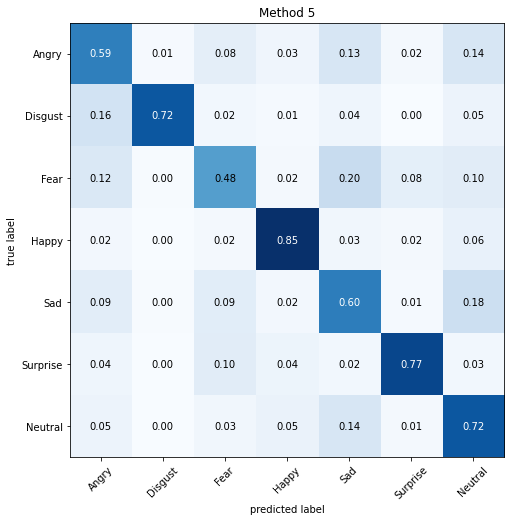

In [45]:
conf_mat = confusion_matrix(valid_labels_or, pre_mat_SIFT)
disp, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
ax.set_title("Method 5")
plt.show()

## Plot the confusion matrix of model2 (erase_v1)
此為mode2 的confusion matrix

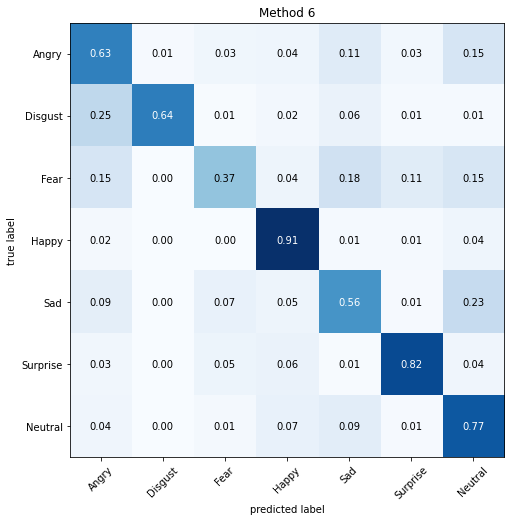

In [46]:
conf_mat = confusion_matrix(valid_labels, pre_mat_erase_v1)
disp, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
ax.set_title("Method 6")
plt.show()

## Plot the confusion matrix of model3 (erase_v2)
此為mode3 的confusion matrix

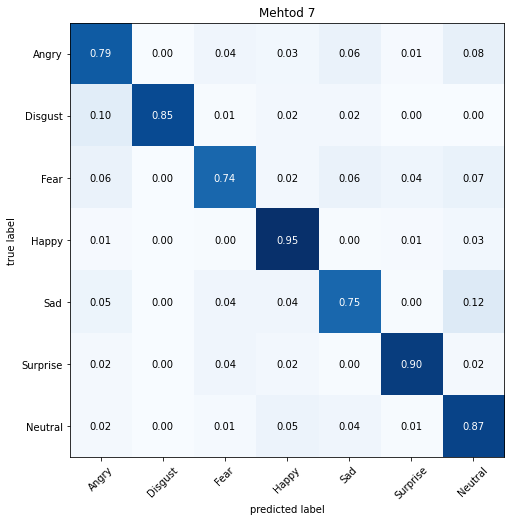

In [47]:
conf_mat = confusion_matrix(valid_labels, pre_mat_erase_v2)
disp, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
ax.set_title("Mehtod 7")
plt.show()